In [96]:
### New revised Cyano paper project figures -- removing 1CX

In [2]:
import ete3
import pandas as pd
import re
import multiprocessing
import numpy as np
import itertools
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn import manifold
import community #careful, you may need to pip remove community and pip install python-louvain to fix it!
import networkx as nx
import random
import collections
import operator
import os
from scipy import stats
import pymc3
import arviz
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
import pickle as pkl
from functools import partial
#import fastparquet

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
#!pip install python-louvain
#!pip3 install --upgrade python-louvain
#from networkx.algorithms import community
#!conda search -f python-louvain
#!conda install -n py37 python-louvain
#!conda install fastparquet

In [4]:
def get_node_age_from_descendants(tree, descendants):
    node = tree.get_common_ancestor(descendants)
    return(node.support)

In [5]:
def get_ci_of_the_mean(data, confidence=0.95):
    degrees_of_freedom = len(data) - 1
    tailed_alpha = (1 - confidence) / 2
    t_stats      = stats.t.ppf(tailed_alpha, degrees_of_freedom)
    std_err      = np.std(data) / np.sqrt( degrees_of_freedom )
    data_mean    = np.mean(data)
    return(data_mean - abs(t_stats * std_err), data_mean + abs(t_stats * std_err))

In [6]:
os.chdir('/pool001/payette/Cyano_clock7/modeldata')
!pwd

/nfs/pool002/users/payette/Cyano_clock7/modeldata


In [7]:
# HGTs | Horizontal Gene Transfers

HGT_index_name = 'HGTgpf5a'
transfer_df = pd.read_csv('HGTindex_gpf5a_5_29_21.txt', sep=',')
HGT_index_gpf_df = pd.read_excel('HGTgpf5a.xlsx') #Remove separator argument per warning  #sep=','
HGT_index_gpf_df.head() #print head of HGT_df

donor_node  recipient_node  index label  \
0         324             275      0   1BC   
1         324             268      1   2BC   
2         324             217      2   3BC   
3         313             239      3   4BC   
4         324             281      4   5BC   

                                          COG_names COG_numbers  \
0  2515/1-aminocyclopropane-1-carboxylate deaminase        2515   
1     0590/tRNA wobble adenosine to inosine editing        0590   
2     0590/tRNA wobble adenosine to inosine editing        0590   
3                                  2942/2-epimerase        2942   
4       2603/tRNA 2-selenouridine synthase activity        2603   

                       donor_clade  \
0  Sphingobacteriales/Cytophagales   
1  Sphingobacteriales/Cytophagales   
2  Sphingobacteriales/Cytophagales   
3   Bacteroidales/Flavobacteriales   
4  Sphingobacteriales/Cytophagales   

                                     recipient_clade  
0                                         Nostocales  
1                   Nostocales/Chroococcidiopsidales  
2                     Thermosynechococcus/Cyanothece  
3  Nostocales/Oscilliatoriales/Chroococcidiopsida...  
4                      Marine SynPro/Cyanobium group

In [8]:
constraints=[('324', '275'), ('324', '268'), ('324', '217'), ('313', '239'), 
 ('324', '281'), ('324', '240'), ('322', '246'), ('249', '328'), 
 ('328', '294'), ('289', '329'), ('286', '172'), 
 ('293', '218'), ('295', '249'), ('295', '274'), 
 ('287', '177'), ('312', '328'), ('312', '329'), ('313', '331'), 
 ('318', '329'), ('321', '331'), ('322', '331'), ('324', '328'), 
 ('324', '329'), ('324', '331')]

In [9]:
constraints_label_key = pd.DataFrame({'constraints': constraints,'label': HGT_index_gpf_df['label'].to_list()})
constraints_label_key['label'][constraints_label_key['constraints']==('324', '275')][0]
constraints_label_key

constraints label
0   (324, 275)   1BC
1   (324, 268)   2BC
2   (324, 217)   3BC
3   (313, 239)   4BC
4   (324, 281)   5BC
5   (324, 240)   6BC
6   (322, 246)   7BC
7   (249, 328)   1CG
8   (328, 294)   1GX
9   (289, 329)   1XG
10  (286, 172)   1XC
11  (293, 218)   2XC
12  (295, 249)   3XC
13  (295, 274)   4XC
14  (287, 177)   5XC
15  (312, 328)   1BG
16  (312, 329)   2BG
17  (313, 331)   3BG
18  (318, 329)   4BG
19  (321, 331)   5BG
20  (322, 331)   6BG
21  (324, 328)   7BG
22  (324, 329)   8BG
23  (324, 331)   9BG

In [10]:
len(HGT_index_gpf_df) == len(constraints)
#Should evaluate to True if the constraints hard coded match the excel file... I know a bit wonky.
#HGT_index_gpf_df['label'].to_list()
#constraints_label_key['label']

True

In [11]:
### Load Reference Tree datasets

In [12]:
tree              = ete3.Tree('species_tree-renamed')

In [13]:
phylo_bayes_named_tree = ete3.Tree('Cyano_modelBB_ugam_bd_7_20_sample.labels', format=1)
phylo_bayes_node_named_tree = ete3.Tree('Cyano_modelBB_ugam_bd_7_20_sample.labels',format=1) #Partially Deprecated

In [14]:
#####

In [15]:
##0. Root 
#1. Priors w/o fossil calibrations
#2. Priors w/ fossil calibrations BE
#3. Posteriors w/o fossil calibrations
#4. Posteriors w/ fossil calibrations BE

#Cyano_cir_nobd_post

#BE_cir_nobd_post = [ete3.Tree(line)
#                    for line in open('Cyano_modelBE_cir_nobd_longrun_7_20_sample.datedist').readlines()]

#'Cyano_modelBE_cir_nobd_7_20_prior_sample.datedist'

In [16]:
### New functions that work

In [17]:
#Final version in use
def assess_constraint_compatibility2(model_trees,constraint):
            older_bound   = next(phylo_bayes_named_tree.iter_search_nodes(name=(constraint[0])))
            younger_bound = next(phylo_bayes_named_tree.iter_search_nodes(name=(constraint[1])))
            compatibilities = []
            for tmp_tree in model_trees:
                older_bound_age   = get_node_age_from_descendants(tmp_tree,   older_bound.get_leaf_names())
                younger_bound_age = get_node_age_from_descendants(tmp_tree, younger_bound.get_leaf_names())
                if older_bound_age > younger_bound_age:
                    compatibilities.append(True)
                else:
                    compatibilities.append(False)
            return(compatibilities)

In [18]:
#Final version in use
def jaccard_between_constraints2(compatibility_table,constraints):
            intersection = sum(compatibility_table[constraints].T.all())
            union        = sum(compatibility_table[constraints].T.any())
            if not union:
                return(0.0)
            else:
                return(intersection/union)

In [19]:
#Final version in use
def getClusterCompatibilityAges2(model_trees,model_name):
    HGT_index_name = 'HGTgpf5a'
    
    pool    = multiprocessing.Pool(2)
    
    assess_partial = partial(assess_constraint_compatibility2,model_trees)
    
    results = pool.map(assess_partial, constraints)
    
    #pool.close()
    #pool.join()

    compatibility_table = pd.DataFrame(columns=constraints,data=np.array(results).T)
    compatibility_count      = compatibility_table.sum()
    compatibility_count.name = 'compatibility_count'
    compatibility_table.columns=constraints_label_key['label'] 
    compatibility_table.to_parquet(''+model_name+'_compatibility_table.parquet', compression='gzip')
    #convert back to constraints
    compatibility_table.columns=constraints_label_key['constraints']            
    pairs_of_constraints = [list(pair) for pair in itertools.combinations(constraints, 2)]
    
    pool                = multiprocessing.Pool(processes=4)
    
    jaccard_partial = partial(jaccard_between_constraints2,compatibility_table)
    
    condensed_distances = np.array(pool.map(jaccard_partial, pairs_of_constraints))
    jaccard_distances = pd.DataFrame(index=HGT_index_gpf_df['label'].to_list(),
                                     columns=HGT_index_gpf_df['label'].to_list(),
                                     data=squareform(condensed_distances))
    #Fig 1
    linkage = hierarchy.linkage(1-condensed_distances, method='average', metric='precomputed')

    tmp_df = jaccard_distances.copy()
    np.fill_diagonal(tmp_df.values, np.nan)

    clst_map = sns.clustermap(tmp_df,
                              row_linkage=linkage,
                              col_linkage=linkage,
                              cmap='RdBu',
                              yticklabels=True,
                              vmin=0,
                              xticklabels=True);
    clst_map.fig.set_dpi(300)
    clst_map.fig.savefig(''+model_name+'_Jaccard_Distance_Average_'+HGT_index_name+'.png',format='png',dpi=300)

    tmp_df = 1-jaccard_distances
    np.fill_diagonal(tmp_df.values, 0)

    mds = manifold.MDS(n_components=2,
                       dissimilarity='precomputed',
                       random_state=12345)
    mds_result = mds.fit(tmp_df)

    coords     = mds_result.embedding_
    constraintX, constraintY = coords[:, 0], coords[:, 1]

    #Fig 2
    fig, ax = plt.subplots()

    sns.kdeplot(constraintX, 
                constraintY,
                bw=0.2,
                n_levels=20,
                cmap='RdBu_r',
                shade=True,
    #            shade_lowest=False,
                ax=ax)

    #sns.scatterplot(x, y,
    #                hue=jaccard_distances.sum().values,
    #                palette='RdBu',
    #                alpha=0.5,
    #                legend=False,
    #                ax=ax);
    ax.plot(constraintX,
            constraintY,
            '.k', 
            alpha=0.5, 
            markersize=5)

    ax.tick_params(axis='both',
                   which='both',
                   bottom=False,
                   labelbottom=False,
                   left=False,
                   labelleft=False)
    #ax.axis('equal')
    ax.set_xlim(constraintX.min()-0.05, constraintX.max()+0.05)
    ax.set_ylim(constraintY.min()-0.05, constraintY.max()+0.05)
    fig.set_dpi(300)
    fig.tight_layout()

    #clst_map2.set_dpi(300)
    fig.savefig(''+model_name+'_Cluster_Distance_Average_'+HGT_index_name+'.png',format='png',dpi=300)
    #fig.savefig('Cluster_Distance_Average_'+model_name+'_'+HGT_index_name+'.svg',format='svg',dpi=300)

    tmp_df         = jaccard_distances.copy()
    tmp_df.index   = range(24)
    tmp_df.columns = range(24)

    #Run clustering algorithm from Jaccard Distances -- note community package frmo python-louvain
    tmp_df         = jaccard_distances.copy()
    tmp_df.index   = range(24)
    tmp_df.columns = range(24)
    graph   = nx.convert_matrix.from_pandas_adjacency(tmp_df)
    louvain = community.best_partition(graph, random_state=12345)

    clusters = []
    for count, constraint in enumerate(constraints):
        clusters.append(louvain[count])

    cluster_frequencies     = dict(collections.Counter(clusters))
    clusters_sorted_by_size = sorted(cluster_frequencies.items(), key=operator.itemgetter(1), reverse=True)

    #Create <cluster_coords> table from <comptability_count table>

    cluster_coords                 = pd.DataFrame(columns='x y cluster'.split(), 
                                                  data=zip(constraintX,constraintY, clusters))
    cluster_coords['cluster_size'] = [cluster_frequencies[cluster]
                                      for cluster in cluster_coords.cluster]
    cluster_coords.loc[cluster_coords.cluster_size<3, 'cluster'] = 0 #changed from 'none' to zero

    cluster_coords.index = constraints
    cluster_coords       = cluster_coords.join(compatibility_count)

    constraint_supports = {constraint:len(indexes)
                           for constraint, indexes in transfer_df.groupby(['donor', 'recipient']).groups.items()}
    cluster_coords      = cluster_coords.join(
        pd.DataFrame.from_dict([constraint_supports]).T
    )
    cluster_coords.rename(columns={0:'constraint_support'}, inplace=True)

    constraint_distance = [phylo_bayes_named_tree.get_distance(node1, node2)
                          for node1, node2 in cluster_coords.index]
    cluster_coords['constraint_distance'] = constraint_distance

    #Add label to cluster_coords DF
    cluster_coords['label'] = HGT_index_gpf_df['label'].to_list()

    #SAVE TO DISK

    cluster_coords.to_csv(''+model_name+'_constraint_clusters_'+HGT_index_name+'.tab', sep='\t')
    #cluster_coords.to_parquet(''+model_name+'_cluster_coords.parquet', compression='gzip')

    #Fig 3
    fig, ax = plt.subplots()

    yeah = sns.scatterplot(x='x', 
                    y='y',
                    style='cluster',
                    hue='constraint_distance',
                    palette='RdBu_r',
                    data=cluster_coords,
                    alpha=0.5,
    #                size='compatibility_count',
    #                color='black',
                    legend=False,
                    ax=ax,
                          cmap=plt.cm.get_cmap('cubehelix', 6));

    ax.tick_params(axis='both',
                   which='both',
                   bottom=False,
                   labelbottom=False,
                   left=False,
                   labelleft=False)

    #ax.axis('equal')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim(constraintX.min()-0.05, constraintX.max()+0.05)
    ax.set_ylim(constraintY.min()-0.05, constraintY.max()+0.05)
    fig.set_dpi(300)
    fig.tight_layout()

    #Fig4
    fig, ax = plt.subplots()

    sns.kdeplot(constraintX, 
                constraintY,
                bw=0.2,
                n_levels=20,
                cmap='RdBu_r',
                shade=True,
                ax=ax,
               )

    sns.scatterplot(x='x', 
                    y='y',
                    style='cluster',
    #                hue='constraint_distance',
    #                palette='RdBu_r',
                    data=cluster_coords,
                    alpha=0.5,
    #                size='compatibility_count',
                    color='black',
                    legend=False,
                    ax=ax);

    ax.tick_params(axis='both',
                   which='both',
                   bottom=False,
                   labelbottom=False,
                   left=False,
                   labelleft=False)
    #ax.axis('equal')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim(constraintX.min()-0.05, constraintX.max()+0.05)
    ax.set_ylim(constraintY.min()-0.05, constraintY.max()+0.05)
    fig.set_dpi(300)
    fig.tight_layout()
    fig.savefig(''+model_name+'_Cluster_'+HGT_index_name+'.png',format='png',dpi=300)
    #fig.savefig(''+model_name+'_Cluster_'+HGT_index_name+'.svg',format='svg',dpi=300)

    #convert back to constraints labels
    jaccard_distances = pd.DataFrame(index=constraints,
                                     columns=constraints,
                                     data=squareform(condensed_distances))




    #Fig5

    # Intra cluster Jaccard Index Distribution
    fig, axs = plt.subplots(nrows=3, figsize=(15,10))
    for cluster_num, ax in zip([0, 1], axs):
        tmp = cluster_coords.index[cluster_coords.cluster==cluster_num]
        tmp_condensed = squareform(jaccard_distances.reindex(index=tmp, columns=tmp))
        sns.kdeplot(tmp_condensed, shade=True, ax=ax, label='Cluster %i' % cluster_num)

    tmp           = cluster_coords.index[(cluster_coords.cluster!=0) &
                                         (cluster_coords.cluster!=1)]
    tmp_condensed = squareform(jaccard_distances.reindex(index=tmp, columns=tmp))
    sns.kdeplot(tmp_condensed, shade=True, ax=axs[2], label='Smaller clusters')
    fig.suptitle('Intra cluster Jaccard Index distribution', y=0.92)
    fig.set_dpi(300)
    fig.savefig(''+model_name+'_Intra_'+HGT_index_name+'.png',format='png',dpi=300)
    #fig.savefig(''+model_name+'_Intra_'+HGT_index_name+'.svg',format='svg',dpi=300)

    # Run code to get node ages, from clustering, per model

    target_node_ages = {
                        '170':[], #Crown Bacteria (Root)
                        '172':[], #Stem Cyanobacteria
                        '177':[], #Crown Cyanobacteria
                        #'286':[], #Crown Chloroflexi
                        #'290':[], #Stem Chloroflexia
                        #'293':[], #Crown Chloroflexia
                        #'328':[], #Stem Chlorobi
                        #'329':[], #Crown Chlorobi
                        '281':[] #Stem SynPro
                        #'283':[], #Crown SynPro
                        #'181':[], #Stem Plastids
                        #'182':[], #Crown Plastids
                        #'239':[], #Scytonemin Divergence
                        #'243':[]  #Scytonemin Crown
                        }

    #Clustering & Threshold selection
    #Must be manually set

    cluster0               = set(cluster_coords.query('compatibility_count>0').index.tolist())

    cluster0_compatibility = compatibility_table[cluster0]
    num_trees, num_constraints = cluster0_compatibility.shape
    num_compatibles            = cluster0_compatibility.T.sum()

    x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24] #24 Total Constraints in play
    
    #OLD NOTES:
    #x = np.linspace(1,num_constraints,num_constraints+1) #23 constraints bottom 2 excluded
    #x[20] is the 21 constraint threshold if using linspace, like above

    #x >= 21 # Target constraint threshold pre-determined.

    # Legacy stuff
    #print(np.linspace(1,len(cluster_coords)),
    #                  len(cluster_coords)+1)
    #These are the points upon which the attrition curve can be drawn. Important to note index 20 is for
    #at least 20.1 HGTs passing which means 21 (92 tree sample) and not 21~~~ confusing, I know, python indexing is!
    #
    #
    #[ 1.          1.48979592  1.97959184  2.46938776  2.95918367  3.44897959
    #  3.93877551  4.42857143  4.91836735  5.40816327  5.89795918  6.3877551
    #  6.87755102  7.36734694  7.85714286  8.34693878  8.83673469  9.32653061
    #  9.81632653 10.30612245 10.79591837 11.28571429 11.7755102  12.26530612
    # 12.75510204 13.24489796 13.73469388 14.2244898  14.71428571 15.20408163
    # 15.69387755 16.18367347 16.67346939 17.16326531 17.65306122 18.14285714
    # 18.63265306 19.12244898 19.6122449  20.10204082 20.59183673 21.08163265
    # 21.57142857 22.06122449 22.55102041 23.04081633 23.53061224 24.02040816
    # 24.51020408 25.        ] 26
    #
    #np.ceil(np.linspace(1,len(cluster_coords),len(cluster_coords)+1)[20])

    y = []

    target_node_descendants = {}
    for node_name in target_node_ages:
        node = next(phylo_bayes_named_tree.iter_search_nodes(name=node_name))
        target_node_descendants[node_name] = node.get_leaf_names()

    for thresh in x:
        compatible_trees = num_compatibles[num_compatibles >= thresh].index
        y.append(len(compatible_trees)/num_trees)

        for target_node in target_node_ages.keys():
            target_node_ages[target_node].append([])

        for tree_index, target_node in itertools.product(compatible_trees, target_node_ages.keys()):
            target_node_ages[target_node][-1].append(
                get_node_age_from_descendants(
                    model_trees[tree_index],
                    target_node_descendants[target_node]
                )
            )
    y = np.array(y)

    # Save variables to disk
    with open(''+model_name+'_x.pickle', 'wb') as out:
        pkl.dump(x, out)
    with open(''+model_name+'_y.pickle', 'wb') as out:
        pkl.dump(y, out)
    with open(''+model_name+'_target_node_ages.pickle', 'wb') as out:
        pkl.dump(target_node_ages, out)
    with open(''+model_name+'_cluster0_compatibility.pickle', 'wb') as out:
        pkl.dump(cluster0_compatibility, out)

In [20]:
def getCurve(model_name,x_range):
    with open(''+model_name+'_x.pickle', 'rb') as into:   
         x = pkl.load(into)
    #print(x)
    with open(''+model_name+'_y.pickle', 'rb') as into:  
         y = pkl.load(into)
    #print(y)
    with open(''+model_name+'_target_node_ages.pickle', 'rb') as into:   
         target_node_ages = pkl.load(into)
    #print(target_node_ages)
    with open(''+model_name+'_cluster0_compatibility.pickle', 'rb') as into:
         cluster0_compatibility = pkl.load(into)

    
    print('No. HGTs:',x[0]) #Remember Python indexing starts at Zer0000!!!!
    node_name_print='177'
    print('Trees:',len(target_node_ages[node_name_print][0]))
    print('Node',node_name_print)
    print('Mean',np.mean(target_node_ages[node_name_print][0])) #Mean
    print('Median',np.median(target_node_ages[node_name_print][0])) #Median
    print('Recent HPD',arviz.hdi(np.array(target_node_ages[node_name_print][0]),hdi_prob=0.95)[0]) #Recent
    print('Ancient HPD',arviz.hdi(np.array(target_node_ages[node_name_print][0]),hdi_prob=0.95)[1]) #Ancient   

    #Fig 6
    
    num_trees, num_constraints = cluster0_compatibility.shape
    num_compatibles            = cluster0_compatibility.T.sum()

    node_name_print='177'

    x = x_range
    x = np.array(x)
    y = []

    for thresh in x:
        compatible_trees = num_compatibles[num_compatibles >= thresh].index
        y.append(len(compatible_trees)/num_trees)
    y = np.array(y)

    node_hi=list()
    node_lo=list()
    node_med=list()
    node_mean=list()
    node_ci_low=list()
    node_ci_hi=list()
    node_cred_lo=list()
    node_cred_hi=list()
    node_means=list()
    try:
            for node_ages, thresh in zip(target_node_ages[node_name_print], x):
                node_hi.append(get_ci_of_the_mean(np.array(node_ages))[1])
                node_lo.append(get_ci_of_the_mean(np.array(node_ages))[0])
                node_med.append(np.median(node_ages))
                node_mean.append(np.mean(node_ages))
                node_ci_low.append(get_ci_of_the_mean(node_ages)[0])
                node_ci_hi.append(get_ci_of_the_mean(node_ages)[1])
                node_cred_lo.append(arviz.hdi(np.array(node_ages),hdi_prob=0.95)[0])
                node_cred_hi.append(arviz.hdi(np.array(node_ages),hdi_prob=0.95)[1])
                node_means.append(np.mean(np.array(node_ages)))
    except ValueError:
            return
    else:
            fig, ax = plt.subplots(dpi=300)
            ax2 = ax.twinx()
            ax3 = ax.twinx()
            ax.set_xlabel('HGT constraints passed') #% num_constraints
            ax.set_ylabel('Compatible trees (Percent) (n=%i)' % num_trees)
            #ax.set_yscale('log')
            #print(x)
            #print(y)
            ax.plot(x,y*100,color='black')

            ax.set_xlim(1,23)
            ax2.set_xlim(1,23)
            ax3.set_xlim(1,23)

            ax.set_xticks(x)
            ax.set_yticks(np.arange(0,110,step=10))


            ax2.set_ylim(2500,3500)
            ax3.set_ylim(2500,3500)

            ax2.set_yticks(np.arange(2500,3600,step=100))
            ax3.set_yticks(np.arange(2500,3600,step=100))

            ax2.set_ylabel('Age (Ma)')
            ax3.set_ylabel('Age (Ma)')

            ax2.yaxis.label.set_color('blue')
            ax3.yaxis.label.set_color('blue')

            ax2.tick_params(axis='y', colors='blue')
            ax2.spines["right"].set_edgecolor('blue')

            ax3.tick_params(axis='y', colors='blue')
            ax3.spines["right"].set_edgecolor('blue')

            #ax2.plot((x),node_lo,color='blue',linewidth=0.5)
            #ax3.plot((x),node_hi,color='blue',linewidth=0.5)

            ax3.fill_between((x), node_cred_lo, node_cred_hi,alpha=0.07,color='blue')

            ax3.plot((x),node_means,color='blue',linewidth=1.5,linestyle='--')
            ax3.plot((x),node_cred_lo,color='blue',linewidth=0.75)
            ax3.plot((x),node_cred_hi,color='blue',linewidth=0.75)

            #ax.axvline(19,0,10000,linestyle='--',alpha=0.4,color='grey')
            #ax.axhline(4.3,0,10000,linestyle='--',alpha=0.4,color='grey')

            #ax.axvline(20,0,10000,linestyle='--',alpha=0.4,color='grey')
            #ax.axhline(12.5,0,10000,linestyle='--',alpha=0.4,color='grey')

            ax.axvline(21,0,1,linestyle='--',alpha=0.4,color='grey')
            ax.axhline(len(cluster0_compatibility.T[num_compatibles[num_compatibles>=21].index].T)/len(cluster0_compatibility.T[num_compatibles[num_compatibles>=0].index].T)*100
                       ,0,0.9,linestyle='--',alpha=0.4,color='grey')

            #ax3.axhline(2899,0.91,1,linestyle='--',alpha=0.4,color='red')
            #ax3.axhline(2980,0.5,1,linestyle='--',alpha=0.4,color='red')

            #print('Node Means:',node_means)

            plt.tight_layout()
            fig.savefig(''+model_name+'_Attrition_Curve_'+node_name_print+'.png',format='png')
            #fig.savefig(''+model_name+'_Attrition_Curve_'+node_name_print+'.svg',format='svg')

In [21]:
def getAges(model_name):   
    with open(''+model_name+'_x.pickle', 'rb') as into:   
        model_target_x = pkl.load(into)
        
    with open(''+model_name+'_y.pickle', 'rb') as into:   
        model_target_y = pkl.load(into)
        
    with open(''+model_name+'_target_node_ages.pickle', 'rb') as into:  
        model_target_node_ages = pkl.load(into)
    return(model_target_x,model_target_y,model_target_node_ages)

In [22]:
!pwd

/nfs/pool002/users/payette/Cyano_clock7/modeldata


In [23]:
### Example call to load data

In [24]:
# XXXX = [ete3.Tree(line)
#                    for line in open('XXXX.datedist').readlines()]

In [25]:
# %%capture
# getClusterCompatibilityAges2(XXXXmodel_name,'XXXXmodel_name')

In [26]:
# run all BE posteriors

In [30]:
BE_ugam_bd_post = [ete3.Tree(line)
                    for line in open('Cyano_modelBE_ugam_bd_7_20_sample.datedist').readlines()]

In [31]:
%%capture
getClusterCompatibilityAges2(BE_ugam_bd_post,'BE_ugam_bd_post')

In [32]:
BE_ugam_nobd_post = [ete3.Tree(line)
                    for line in open('Cyano_modelBE_ugam_nobd_7_20_sample.datedist').readlines()]

In [33]:
%%capture
getClusterCompatibilityAges2(BE_ugam_nobd_post,'BE_ugam_nobd_post')

In [34]:
BE_cir_bd_post = [ete3.Tree(line)
                    for line in open('Cyano_modelBE_cir_bd_longrun_7_20_sample.datedist').readlines()]

In [35]:
%%capture
getClusterCompatibilityAges2(BE_cir_bd_post,'BE_cir_bd_post')

In [36]:
BE_cir_nobd_post = [ete3.Tree(line)
                    for line in open('Cyano_modelBE_cir_nobd_longrun_7_20_sample.datedist').readlines()]

In [37]:
%%capture
getClusterCompatibilityAges2(BE_cir_nobd_post,'BE_cir_nobd_post')

In [42]:
BE_ln_bd_post = [ete3.Tree(line)
                    for line in open('Cyano_modelBE_ln_bd_7_20_sample.datedist').readlines()]

In [43]:
%%capture
getClusterCompatibilityAges2(BE_ln_bd_post,'BE_ln_bd_post')

In [44]:
BE_ln_nobd_post = [ete3.Tree(line)
                    for line in open('Cyano_modelBE_ln_nobd_7_20_sample.datedist').readlines()]

In [45]:
%%capture
getClusterCompatibilityAges2(BE_ln_nobd_post,'BE_ln_nobd_post')

In [97]:
# run all BE priors

In [98]:
BE_ugam_bd_prior = [ete3.Tree(line)
                    for line in open('Cyano_modelBE_ugam_bd_prior_2_11_21_sample.datedist').readlines()]

In [99]:
%%capture
getClusterCompatibilityAges2(BE_ugam_bd_prior,'BE_ugam_bd_prior')

In [100]:
BE_ugam_nobd_prior = [ete3.Tree(line)
                    for line in open('Cyano_modelBE_ugam_nobd_prior_2_9_21_sample.datedist').readlines()]

In [101]:
%%capture
getClusterCompatibilityAges2(BE_ugam_nobd_prior,'BE_ugam_nobd_prior')

In [102]:
BE_cir_bd_prior = [ete3.Tree(line)
                    for line in open('Cyano_modelBE_cir_bd_prior_2_18_21_sample.datedist').readlines()]

In [103]:
%%capture
getClusterCompatibilityAges2(BE_cir_bd_prior,'BE_cir_bd_prior')

In [104]:
BE_cir_nobd_prior = [ete3.Tree(line)
                    for line in open('Cyano_modelBE_cir_nobd_prior_2_9_21_sample.datedist').readlines()]

In [105]:
%%capture
getClusterCompatibilityAges2(BE_cir_nobd_prior,'BE_cir_nobd_prior')

In [106]:
BE_ln_bd_prior = [ete3.Tree(line)
                    for line in open('Cyano_modelBE_ln_bd_prior_2_9_21_sample.datedist').readlines()]

In [107]:
%%capture
getClusterCompatibilityAges2(BE_ln_bd_prior,'BE_ln_bd_prior')

In [108]:
BE_ln_nobd_prior = [ete3.Tree(line)
                    for line in open('Cyano_modelBE_ln_nobd_prior_2_9_21_sample.datedist').readlines()]

In [109]:
%%capture
getClusterCompatibilityAges2(BE_ln_nobd_prior,'BE_ln_nobd_prior')

In [46]:
# run all NoFossil posteriors

In [47]:
NF_ugam_bd_post = [ete3.Tree(line)
                    for line in open('Cyano_ugam_bd_7_20_sample_NF_post.datedist').readlines()]

In [48]:
%%capture
getClusterCompatibilityAges2(NF_ugam_bd_post,'NF_ugam_bd_post')

In [23]:
NF_ugam_nobd_post = [ete3.Tree(line)
                    for line in open('Cyano_ugam_nobd_7_20_sample_NF_post.datedist').readlines()]

In [24]:
%%capture
getClusterCompatibilityAges2(NF_ugam_nobd_post,'NF_ugam_nobd_post')

In [25]:
#CIR BD
NF_cir_bd_post = [ete3.Tree(line)
                    for line in open('Cyano_cir_bd_7_20_sample_NF_post_2_25_21.datedist').readlines()]

In [26]:
%%capture
getClusterCompatibilityAges2(NF_cir_bd_post,'NF_cir_bd_post')

In [27]:
NF_cir_nobd_post = [ete3.Tree(line)
                    for line in open('Cyano_cir_nobd_7_20_sample_NF_post.datedist').readlines()]

In [28]:
%%capture
getClusterCompatibilityAges2(NF_cir_nobd_post,'NF_cir_nobd_post')

In [29]:
#LN BD
NF_ln_bd_post = [ete3.Tree(line)
                    for line in open('Cyano_ln_bd_7_20_sample_NF_post.datedist').readlines()]

In [30]:
%%capture
getClusterCompatibilityAges2(NF_ln_bd_post,'NF_ln_bd_post')

In [31]:
NF_ln_nobd_post = [ete3.Tree(line)
                    for line in open('Cyano_ln_nobd_7_20_sample_NF_post.datedist').readlines()]

In [32]:
%%capture
getClusterCompatibilityAges2(NF_ln_nobd_post,'NF_ln_nobd_post')

In [33]:
#### Build Figure 1 ####

In [57]:
BA_cir_nobd = [ete3.Tree(line)
                    for line in open('Cyano_modelBA_cir_nobd_7_20_sample.datedist').readlines()]

In [58]:
%%capture
getClusterCompatibilityAges2(BA_cir_nobd,'BA_cir_nobd')

In [59]:
BB_cir_nobd = [ete3.Tree(line)
                    for line in open('Cyano_modelBB_cir_nobd_7_20_sample.datedist').readlines()]

In [60]:
%%capture
getClusterCompatibilityAges2(BB_cir_nobd,'BB_cir_nobd')

In [61]:
#Cyano_modelBD_cir_nobd_7_20_sample.datedist

In [62]:
BE_cir_nobd = [ete3.Tree(line)
                    for line in open('Cyano_modelBE_cir_nobd_7_20_sample.datedist').readlines()]

In [63]:
%%capture
getClusterCompatibilityAges2(BE_cir_nobd,'BE_cir_nobd')

In [64]:
BI_cir_nobd = [ete3.Tree(line)
                    for line in open('Cyano_modelBI_cir_nobd_7_20_sample.datedist').readlines()]

In [65]:
%%capture
getClusterCompatibilityAges2(BI_cir_nobd,'BI_cir_nobd')

In [66]:
BJ_cir_nobd = [ete3.Tree(line)
                    for line in open('Cyano_modelBJ_cir_nobd_7_20_sample.datedist').readlines()]

In [67]:
%%capture
getClusterCompatibilityAges2(BJ_cir_nobd,'BJ_cir_nobd')

In [68]:
#Build node ages
BA_cir_nobd_x, BA_cir_nobd_y, BA_cir_nobd_target_node_ages = getAges('BA_cir_nobd')
BB_cir_nobd_x, BB_cir_nobd_y, BB_cir_nobd_target_node_ages = getAges('BB_cir_nobd')
BE_cir_nobd_x, BE_cir_nobd_y, BE_cir_nobd_target_node_ages = getAges('BE_cir_nobd')
BI_cir_nobd_x, BI_cir_nobd_y, BI_cir_nobd_target_node_ages = getAges('BI_cir_nobd')
BJ_cir_nobd_x, BJ_cir_nobd_y, BJ_cir_nobd_target_node_ages = getAges('BJ_cir_nobd')

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


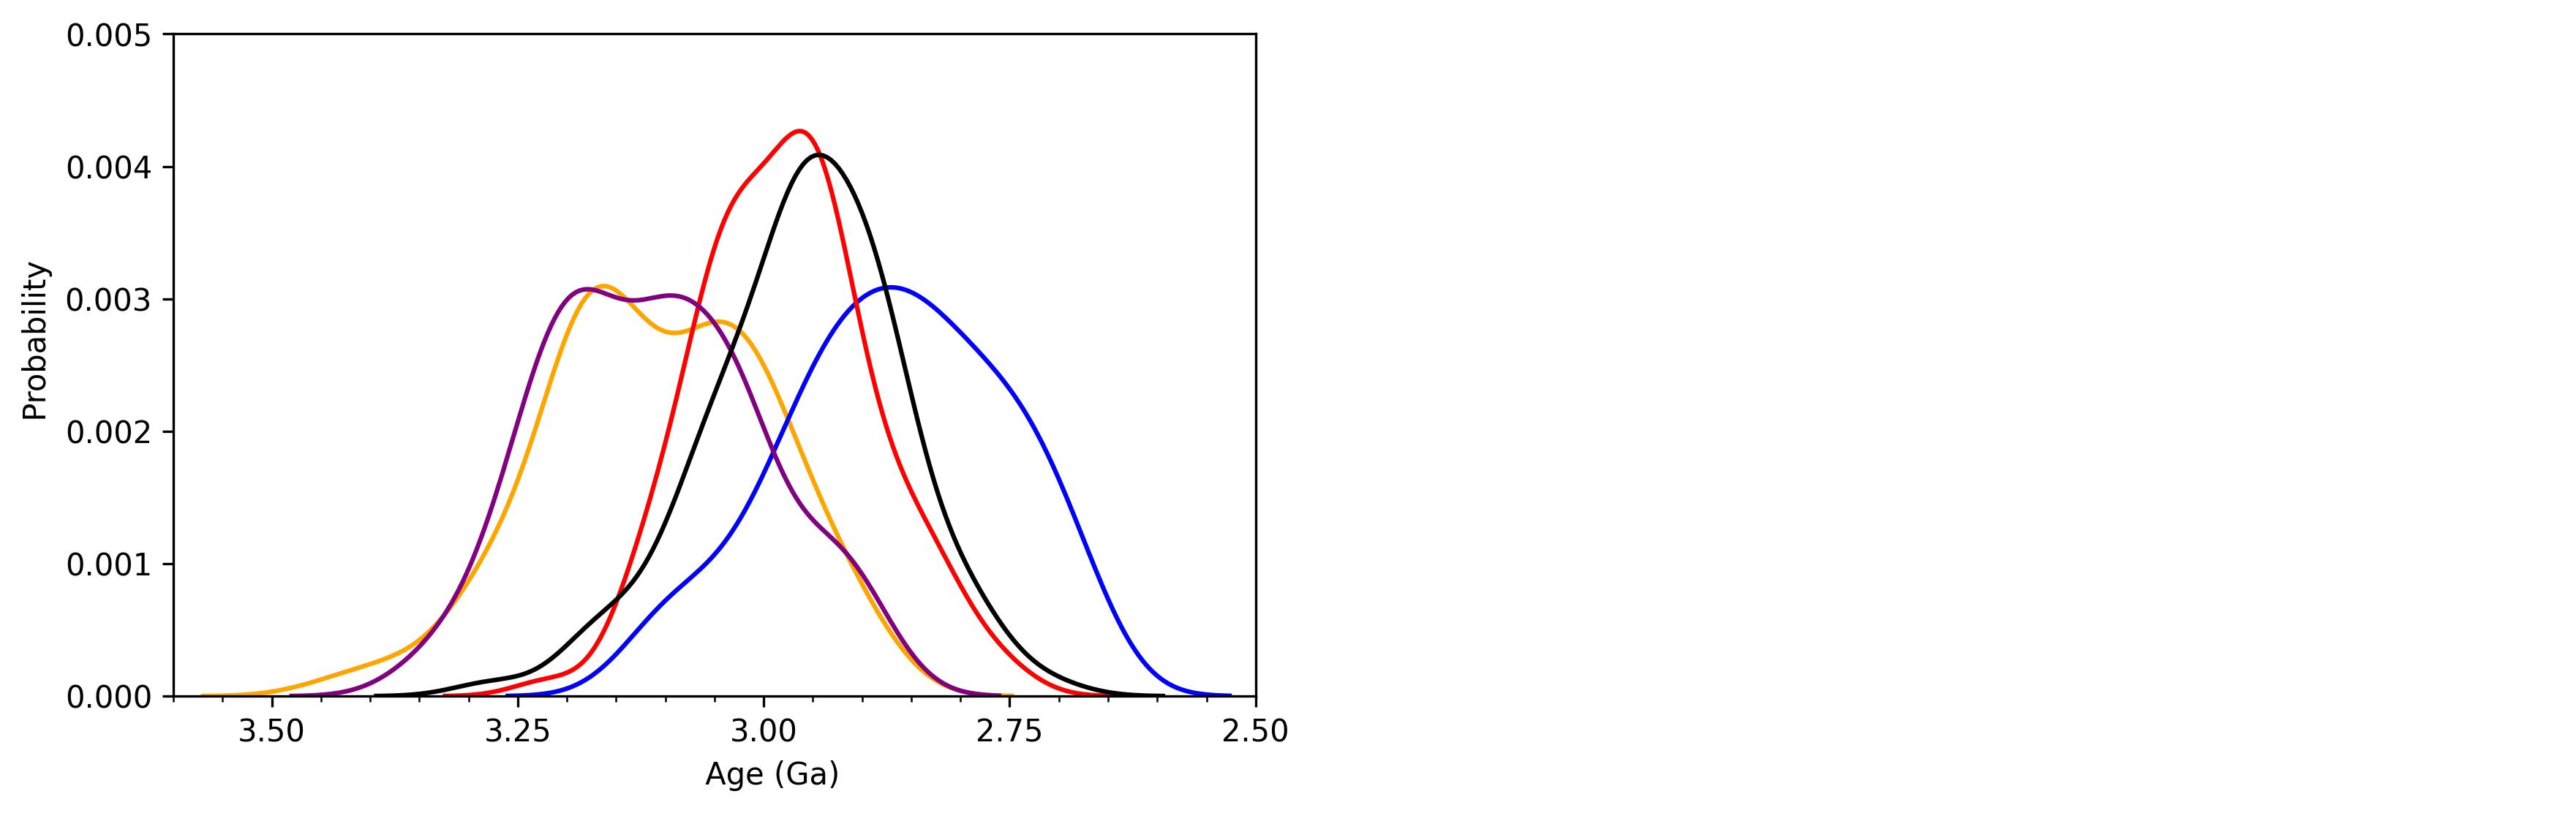

In [92]:
#Switch to KDE plot -- dist plot will die :-/
model_name='B_models_cir_nobd'
run_name = 'CFig_v10'

kwargs = {"linewidth" : "1.5"}
#kwargs = dict()
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=False,sharey=True,dpi=300)

axes[0].set_ylabel("     Probability")
axes[0].set_xlabel("             Age (Ga) ")
axes[0].set_ylim([0,0.005001])
axes[0].yaxis.set_ticks(np.arange(0,0.005001,0.001))

#x0values = ['','2.5','2.6','2.7','2.8','2.9','3','3.1','3.2','3.3','3.4','3.5','3.6']
x0values = ['','2.50','2.75','3.00','3.25','3.50']

#axes[0].legend()
axes[0]=sns.kdeplot(BA_cir_nobd_target_node_ages['177'][0],label="Crown Cyanobacteria (177)",ax=axes[0],color="orange", **kwargs)
axes[0]=sns.kdeplot(BB_cir_nobd_target_node_ages['177'][0],label="Crown Cyanobacteria (177)",ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(BE_cir_nobd_target_node_ages['177'][0],label="Crown Cyanobacteria (177)",ax=axes[0],color="red", **kwargs)
axes[0]=sns.kdeplot(BI_cir_nobd_target_node_ages['177'][0],label="Crown Cyanobacteria (177)",ax=axes[0],color="purple", **kwargs)
axes[0]=sns.kdeplot(BJ_cir_nobd_target_node_ages['177'][0],label="Crown Cyanobacteria (177)",ax=axes[0],color="black", **kwargs)

axes[0].set_xlim([3600,2500])
axes[0].xaxis.set_minor_locator(MultipleLocator(50))
axes[0].xaxis.set_major_locator(MultipleLocator(250))
axes[0].set_xticklabels(x0values)

axes[1].axis('off')

#plt.show()
#plt.tight_layout()
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_177'+'.png',format='png')
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_177'+'.svg',format='svg')

In [70]:
##### In Dev.

In [71]:
#####

In [35]:
NF_ugam_bd_post_x, NF_ugam_bd_post_y, NF_ugam_bd_post_target_node_ages = getAges('NF_ugam_bd_post')
NF_ugam_nobd_post_x, NF_ugam_nobd_post_y, NF_ugam_nobd_post_target_node_ages = getAges('NF_ugam_nobd_post')

NF_cir_bd_post_x, NF_cir_bd_post_y, NF_cir_bd_post_target_node_ages = getAges('NF_cir_bd_post')
NF_cir_nobd_post_x, NF_cir_nobd_post_y, NF_cir_nobd_post_target_node_ages = getAges('NF_cir_nobd_post')

NF_ln_bd_post_x, NF_ln_bd_post_y, NF_ln_bd_post_target_node_ages = getAges('NF_ln_bd_post')
NF_ln_nobd_post_x, NF_ln_nobd_post_y, NF_ln_nobd_post_target_node_ages = getAges('NF_ln_nobd_post')

In [36]:
BE_ugam_bd_post_x, BE_ugam_bd_post_y, BE_ugam_bd_post_target_node_ages = getAges('BE_ugam_bd_post')
BE_ugam_nobd_post_x, BE_ugam_nobd_post_y, BE_ugam_nobd_post_target_node_ages = getAges('BE_ugam_nobd_post')

BE_cir_bd_post_x, BE_cir_bd_post_y, BE_cir_bd_post_target_node_ages = getAges('BE_cir_bd_post')
BE_cir_nobd_post_x, BE_cir_nobd_post_y, BE_cir_nobd_post_target_node_ages = getAges('BE_cir_nobd_post')

BE_ln_bd_post_x, BE_ln_bd_post_y, BE_ln_bd_post_target_node_ages = getAges('BE_ln_bd_post')
BE_ln_nobd_post_x, BE_ln_nobd_post_y, BE_ln_nobd_post_target_node_ages = getAges('BE_ln_nobd_post')

In [110]:
BE_ugam_bd_prior_x, BE_ugam_bd_prior_y, BE_ugam_bd_prior_target_node_ages = getAges('BE_ugam_bd_prior')
BE_ugam_nobd_prior_x, BE_ugam_nobd_prior_y, BE_ugam_nobd_prior_target_node_ages = getAges('BE_ugam_nobd_prior')

BE_cir_bd_prior_x, BE_cir_bd_prior_y, BE_cir_bd_prior_target_node_ages = getAges('BE_cir_bd_prior')
BE_cir_nobd_prior_x, BE_cir_nobd_prior_y, BE_cir_nobd_prior_target_node_ages = getAges('BE_cir_nobd_prior')

BE_ln_bd_prior_x, BE_ln_bd_prior_y, BE_ln_bd_prior_target_node_ages = getAges('BE_ln_bd_prior')
BE_ln_nobd_prior_x, BE_ln_nobd_prior_y, BE_ln_nobd_prior_target_node_ages = getAges('BE_ln_nobd_prior')

In [37]:
### Re-run with correct random seed for Root Priors

In [38]:
np.random.seed(1234)
root_prior_values = np.random.normal(loc=3900,scale=200, size=1000)
print(root_prior_values)

[3994.28703275 3661.80486106 4186.54139369 3837.46962078 3755.88225333
 4077.43258806 4071.91768274 3772.69529912 3903.13927442 3451.46300916
 4130.00714494 4098.38920447 4090.66482562 3495.74903596 3833.18452684
 3900.42367294 3981.09068231 3957.8183882  4164.23163843 3590.61888935
 3859.47073507 3768.80613117 3938.68427529 4010.68778219 4163.63031084
 3806.13894306 4035.11081702 3536.59455468 3863.37829196 4111.79383751
 3820.43195436 3967.48753072 4109.51571458 4109.18765113 4072.74345834
 3875.58168503 3924.94259075 3835.44103888 4068.3349426  4378.19210309
 3915.23991757 3786.71081391 3907.22838734 3485.00447986 3949.55843995
 3720.56864311 3872.64103335 3903.65783827 4051.08279648 3943.05371619
 4068.20175899 3610.83798459 3619.6053437  3879.81636001 3790.35151016
 3871.07609833 3970.80406644 3892.89739494 4013.14766121 4209.13176093
 3705.15273325 3885.93102458 3961.59377104 3858.30024738 4106.76014651
 3419.90927324 4306.12072417 3671.4737422  3942.37667736 4040.94412486
 3742.

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

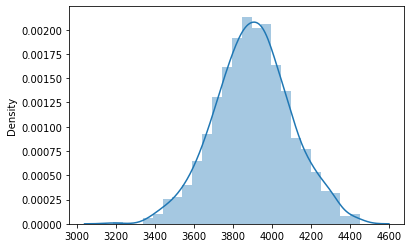

In [39]:
sns.distplot(root_prior_values)

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator


Model BE w/ Fossil Calibrations


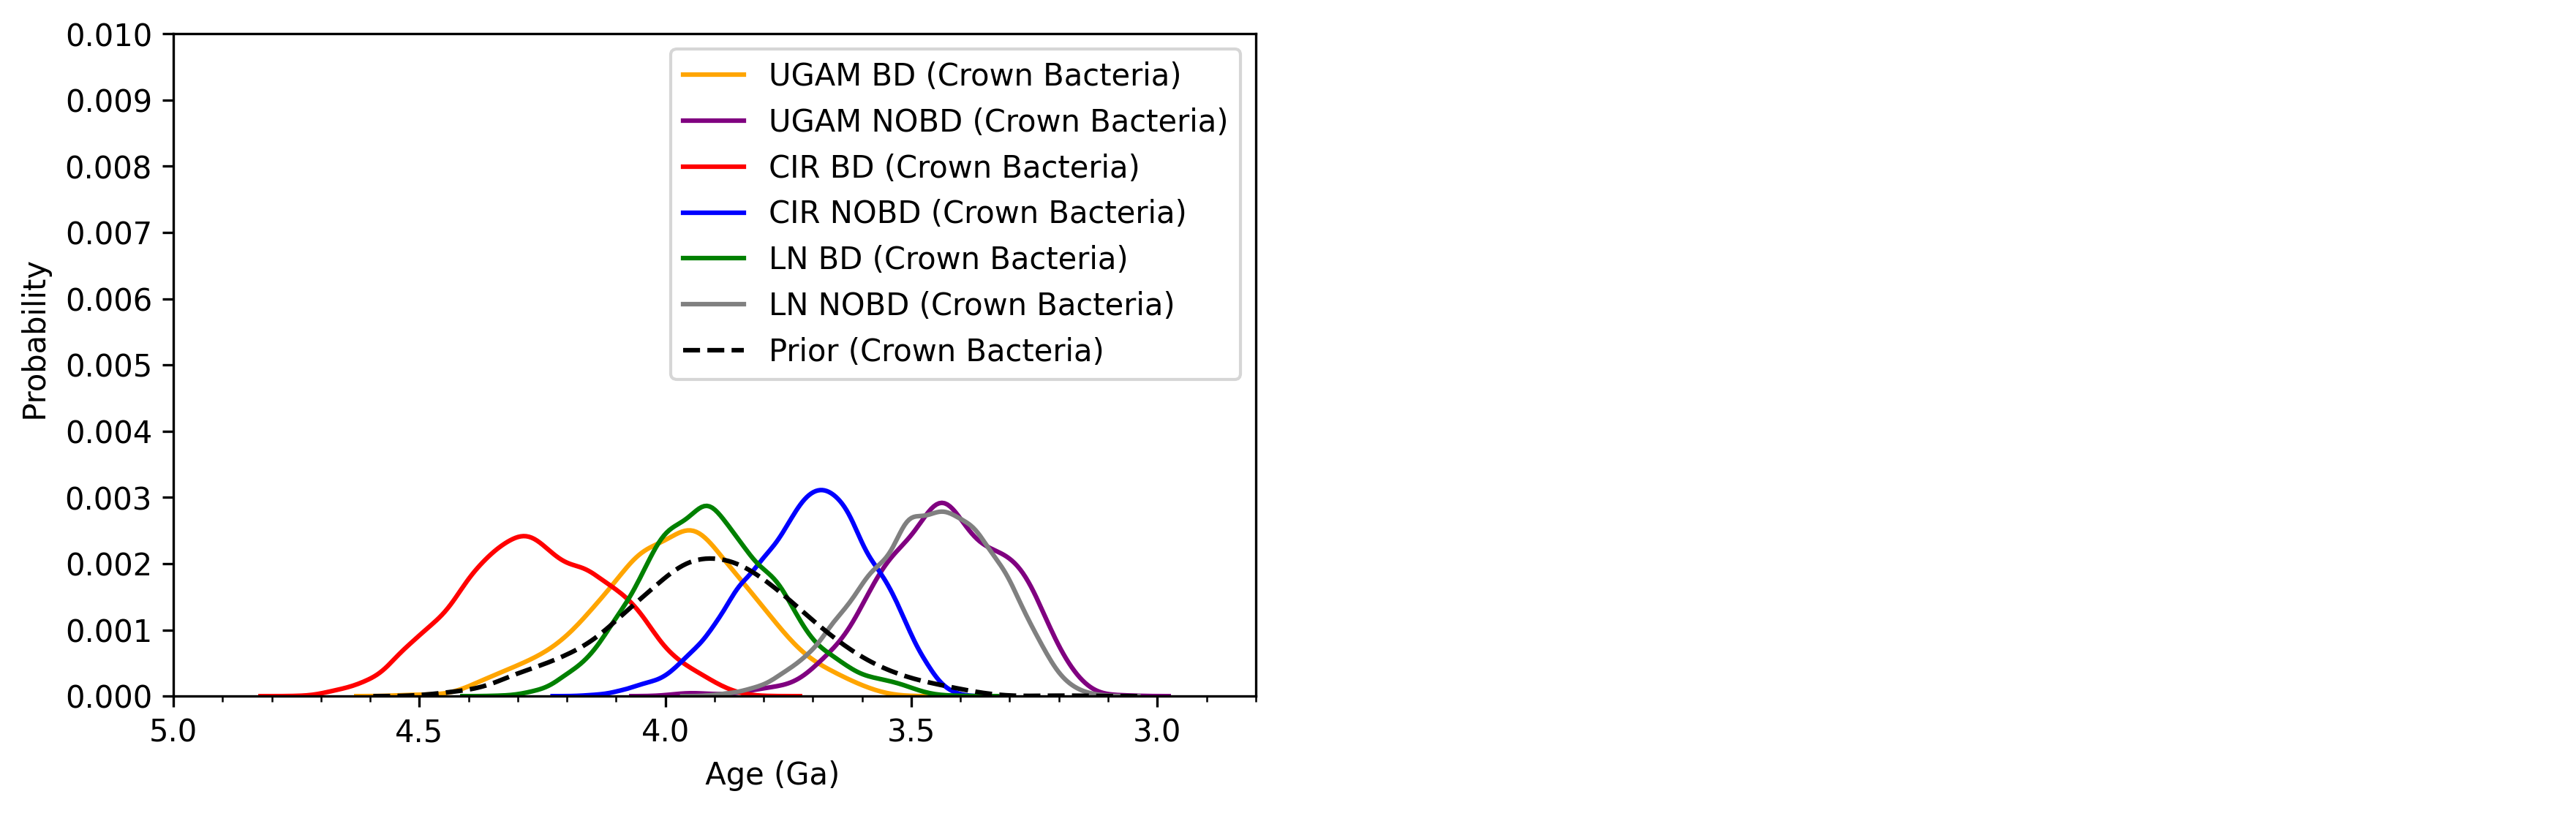

In [85]:
#Switch to KDE plot -- dist plot will die :-/
model_name='BE_all_'
run_name = 'CFig_posterior'

kwargs = {"linewidth" : "1.5"}
#kwargs = dict()
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=False,sharey=True,dpi=300)

axes[0].set_ylabel("     Probability")
axes[0].set_xlabel("             Age (Ga) ")
axes[0].set_ylim([0,0.010001])
axes[0].yaxis.set_ticks(np.arange(0,0.010001,0.001))

#x0values = ['','2.5','2.6','2.7','2.8','2.9','3','3.1','3.2','3.3','3.4','3.5','3.6']
x0values = ['','3.0','3.5','4.0','4.5','5.0']

#axes[0].legend()
axes[0]=sns.kdeplot(BE_ugam_bd_post_target_node_ages['170'][0],label="UGAM BD (Crown Bacteria)",ax=axes[0],color="orange", **kwargs)
axes[0]=sns.kdeplot(BE_ugam_nobd_post_target_node_ages['170'][0],label="UGAM NOBD (Crown Bacteria)",ax=axes[0],color="purple", **kwargs)
axes[0]=sns.kdeplot(BE_cir_bd_post_target_node_ages['170'][0],label="CIR BD (Crown Bacteria)",ax=axes[0],color="red", **kwargs)
axes[0]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['170'][0],label="CIR NOBD (Crown Bacteria)",ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(BE_ln_bd_post_target_node_ages['170'][0],label="LN BD (Crown Bacteria)",ax=axes[0],color="green", **kwargs)
axes[0]=sns.kdeplot(BE_ln_nobd_post_target_node_ages['170'][0],label="LN NOBD (Crown Bacteria)",ax=axes[0],color="grey", **kwargs)
axes[0]=sns.kdeplot(root_prior_values,label="Prior (Crown Bacteria)",ax=axes[0],color="black", **kwargs,linestyle='--')

axes[0].set_xlim([5000,2800])
axes[0].xaxis.set_minor_locator(MultipleLocator(100))
axes[0].xaxis.set_major_locator(MultipleLocator(500))
axes[0].set_xticklabels(x0values)

axes[1].axis('off')

axes[0].legend()

#plt.show()
#plt.tight_layout()
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_170'+'.png',format='png')
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_170'+'.svg',format='svg')
print('Model BE w/ Fossil Calibrations')

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator


Model No Fossil w/ Only Root Prior


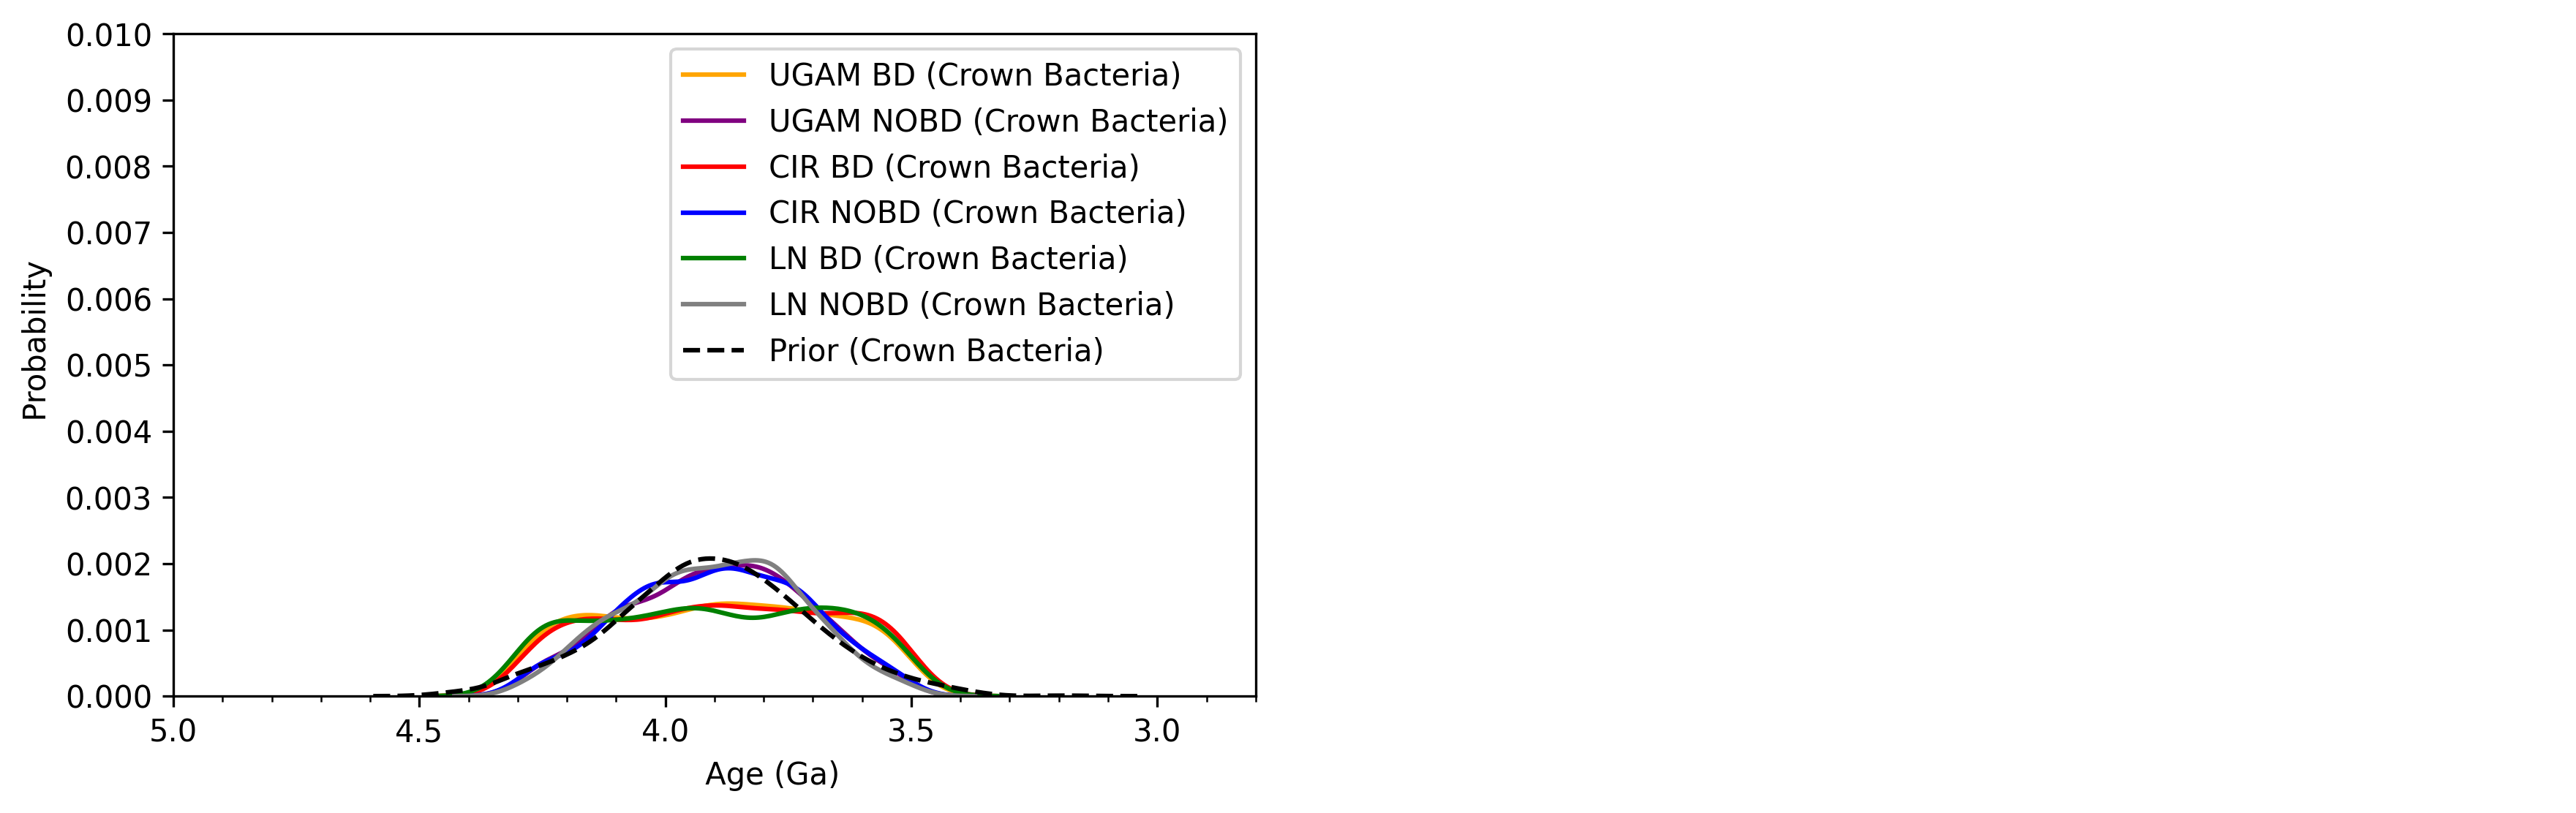

In [95]:
#Switch to KDE plot -- dist plot will die :-/
model_name='NF_all_'
run_name = 'CFig_posterior'

kwargs = {"linewidth" : "1.5"}
#kwargs = dict()
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=False,sharey=True,dpi=300)

axes[0].set_ylabel("     Probability")
axes[0].set_xlabel("             Age (Ga) ")
axes[0].set_ylim([0,0.010001])
axes[0].yaxis.set_ticks(np.arange(0,0.010001,0.001))

#x0values = ['','2.5','2.6','2.7','2.8','2.9','3','3.1','3.2','3.3','3.4','3.5','3.6']
x0values = ['','3.0','3.5','4.0','4.5','5.0']

#axes[0].legend()
axes[0]=sns.kdeplot(NF_ugam_bd_post_target_node_ages['170'][0],label="UGAM BD (Crown Bacteria)",ax=axes[0],color="orange", **kwargs)
axes[0]=sns.kdeplot(NF_ugam_nobd_post_target_node_ages['170'][0],label="UGAM NOBD (Crown Bacteria)",ax=axes[0],color="purple", **kwargs)
axes[0]=sns.kdeplot(NF_cir_bd_post_target_node_ages['170'][0],label="CIR BD (Crown Bacteria)",ax=axes[0],color="red", **kwargs)
axes[0]=sns.kdeplot(NF_cir_nobd_post_target_node_ages['170'][0],label="CIR NOBD (Crown Bacteria)",ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(NF_ln_bd_post_target_node_ages['170'][0],label="LN BD (Crown Bacteria)",ax=axes[0],color="green", **kwargs)
axes[0]=sns.kdeplot(NF_ln_nobd_post_target_node_ages['170'][0],label="LN NOBD (Crown Bacteria)",ax=axes[0],color="grey", **kwargs)
axes[0]=sns.kdeplot(root_prior_values,label="Prior (Crown Bacteria)",ax=axes[0],color="black", **kwargs,linestyle='--')

axes[0].set_xlim([5000,2800])
axes[0].xaxis.set_minor_locator(MultipleLocator(100))
axes[0].xaxis.set_major_locator(MultipleLocator(500))
axes[0].set_xticklabels(x0values)

axes[1].axis('off')

axes[0].legend()

#plt.show()
#plt.tight_layout()
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_170'+'.png',format='png')
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_170'+'.svg',format='svg')
print('Model No Fossil w/ Only Root Prior')

In [ ]:
### Version 2 for Greg

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator


Model BE w/ Fossil Calibrations


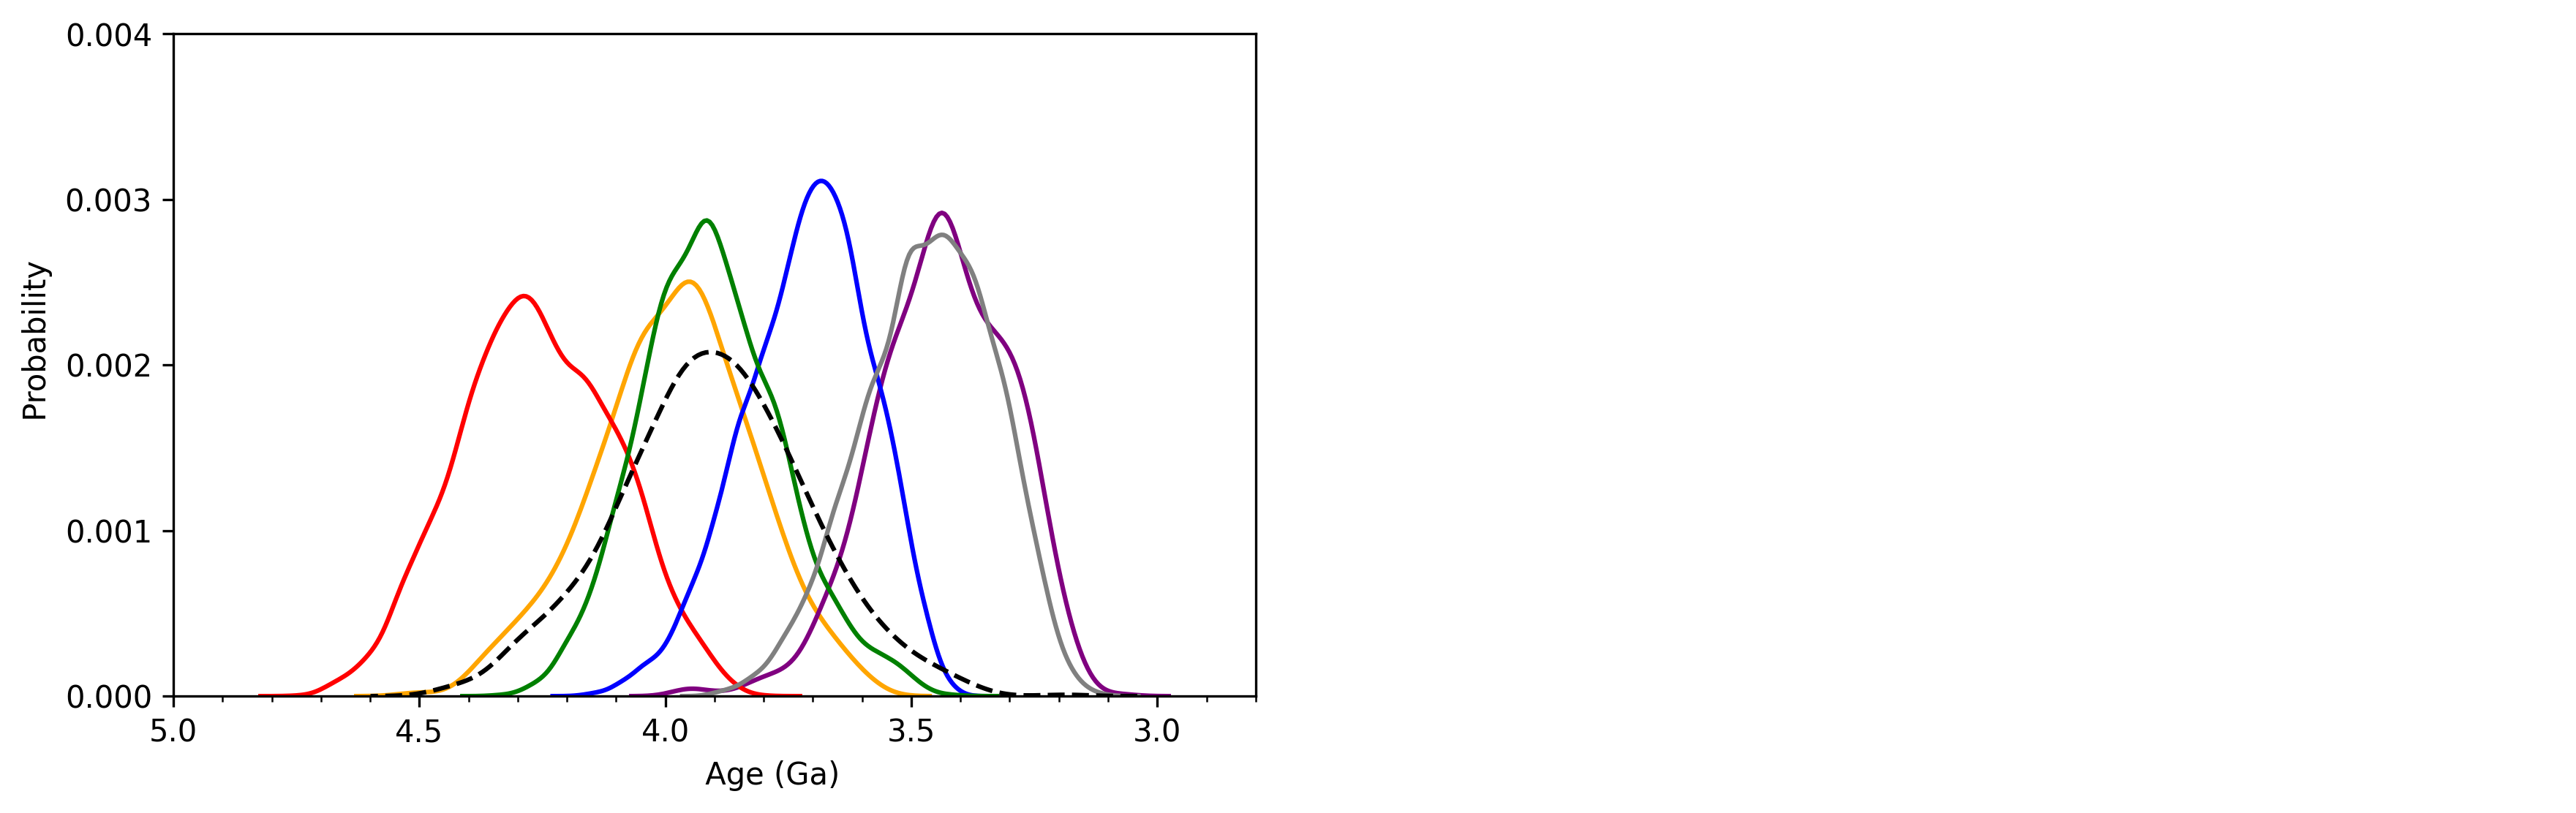

In [92]:
#Switch to KDE plot -- dist plot will die :-/
model_name='BE_all_'
run_name = 'Fig_posterior'

kwargs = {"linewidth" : "1.5"}
#kwargs = dict()
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=False,sharey=True,dpi=300)

axes[0].set_ylabel("     Probability")
axes[0].set_xlabel("             Age (Ga) ")
axes[0].set_ylim([0,0.0040001])
axes[0].yaxis.set_ticks(np.arange(0,0.0040001,0.001))

#x0values = ['','2.5','2.6','2.7','2.8','2.9','3','3.1','3.2','3.3','3.4','3.5','3.6']
x0values = ['','3.0','3.5','4.0','4.5','5.0']

#axes[0].legend()
axes[0]=sns.kdeplot(BE_ugam_bd_post_target_node_ages['170'][0],label="UGAM BD (Crown Bacteria)",ax=axes[0],color="orange", **kwargs)
axes[0]=sns.kdeplot(BE_ugam_nobd_post_target_node_ages['170'][0],label="UGAM NOBD (Crown Bacteria)",ax=axes[0],color="purple", **kwargs)
axes[0]=sns.kdeplot(BE_cir_bd_post_target_node_ages['170'][0],label="CIR BD (Crown Bacteria)",ax=axes[0],color="red", **kwargs)
axes[0]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['170'][0],label="CIR NOBD (Crown Bacteria)",ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(BE_ln_bd_post_target_node_ages['170'][0],label="LN BD (Crown Bacteria)",ax=axes[0],color="green", **kwargs)
axes[0]=sns.kdeplot(BE_ln_nobd_post_target_node_ages['170'][0],label="LN NOBD (Crown Bacteria)",ax=axes[0],color="grey", **kwargs)
axes[0]=sns.kdeplot(root_prior_values,label="Prior (Crown Bacteria)",ax=axes[0],color="black", **kwargs,linestyle='--')

axes[0].set_xlim([5000,2800])
axes[0].xaxis.set_minor_locator(MultipleLocator(100))
axes[0].xaxis.set_major_locator(MultipleLocator(500))
axes[0].set_xticklabels(x0values)

axes[1].axis('off')

#axes[0].legend()

#plt.show()
#plt.tight_layout()
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_170'+'.png',format='png')
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_170'+'.svg',format='svg')
print('Model BE w/ Fossil Calibrations')

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator


Model No Fossil w/ Only Root Prior


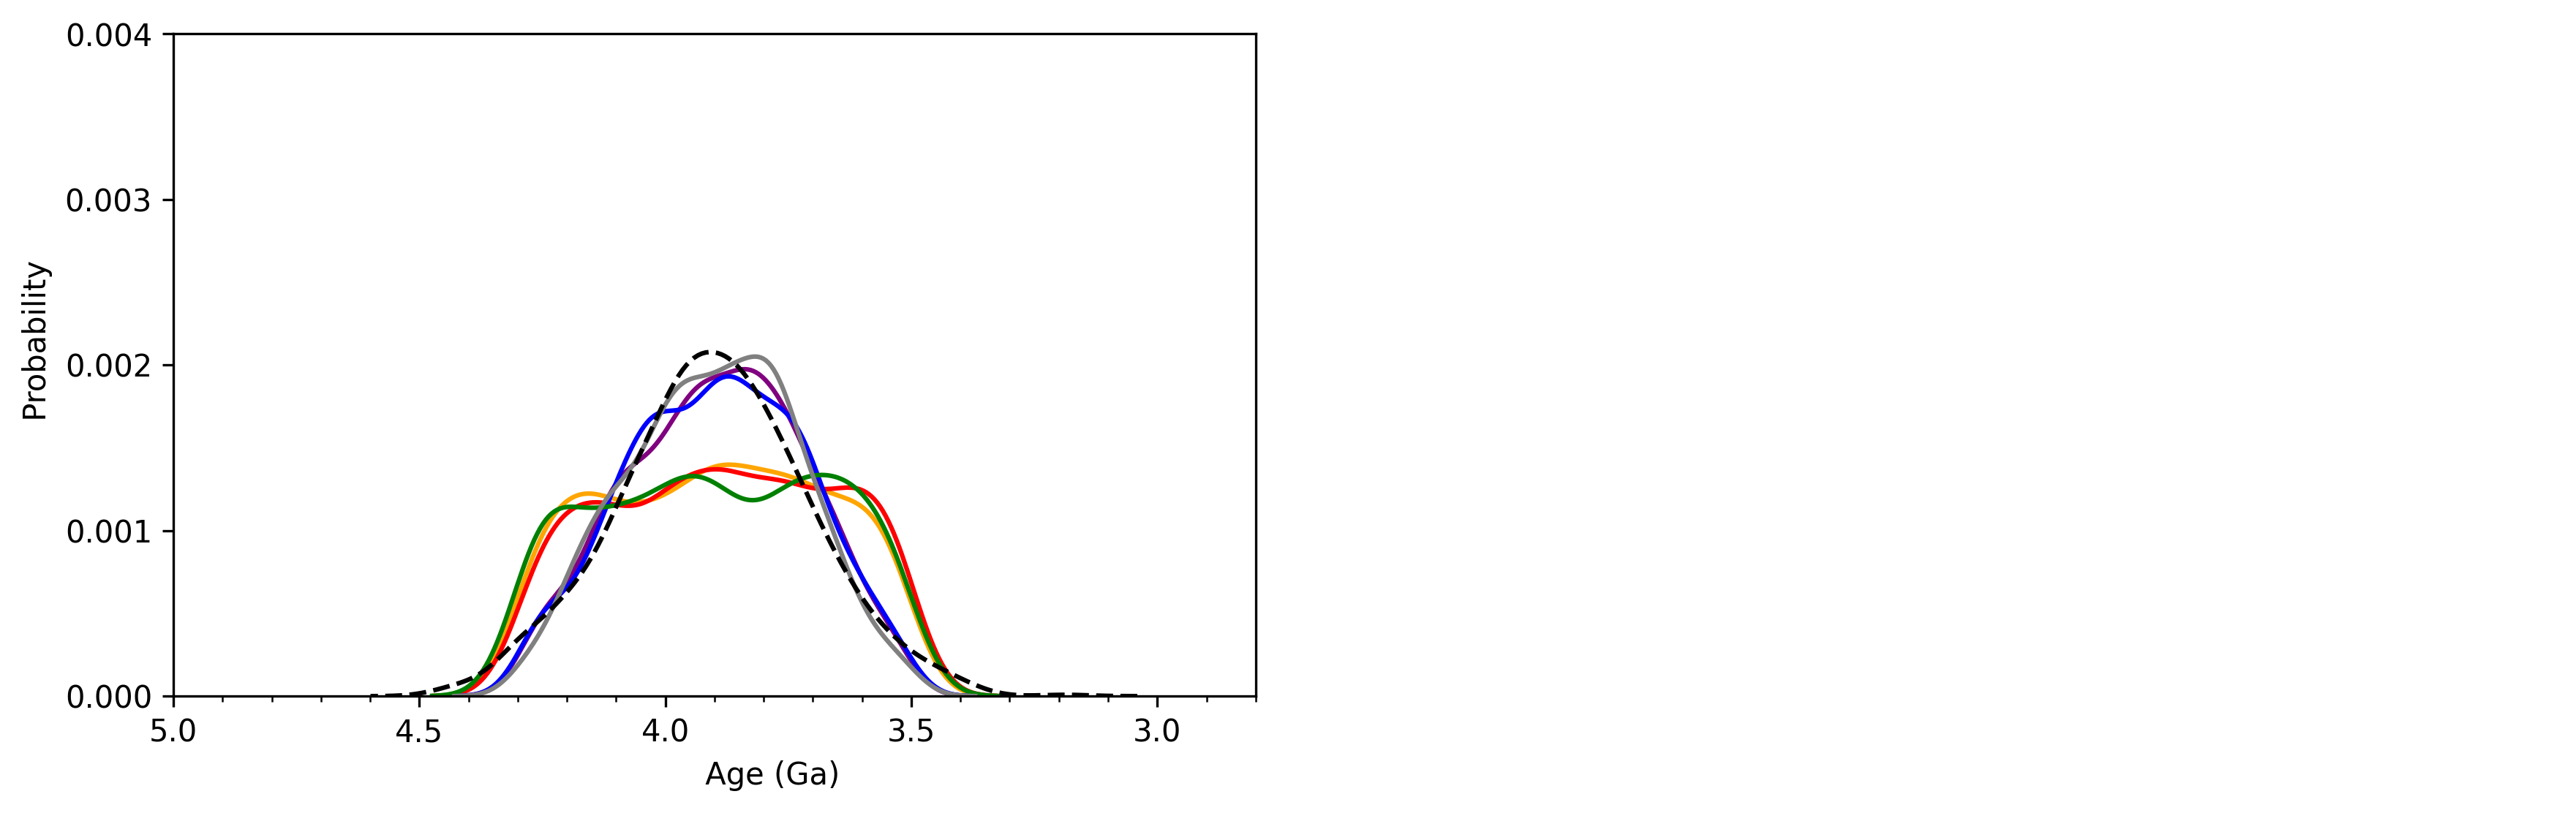

In [94]:
#Switch to KDE plot -- dist plot will die :-/
model_name='NF_all_'
run_name = 'Fig_posterior'

kwargs = {"linewidth" : "1.5"}
#kwargs = dict()
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=False,sharey=True,dpi=300)

axes[0].set_ylabel("     Probability")
axes[0].set_xlabel("             Age (Ga) ")
axes[0].set_ylim([0,0.0040001])
axes[0].yaxis.set_ticks(np.arange(0,0.0040001,0.001))

#x0values = ['','2.5','2.6','2.7','2.8','2.9','3','3.1','3.2','3.3','3.4','3.5','3.6']
x0values = ['','3.0','3.5','4.0','4.5','5.0']

#axes[0].legend()
axes[0]=sns.kdeplot(NF_ugam_bd_post_target_node_ages['170'][0],label="UGAM BD (Crown Bacteria)",ax=axes[0],color="orange", **kwargs)
axes[0]=sns.kdeplot(NF_ugam_nobd_post_target_node_ages['170'][0],label="UGAM NOBD (Crown Bacteria)",ax=axes[0],color="purple", **kwargs)
axes[0]=sns.kdeplot(NF_cir_bd_post_target_node_ages['170'][0],label="CIR BD (Crown Bacteria)",ax=axes[0],color="red", **kwargs)
axes[0]=sns.kdeplot(NF_cir_nobd_post_target_node_ages['170'][0],label="CIR NOBD (Crown Bacteria)",ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(NF_ln_bd_post_target_node_ages['170'][0],label="LN BD (Crown Bacteria)",ax=axes[0],color="green", **kwargs)
axes[0]=sns.kdeplot(NF_ln_nobd_post_target_node_ages['170'][0],label="LN NOBD (Crown Bacteria)",ax=axes[0],color="grey", **kwargs)
axes[0]=sns.kdeplot(root_prior_values,label="Prior (Crown Bacteria)",ax=axes[0],color="black", **kwargs,linestyle='--')

axes[0].set_xlim([5000,2800])
axes[0].xaxis.set_minor_locator(MultipleLocator(100))
axes[0].xaxis.set_major_locator(MultipleLocator(500))
axes[0].set_xticklabels(x0values)

axes[1].axis('off')

#axes[0].legend()

#plt.show()
#plt.tight_layout()
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_170'+'.png',format='png')
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_170'+'.svg',format='svg')
print('Model No Fossil w/ Only Root Prior')

In [111]:
#### New figure ####
### Model BE w/ HGT constrained ages for Root node.
##

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator


Model BE_cir_nobd w/ Fossil Calibrations


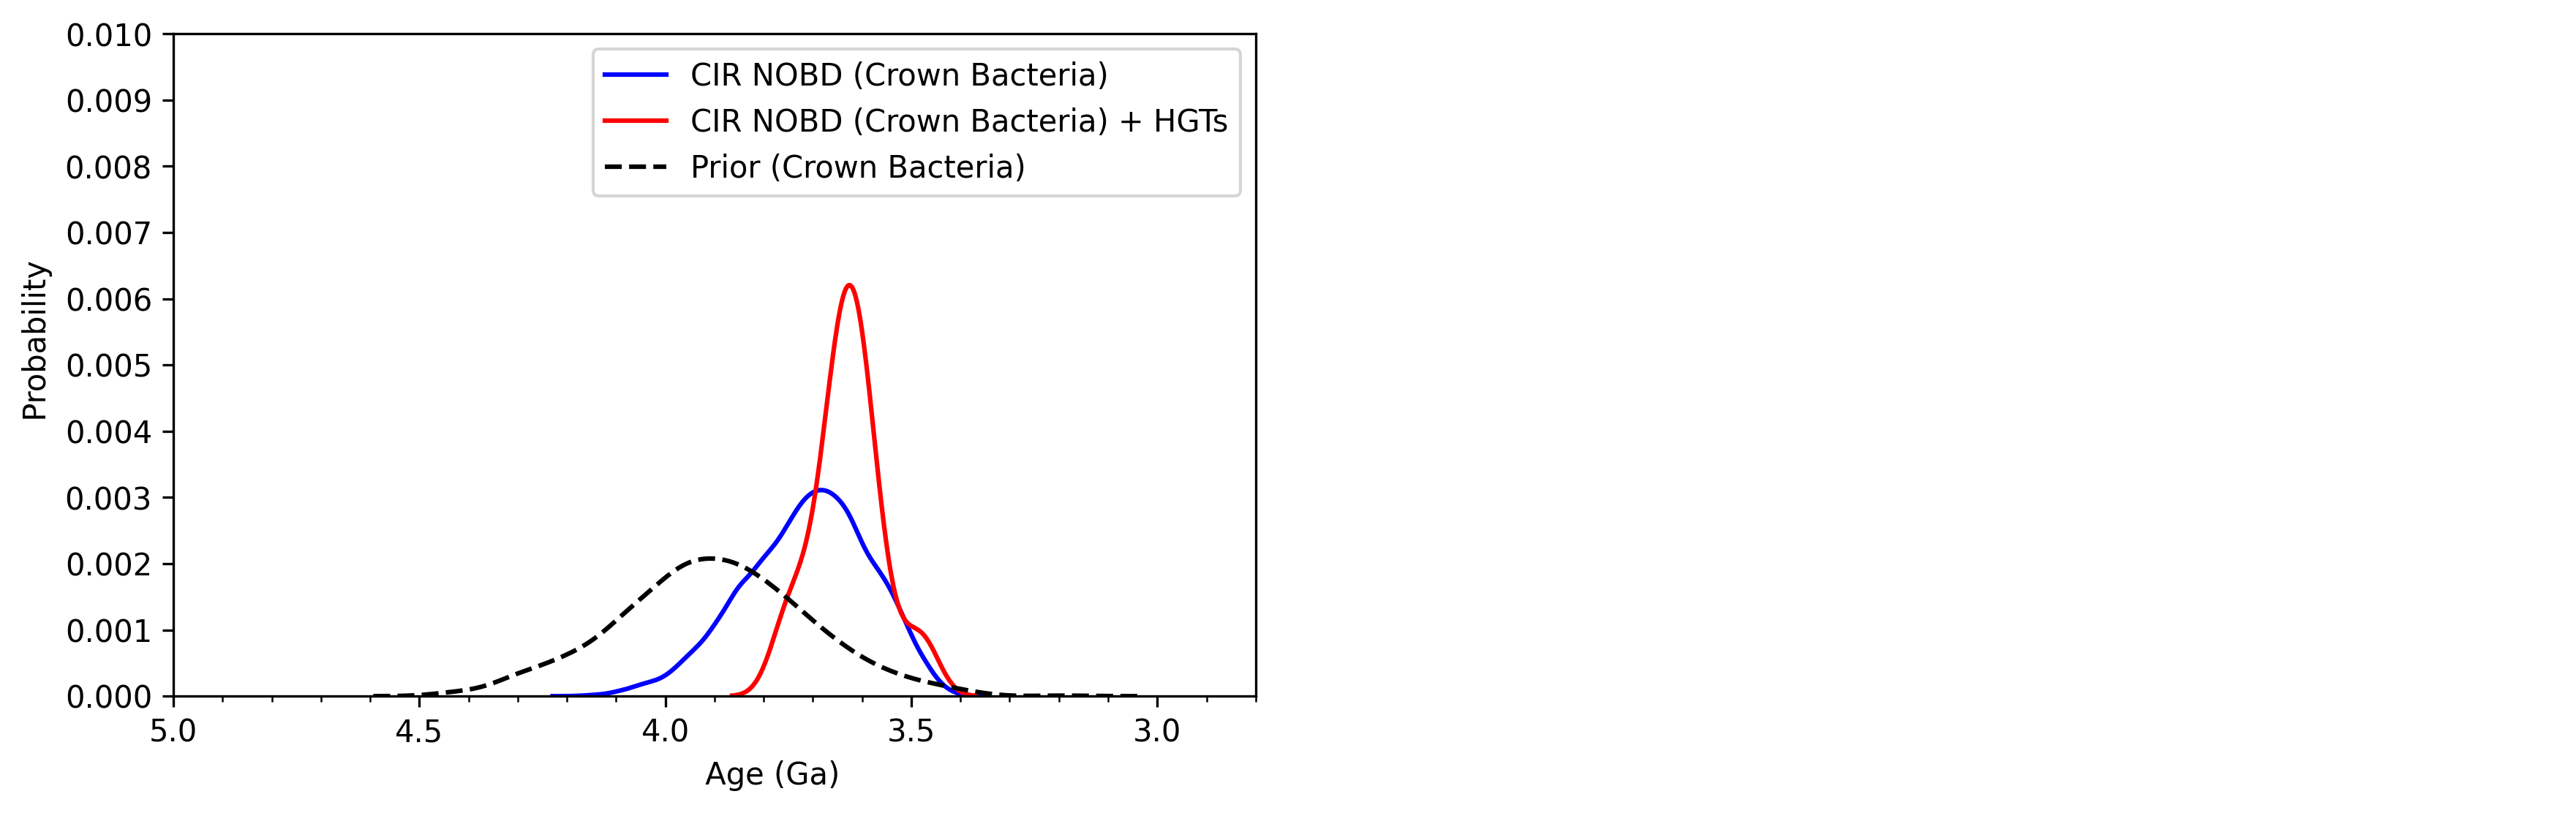

In [118]:
#Switch to KDE plot -- dist plot will die :-/
model_name='BE_cir_nobd_'
run_name = 'Fig_post_prior_hgt'

kwargs = {"linewidth" : "1.5"}
#kwargs = dict()
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=False,sharey=True,dpi=300)

axes[0].set_ylabel("     Probability")
axes[0].set_xlabel("             Age (Ga) ")
axes[0].set_ylim([0,0.010001])
axes[0].yaxis.set_ticks(np.arange(0,0.010001,0.001))

#x0values = ['','2.5','2.6','2.7','2.8','2.9','3','3.1','3.2','3.3','3.4','3.5','3.6']
x0values = ['','3.0','3.5','4.0','4.5','5.0']

#axes[0].legend()
axes[0]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['170'][0],label="CIR NOBD (Crown Bacteria)",ax=axes[0],color="blue", **kwargs)
#axes[0]=sns.kdeplot(BE_cir_nobd_prior_target_node_ages['170'][0],label="Prior CIR NOBD (Crown Bacteria)",ax=axes[0],color="blue", **kwargs,linestyle='--')

axes[0]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['170'][21],label="CIR NOBD (Crown Bacteria) + HGTs",ax=axes[0],color="red", **kwargs)

axes[0]=sns.kdeplot(root_prior_values,label="Prior (Crown Bacteria)",ax=axes[0],color="black", **kwargs,linestyle='--')

axes[0].set_xlim([5000,2800])
axes[0].xaxis.set_minor_locator(MultipleLocator(100))
axes[0].xaxis.set_major_locator(MultipleLocator(500))
axes[0].set_xticklabels(x0values)

axes[1].axis('off')

axes[0].legend()

#plt.show()
#plt.tight_layout()
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_170'+'.png',format='png')
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_170'+'.svg',format='svg')
print('Model BE_cir_nobd w/ Fossil Calibrations')

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator


Model BE_cir_nobd w/ Fossil Calibrations


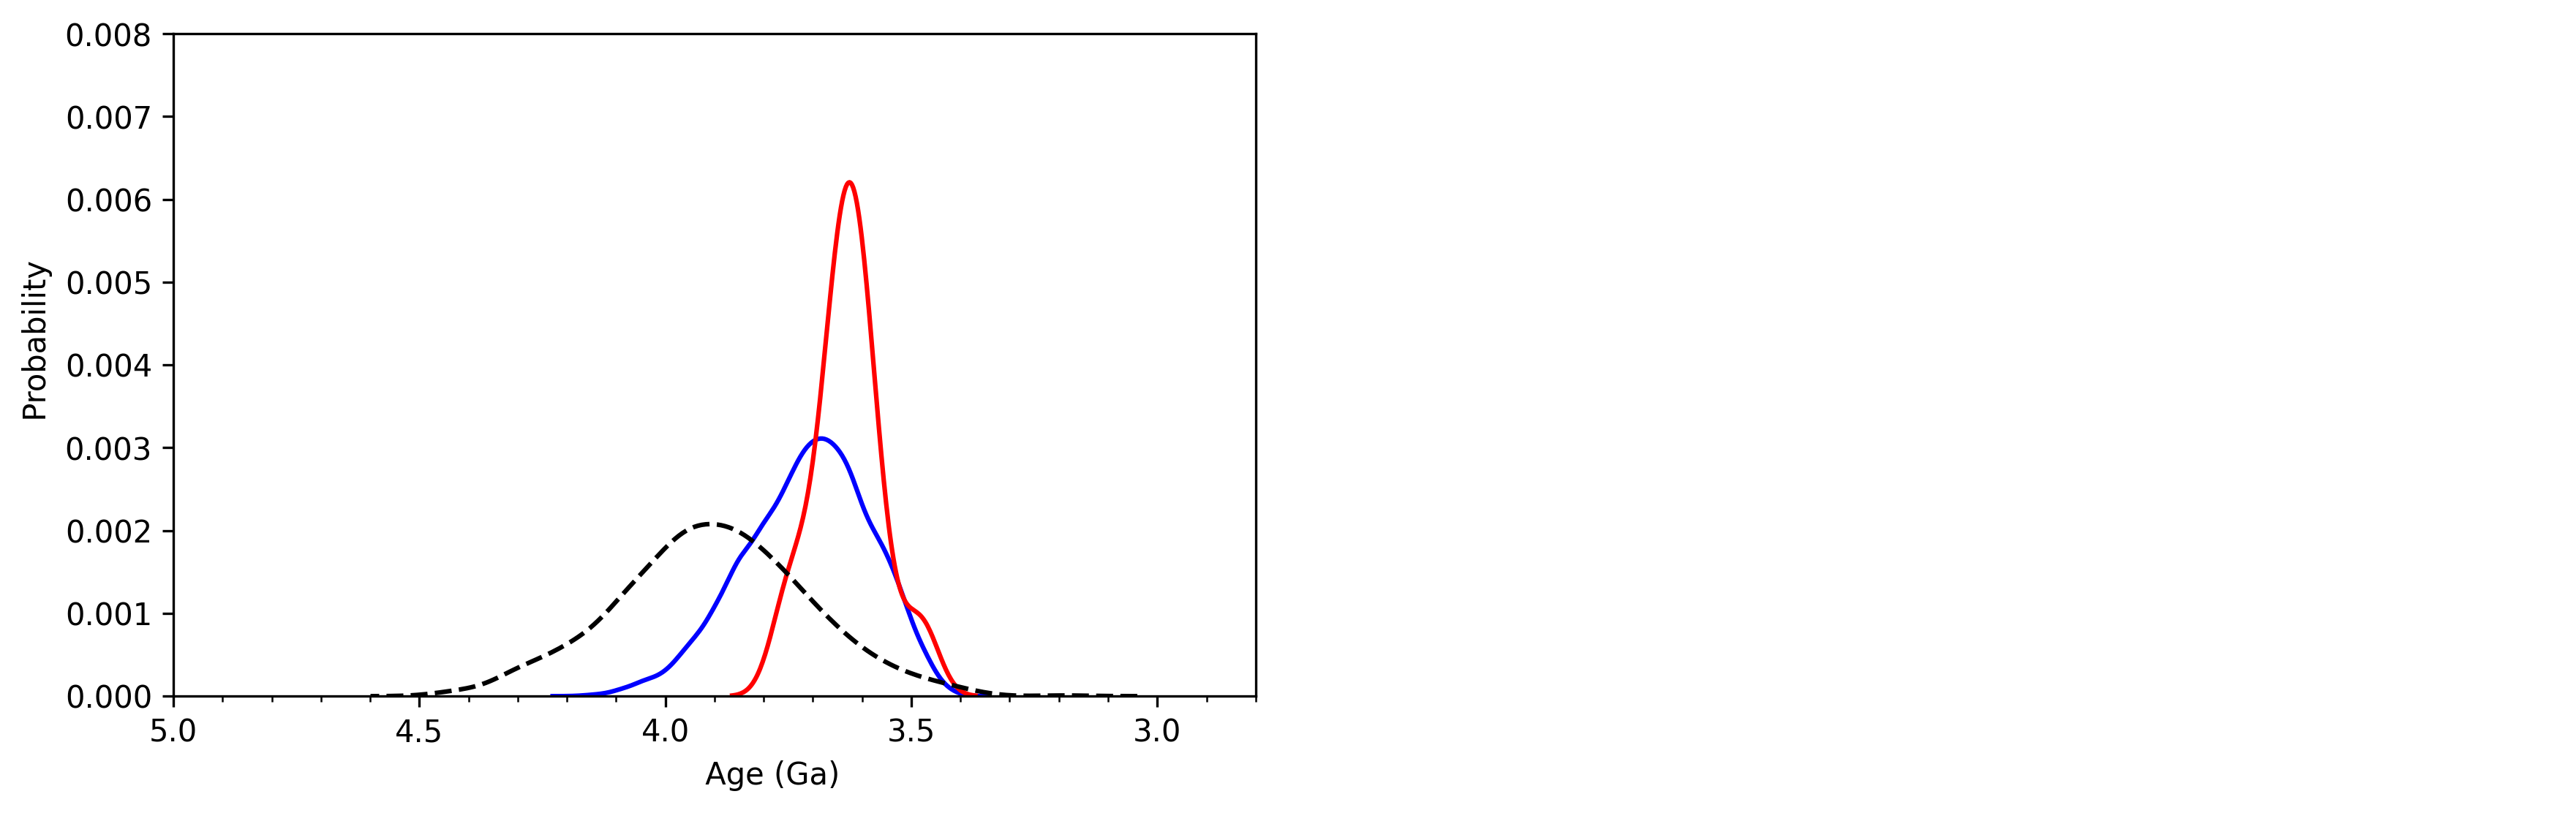

In [121]:
#Switch to KDE plot -- dist plot will die :-/
model_name='BE_cir_nobd'
run_name = 'Fig_post_prior_hgt'

kwargs = {"linewidth" : "1.5"}
#kwargs = dict()
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=False,sharey=True,dpi=300)

axes[0].set_ylabel("     Probability")
axes[0].set_xlabel("             Age (Ga) ")
axes[0].set_ylim([0,0.0080001])
axes[0].yaxis.set_ticks(np.arange(0,0.0080001,0.001))

#x0values = ['','2.5','2.6','2.7','2.8','2.9','3','3.1','3.2','3.3','3.4','3.5','3.6']
x0values = ['','3.0','3.5','4.0','4.5','5.0']

#axes[0].legend()
axes[0]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['170'][0],label="CIR NOBD (Crown Bacteria)",ax=axes[0],color="blue", **kwargs)
#axes[0]=sns.kdeplot(BE_cir_nobd_prior_target_node_ages['170'][0],label="Prior CIR NOBD (Crown Bacteria)",ax=axes[0],color="blue", **kwargs,linestyle='--')

axes[0]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['170'][21],label="CIR NOBD (Crown Bacteria) + HGTs",ax=axes[0],color="red", **kwargs)

axes[0]=sns.kdeplot(root_prior_values,label="Prior (Crown Bacteria)",ax=axes[0],color="black", **kwargs,linestyle='--')

axes[0].set_xlim([5000,2800])
axes[0].xaxis.set_minor_locator(MultipleLocator(100))
axes[0].xaxis.set_major_locator(MultipleLocator(500))
axes[0].set_xticklabels(x0values)

axes[1].axis('off')

#axes[0].legend()

#plt.show()
#plt.tight_layout()
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_170'+'.png',format='png')
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_170'+'.svg',format='svg')
print('Model BE_cir_nobd w/ Fossil Calibrations')

In [125]:
np.mean(BE_cir_nobd_post_target_node_ages['170'][21])

3628.3789285714292

In [126]:
np.median(BE_cir_nobd_post_target_node_ages['170'][21])

3628.6549999999997

In [128]:
np.mean(BE_cir_nobd_post_target_node_ages['170'][0])

3712.4058769999997

In [127]:
np.median(BE_cir_nobd_post_target_node_ages['170'][0])

3702.005

In [129]:
np.mean(root_prior_values)

3903.148116430752

In [130]:
np.median(root_prior_values)

3903.552178479109

In [40]:
#####

BE_ugam_bd_post
No. HGTs: 0
Trees: 1000
Node 177
Mean 3057.71687
Median 3053.58
Recent HPD 2778.44
Ancient HPD 3412.05


/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


HGT Selector set at: 15
Final Sample Size:  45


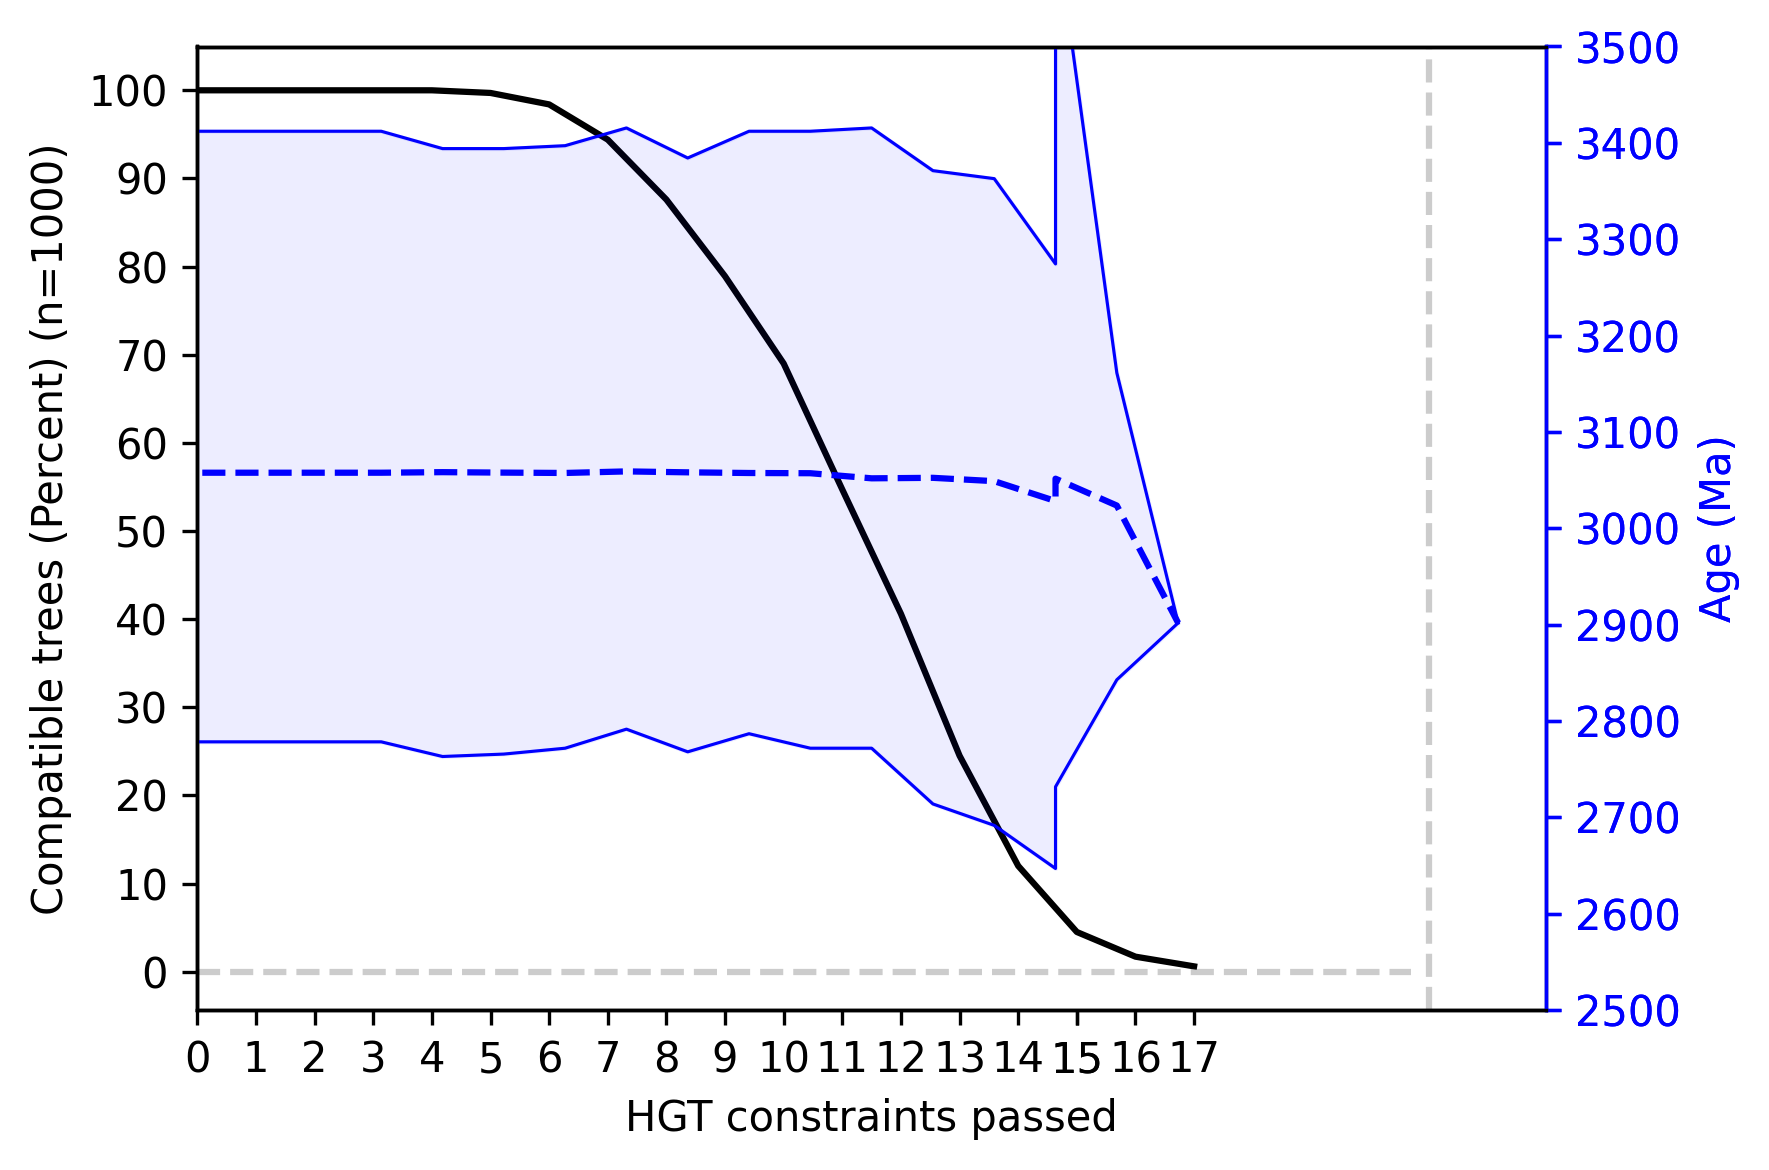

In [269]:
print('BE_ugam_bd_post')
getCurve('BE_ugam_bd_post',[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,15,16,17])
BE_ugam_bd_HGT = 15
print("HGT Selector set at:",BE_ugam_bd_HGT)
print("Final Sample Size: ",len(BE_ugam_bd_post_target_node_ages['177'][BE_ugam_bd_HGT]))
#Notes: Can't draw a curve with 1 tree at @18, Overall curve limit set at 17
#Picking @15 HGT cutoff for 45 trees, @16;N=17, @17;N=6 which are too small N

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator


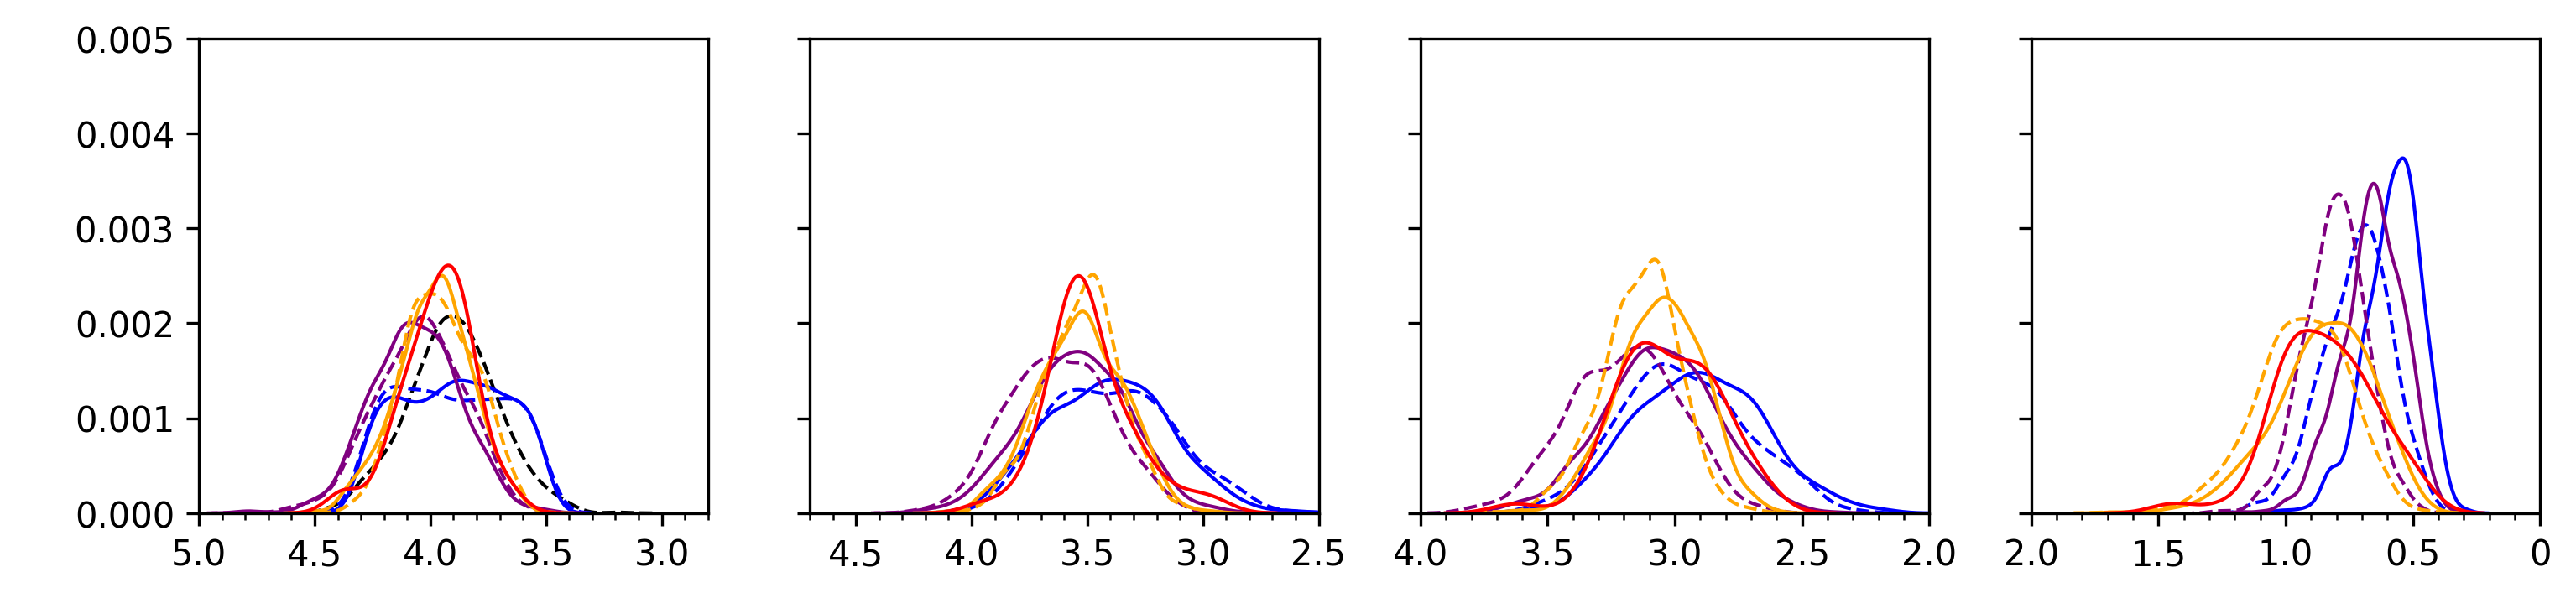

In [270]:
#Switch to KDE plot -- dist plot will die :-/
model_name='ugam_bd'
run_name = 'CFig_without1CX'

kwargs = {"linewidth" : "1"}
#kwargs = dict()
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(1, 4, figsize=(12, 2.5), sharex=False,sharey=True,dpi=300)
axes[0].set_ylabel(" ")

#axes[0].set_ylabel("     Probability")
#axes[0].set_xlabel("                                                                                                                                           Age (Ga) ")
axes[0].set_ylim([0,0.005001])
axes[0].yaxis.set_ticks(np.arange(0,0.005001,0.001))

x0values = ['','3.0','3.5','4.0','4.5','5.0']
#axes[0].legend()
axes[0]=sns.kdeplot(root_prior_values,label="Crown Bacteria Root (170)",ax=axes[0],color="black",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(NF_ugam_bd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="blue",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(NF_ugam_bd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(BH_ugam_bd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="purple",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(BH_ugam_bd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="purple", **kwargs)
axes[0]=sns.kdeplot(BE_ugam_bd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="orange",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(BE_ugam_bd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="orange", **kwargs)
axes[0]=sns.kdeplot(BE_ugam_bd_post_target_node_ages['170'][BE_ugam_bd_HGT],label="Crown Bacteria Root (170)",ax=axes[0],color="red", **kwargs)
axes[0].set_xlim([5000,2800])
axes[0].xaxis.set_minor_locator(MultipleLocator(100))
axes[0].xaxis.set_major_locator(MultipleLocator(500))
axes[0].set_xticklabels(x0values)

x1values = ['','2.5','3.0','3.5','4.0','4.5']
#axes[1].legend()
axes[1]=sns.kdeplot(NF_ugam_bd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="blue",linestyle='dashed', **kwargs)
axes[1]=sns.kdeplot(NF_ugam_bd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="blue", **kwargs)
axes[1]=sns.kdeplot(BH_ugam_bd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="purple", linestyle='dashed',**kwargs)
axes[1]=sns.kdeplot(BH_ugam_bd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="purple", **kwargs)
axes[1]=sns.kdeplot(BE_ugam_bd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="orange", linestyle='dashed',**kwargs)
axes[1]=sns.kdeplot(BE_ugam_bd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="orange", **kwargs)
axes[1]=sns.kdeplot(BE_ugam_bd_post_target_node_ages['172'][BE_ugam_bd_HGT],label="Stem Cyanobacteria (172)",ax=axes[1],color="red", **kwargs)
axes[1].set_xlim([4700,2500])
axes[1].xaxis.set_minor_locator(MultipleLocator(100))
axes[1].xaxis.set_major_locator(MultipleLocator(500))
axes[1].set_xticklabels(x1values)

x2values = ['','2.0','2.5','3.0','3.5','4.0']
#axes[2].legend()
axes[2]=sns.kdeplot(NF_ugam_bd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="blue",linestyle='dashed', **kwargs)
axes[2]=sns.kdeplot(NF_ugam_bd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="blue", **kwargs)
axes[2]=sns.kdeplot(BH_ugam_bd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="purple",linestyle='dashed', **kwargs)
axes[2]=sns.kdeplot(BH_ugam_bd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="purple", **kwargs)
axes[2]=sns.kdeplot(BE_ugam_bd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="orange",linestyle='dashed', **kwargs)
axes[2]=sns.kdeplot(BE_ugam_bd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="orange", **kwargs)
axes[2]=sns.kdeplot(BE_ugam_bd_post_target_node_ages['177'][BE_ugam_bd_HGT], label="Crown Cyanobacteria (177)",ax=axes[2],color="red", **kwargs)
axes[2].set_xlim([4000,2000])
axes[2].xaxis.set_minor_locator(MultipleLocator(100))
axes[2].xaxis.set_major_locator(MultipleLocator(500))
axes[2].set_xticklabels(x2values)

x3values = ['0','0.5','1.0','1.5','2.0']
##axes[3].legend()
axes[3]=sns.kdeplot(NF_ugam_bd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="blue",linestyle='dashed', **kwargs)
axes[3]=sns.kdeplot(NF_ugam_bd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="blue", **kwargs)
axes[3]=sns.kdeplot(BH_ugam_bd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="purple",linestyle='dashed', **kwargs)
axes[3]=sns.kdeplot(BH_ugam_bd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="purple", **kwargs)
axes[3]=sns.kdeplot(BE_ugam_bd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="orange",linestyle='dashed', **kwargs)
axes[3]=sns.kdeplot(BE_ugam_bd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="orange", **kwargs)
axes[3]=sns.kdeplot(BE_ugam_bd_post_target_node_ages['281'][BE_ugam_bd_HGT], label="Stem SynPro (281)",ax=axes[3],color="red", **kwargs)
axes[3].set_xlim([2000,0])
axes[3].xaxis.set_minor_locator(MultipleLocator(100))
#axes[3].xaxis.set_major_locator(MultipleLocator(250))
axes[3].set_xticklabels(x3values)

#plt.show()
#plt.tight_layout()
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_'+'.png',format='png')
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_'+'.svg',format='svg')

BE_ugam_nobd_post
No. HGTs: 0
Trees: 1000
Node 177
Mean 2860.3033200000004
Median 2850.8950000000004
Recent HPD 2629.38
Ancient HPD 3080.02
HGT Selector set at: 16
Final Sample Size:  62


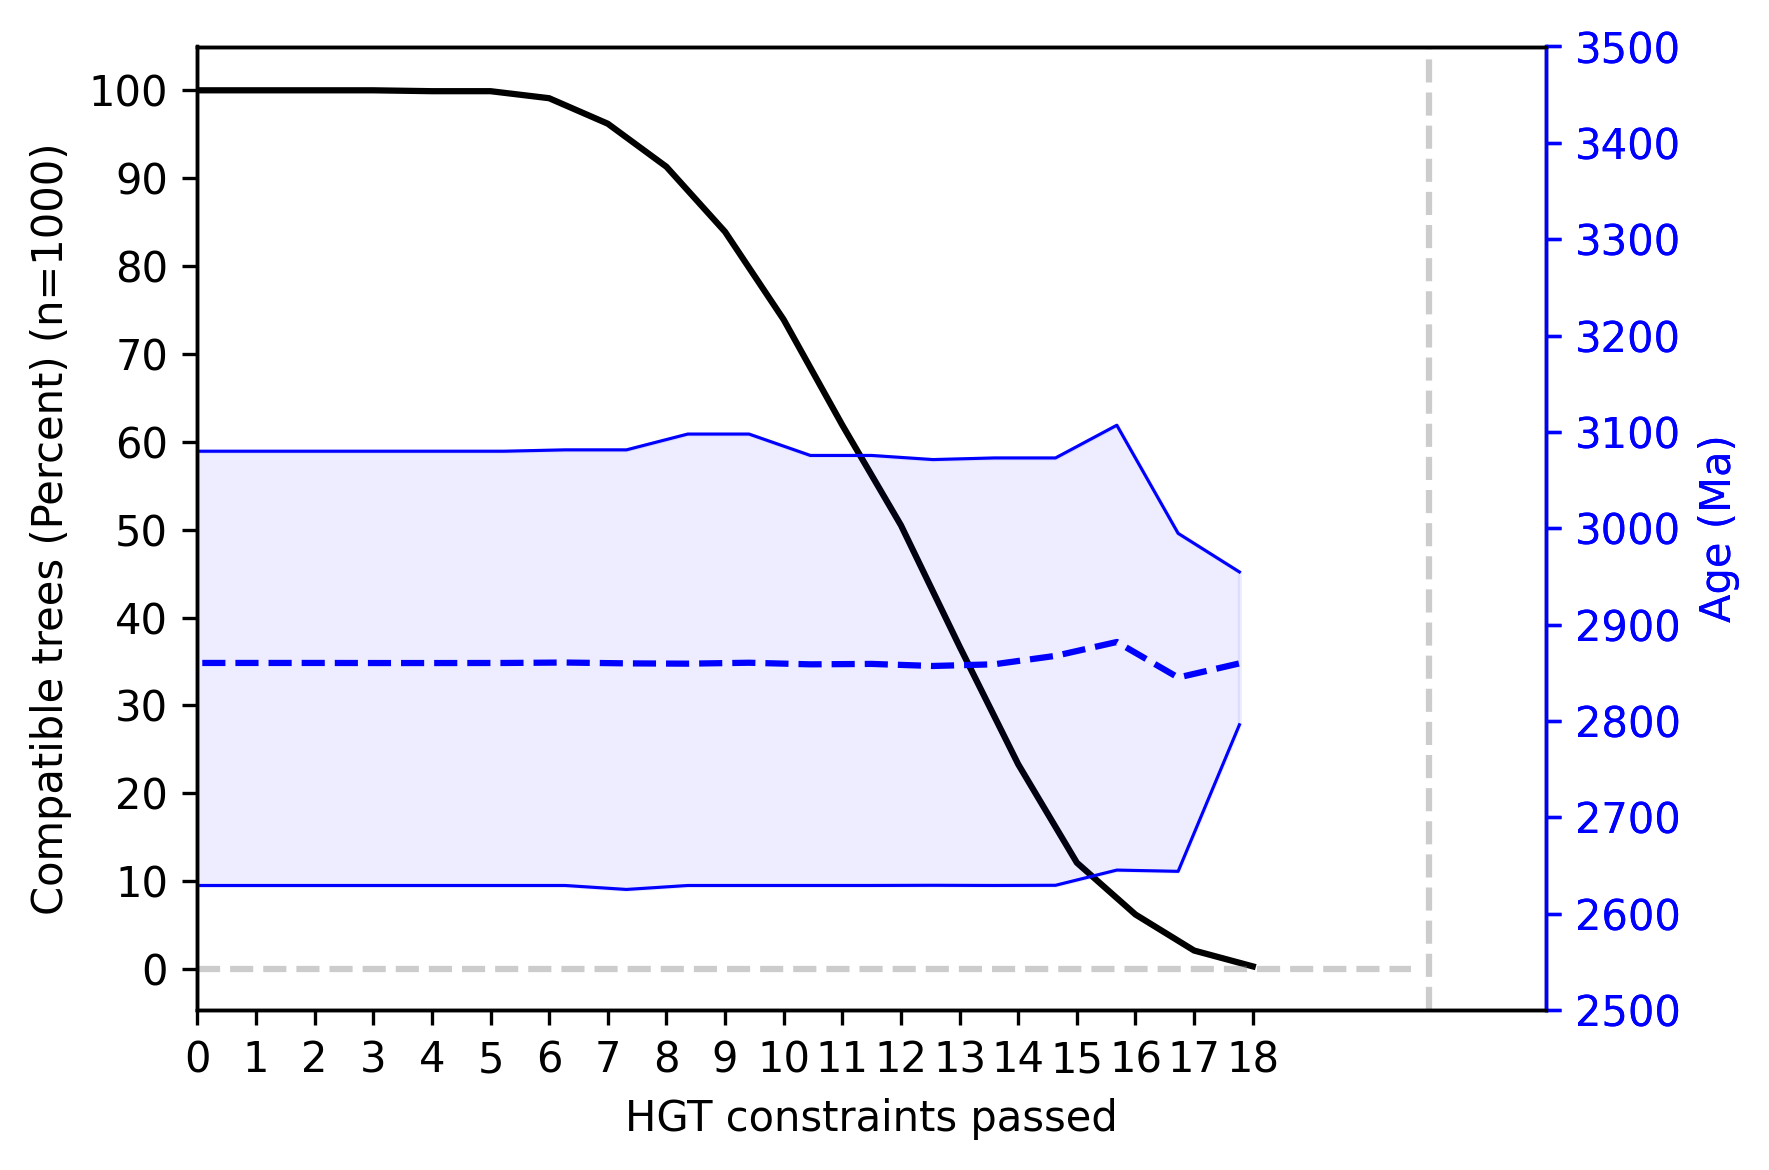

In [271]:
print('BE_ugam_nobd_post')
getCurve('BE_ugam_nobd_post',[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
BE_ugam_nobd_HGT = 16
print("HGT Selector set at:",BE_ugam_nobd_HGT)
print("Final Sample Size: ",len(BE_ugam_nobd_post_target_node_ages['177'][BE_ugam_nobd_HGT]))
#Notes: Curve set at 18
#picking @17 at 21 trees, @18 HGTs for 3 trees too small.

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator


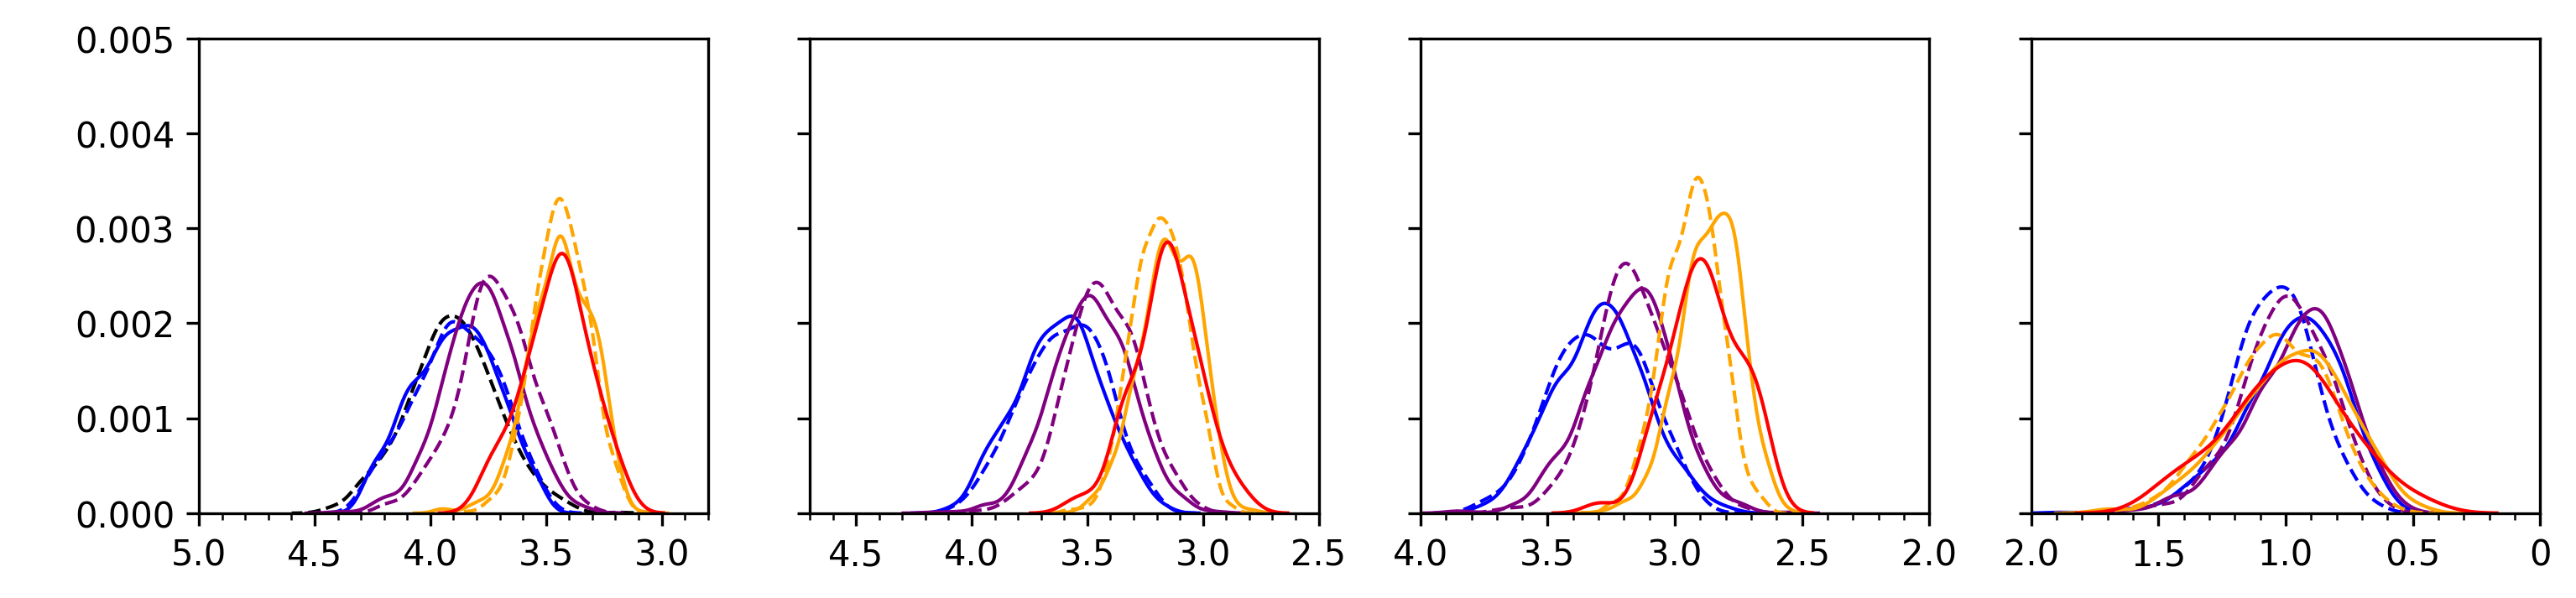

In [272]:
#Switch to KDE plot -- dist plot will die :-/
model_name='ugam_nobd'
run_name = 'CFig_without1CX'

kwargs = {"linewidth" : "1"}
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(1, 4, figsize=(12, 2.5), sharex=False,sharey=True,dpi=300)
axes[0].set_ylabel(" ")
#axes[0].set_ylabel("     Probability")
#axes[0].set_xlabel("                                                                                                                                           Age (Ma) ")
axes[0].set_ylim([0,0.005001])
axes[0].yaxis.set_ticks(np.arange(0,0.005001,0.001))

x0values = ['','3.0','3.5','4.0','4.5','5.0']
#axes[0].legend()
axes[0]=sns.kdeplot(root_prior_values,label="Crown Bacteria Root (170)",ax=axes[0],color="black",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(NF_ugam_nobd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="blue",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(NF_ugam_nobd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(BH_ugam_nobd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="purple",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(BH_ugam_nobd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="purple", **kwargs)
axes[0]=sns.kdeplot(BE_ugam_nobd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="orange",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(BE_ugam_nobd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="orange", **kwargs)
axes[0]=sns.kdeplot(BE_ugam_nobd_post_target_node_ages['170'][BE_ugam_nobd_HGT],label="Crown Bacteria Root (170)",ax=axes[0],color="red", **kwargs)
axes[0].set_xlim([5000,2800])
axes[0].xaxis.set_minor_locator(MultipleLocator(100))
axes[0].xaxis.set_major_locator(MultipleLocator(500))
axes[0].set_xticklabels(x0values)

x1values = ['','2.5','3.0','3.5','4.0','4.5']
#axes[1].legend()
axes[1]=sns.kdeplot(NF_ugam_nobd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="blue",linestyle='dashed', **kwargs)
axes[1]=sns.kdeplot(NF_ugam_nobd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="blue", **kwargs)
axes[1]=sns.kdeplot(BH_ugam_nobd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="purple", linestyle='dashed',**kwargs)
axes[1]=sns.kdeplot(BH_ugam_nobd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="purple", **kwargs)
axes[1]=sns.kdeplot(BE_ugam_nobd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="orange", linestyle='dashed',**kwargs)
axes[1]=sns.kdeplot(BE_ugam_nobd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="orange", **kwargs)
axes[1]=sns.kdeplot(BE_ugam_nobd_post_target_node_ages['172'][BE_ugam_nobd_HGT],label="Stem Cyanobacteria (172)",ax=axes[1],color="red", **kwargs)
axes[1].set_xlim([4700,2500])
axes[1].xaxis.set_minor_locator(MultipleLocator(100))
axes[1].xaxis.set_major_locator(MultipleLocator(500))
axes[1].set_xticklabels(x1values)

x2values = ['','2.0','2.5','3.0','3.5','4.0']
#axes[2].legend()
axes[2]=sns.kdeplot(NF_ugam_nobd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="blue",linestyle='dashed', **kwargs)
axes[2]=sns.kdeplot(NF_ugam_nobd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="blue", **kwargs)
axes[2]=sns.kdeplot(BH_ugam_nobd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="purple",linestyle='dashed', **kwargs)
axes[2]=sns.kdeplot(BH_ugam_nobd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="purple", **kwargs)
axes[2]=sns.kdeplot(BE_ugam_nobd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="orange",linestyle='dashed', **kwargs)
axes[2]=sns.kdeplot(BE_ugam_nobd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="orange", **kwargs)
axes[2]=sns.kdeplot(BE_ugam_nobd_post_target_node_ages['177'][BE_ugam_nobd_HGT], label="Crown Cyanobacteria (177)",ax=axes[2],color="red", **kwargs)
axes[2].set_xlim([4000,2000])
axes[2].xaxis.set_minor_locator(MultipleLocator(100))
axes[2].xaxis.set_major_locator(MultipleLocator(500))
axes[2].set_xticklabels(x2values)

x3values = ['0','0.5','1.0','1.5','2.0']
#axes[3].legend()
axes[3]=sns.kdeplot(NF_ugam_nobd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="blue",linestyle='dashed', **kwargs)
axes[3]=sns.kdeplot(NF_ugam_nobd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="blue", **kwargs)
axes[3]=sns.kdeplot(BH_ugam_nobd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="purple",linestyle='dashed', **kwargs)
axes[3]=sns.kdeplot(BH_ugam_nobd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="purple", **kwargs)
axes[3]=sns.kdeplot(BE_ugam_nobd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="orange",linestyle='dashed', **kwargs)
axes[3]=sns.kdeplot(BE_ugam_nobd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="orange", **kwargs)
axes[3]=sns.kdeplot(BE_ugam_nobd_post_target_node_ages['281'][BE_ugam_nobd_HGT], label="Stem SynPro (281)",ax=axes[3],color="red", **kwargs)
axes[3].set_xlim([2000,0])
axes[3].xaxis.set_minor_locator(MultipleLocator(100))
#axes[3].xaxis.set_major_locator(MultipleLocator(250))
axes[3].set_xticklabels(x3values)

#plt.show()
#plt.tight_layout()
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_'+'.png',format='png')
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_'+'.svg',format='svg')

BE_cir_bd_post
No. HGTs: 0
Trees: 10000
Node 177
Mean 3211.418918
Median 3206.815
Recent HPD 2998.09
Ancient HPD 3417.27
HGT Selector set at: 19
Final Sample Size:  21


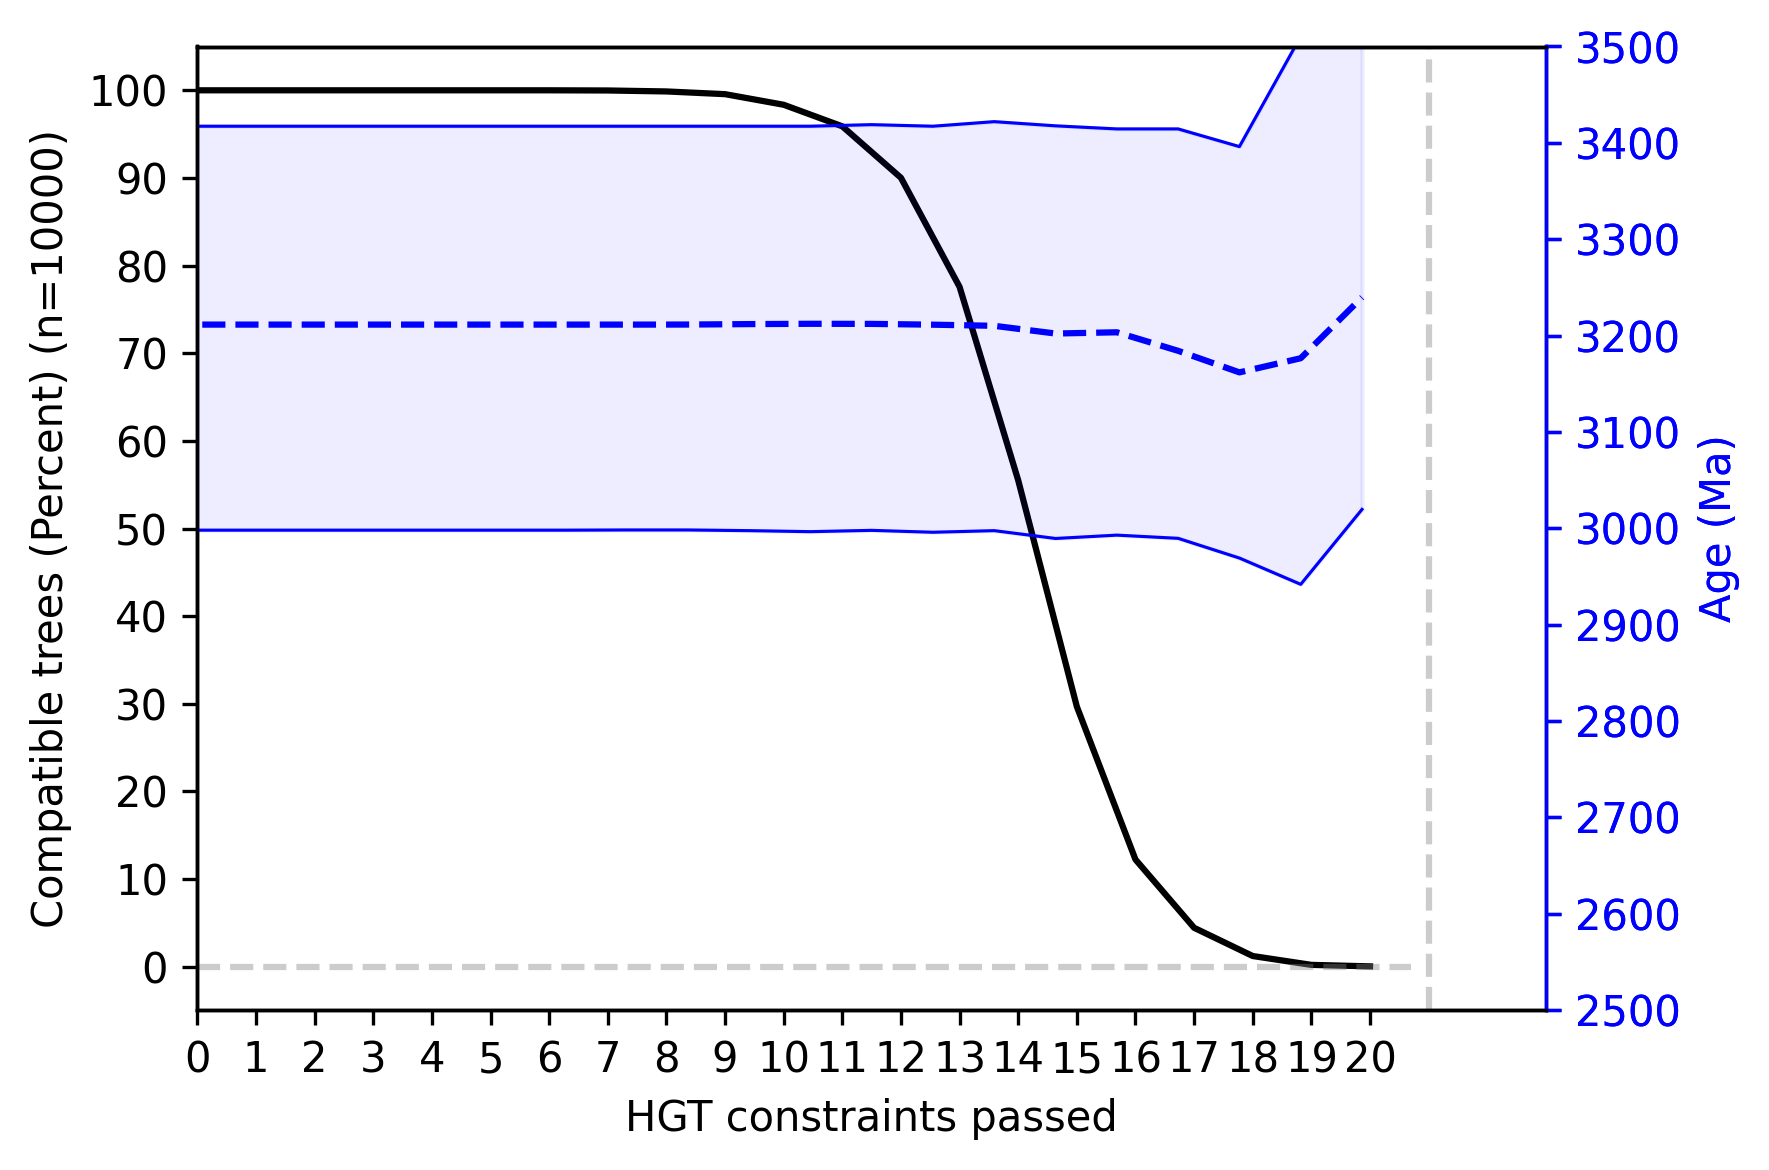

In [273]:
print('BE_cir_bd_post')
getCurve('BE_cir_bd_post',[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
BE_cir_bd_HGT = 19
print("HGT Selector set at:",BE_cir_bd_HGT)
print("Final Sample Size: ",len(BE_cir_bd_post_target_node_ages['177'][BE_cir_bd_HGT]))
#Notes: Curve set at 20, picking @19 for 21 trees, @20 HGTs has N=4 trees, which are too few.

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator


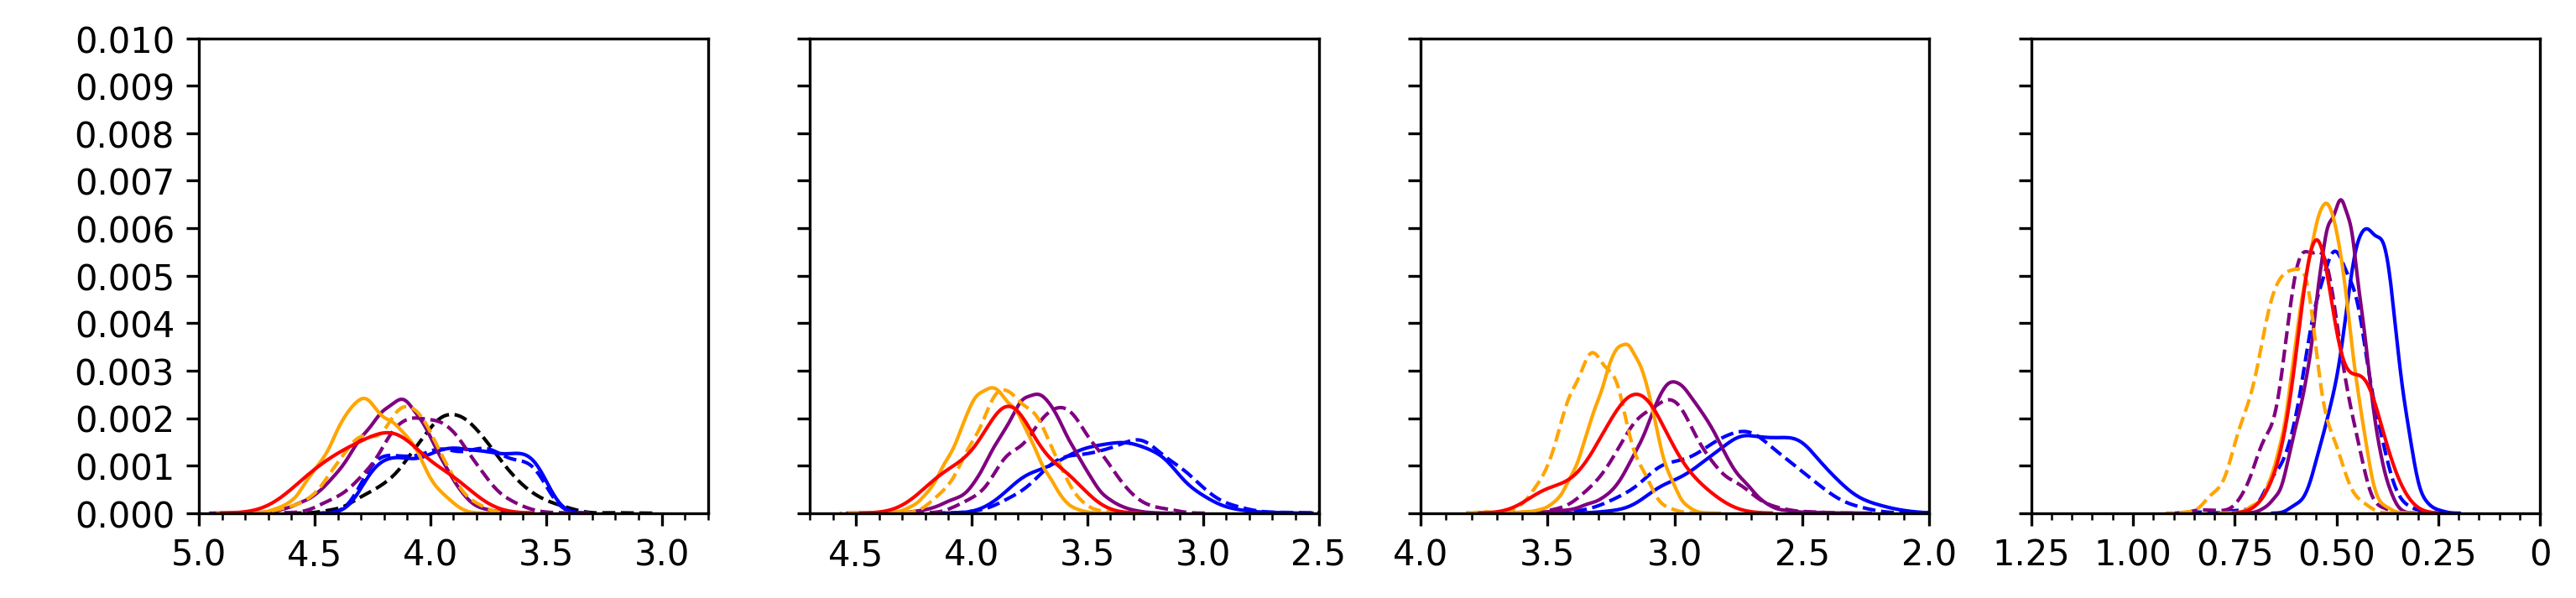

In [274]:
#Switch to KDE plot -- dist plot will die :-/
model_name='cir_bd'
run_name = 'CFig_without1CX'

kwargs = {"linewidth" : "1"}
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(1, 4, figsize=(12, 2.5), sharex=False,sharey=True,dpi=300)
axes[0].set_ylabel(" ")
#axes[0].set_ylabel("     Probability")
#axes[0].set_xlabel("                                                                                                                                           Age (Ga) ")
#axes[0].set_ylim([0,0.009001])
#axes[0].yaxis.set_ticks(np.arange(0,0.009001,0.001))
axes[0].set_ylim([0,0.010001])
axes[0].yaxis.set_ticks(np.arange(0,0.010001,0.001))

x0values = ['','3.0','3.5','4.0','4.5','5.0']
#axes[0].legend()
axes[0]=sns.kdeplot(root_prior_values,label="Crown Bacteria Root (170)",ax=axes[0],color="black",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(NF_cir_bd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="blue",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(NF_cir_bd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(BH_cir_bd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="purple",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(BH_cir_bd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="purple", **kwargs)
axes[0]=sns.kdeplot(BE_cir_bd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="orange",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(BE_cir_bd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="orange", **kwargs)
axes[0]=sns.kdeplot(BE_cir_bd_post_target_node_ages['170'][BE_cir_bd_HGT],label="Crown Bacteria Root (170)",ax=axes[0],color="red", **kwargs)
axes[0].set_xlim([5000,2800])
axes[0].xaxis.set_minor_locator(MultipleLocator(100))
axes[0].xaxis.set_major_locator(MultipleLocator(500))
axes[0].set_xticklabels(x0values)

x1values = ['','2.5','3.0','3.5','4.0','4.5']
#axes[1].legend()
axes[1]=sns.kdeplot(NF_cir_bd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="blue",linestyle='dashed', **kwargs)
axes[1]=sns.kdeplot(NF_cir_bd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="blue", **kwargs)
axes[1]=sns.kdeplot(BH_cir_bd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="purple", linestyle='dashed',**kwargs)
axes[1]=sns.kdeplot(BH_cir_bd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="purple", **kwargs)
axes[1]=sns.kdeplot(BE_cir_bd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="orange", linestyle='dashed',**kwargs)
axes[1]=sns.kdeplot(BE_cir_bd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="orange", **kwargs)
axes[1]=sns.kdeplot(BE_cir_bd_post_target_node_ages['172'][BE_cir_bd_HGT],label="Stem Cyanobacteria (172)",ax=axes[1],color="red", **kwargs)
axes[1].set_xlim([4700,2500])
axes[1].xaxis.set_minor_locator(MultipleLocator(100))
axes[1].xaxis.set_major_locator(MultipleLocator(500))
axes[1].set_xticklabels(x1values)

x2values = ['','2.0','2.5','3.0','3.5','4.0']
#axes[2].legend()
axes[2]=sns.kdeplot(NF_cir_bd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="blue",linestyle='dashed', **kwargs)
axes[2]=sns.kdeplot(NF_cir_bd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="blue", **kwargs)
axes[2]=sns.kdeplot(BH_cir_bd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="purple",linestyle='dashed', **kwargs)
axes[2]=sns.kdeplot(BH_cir_bd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="purple", **kwargs)
axes[2]=sns.kdeplot(BE_cir_bd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="orange",linestyle='dashed', **kwargs)
axes[2]=sns.kdeplot(BE_cir_bd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="orange", **kwargs)
axes[2]=sns.kdeplot(BE_cir_bd_post_target_node_ages['177'][BE_cir_bd_HGT], label="Crown Cyanobacteria (177)",ax=axes[2],color="red", **kwargs)
axes[2].set_xlim([4000,2000])
axes[2].xaxis.set_minor_locator(MultipleLocator(100))
axes[2].xaxis.set_major_locator(MultipleLocator(500))
axes[2].set_xticklabels(x2values)

x3values = ['','0','0.25','0.50','0.75','1.00','1.25']
#axes[3].legend()
axes[3]=sns.kdeplot(NF_cir_bd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="blue",linestyle='dashed', **kwargs)
axes[3]=sns.kdeplot(NF_cir_bd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="blue", **kwargs)
axes[3]=sns.kdeplot(BH_cir_bd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="purple",linestyle='dashed', **kwargs)
axes[3]=sns.kdeplot(BH_cir_bd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="purple", **kwargs)
axes[3]=sns.kdeplot(BE_cir_bd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="orange",linestyle='dashed', **kwargs)
axes[3]=sns.kdeplot(BE_cir_bd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="orange", **kwargs)
axes[3]=sns.kdeplot(BE_cir_bd_post_target_node_ages['281'][BE_cir_bd_HGT], label="Stem SynPro (281)",ax=axes[3],color="red", **kwargs)
axes[3].set_xlim([1250,0])
axes[3].xaxis.set_minor_locator(MultipleLocator(50))
axes[3].xaxis.set_major_locator(MultipleLocator(250))
axes[3].set_xticklabels(x3values)

#plt.show()
#plt.tight_layout()
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_'+'.png',format='png')
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_'+'.svg',format='svg')

BE_cir_nobd_post
No. HGTs: 0
Trees: 10000
Node 177
Mean 2980.256469
Median 2974.815
Recent HPD 2811.17
Ancient HPD 3161.65
HGT Selector set at: 21
Final Sample Size:  28


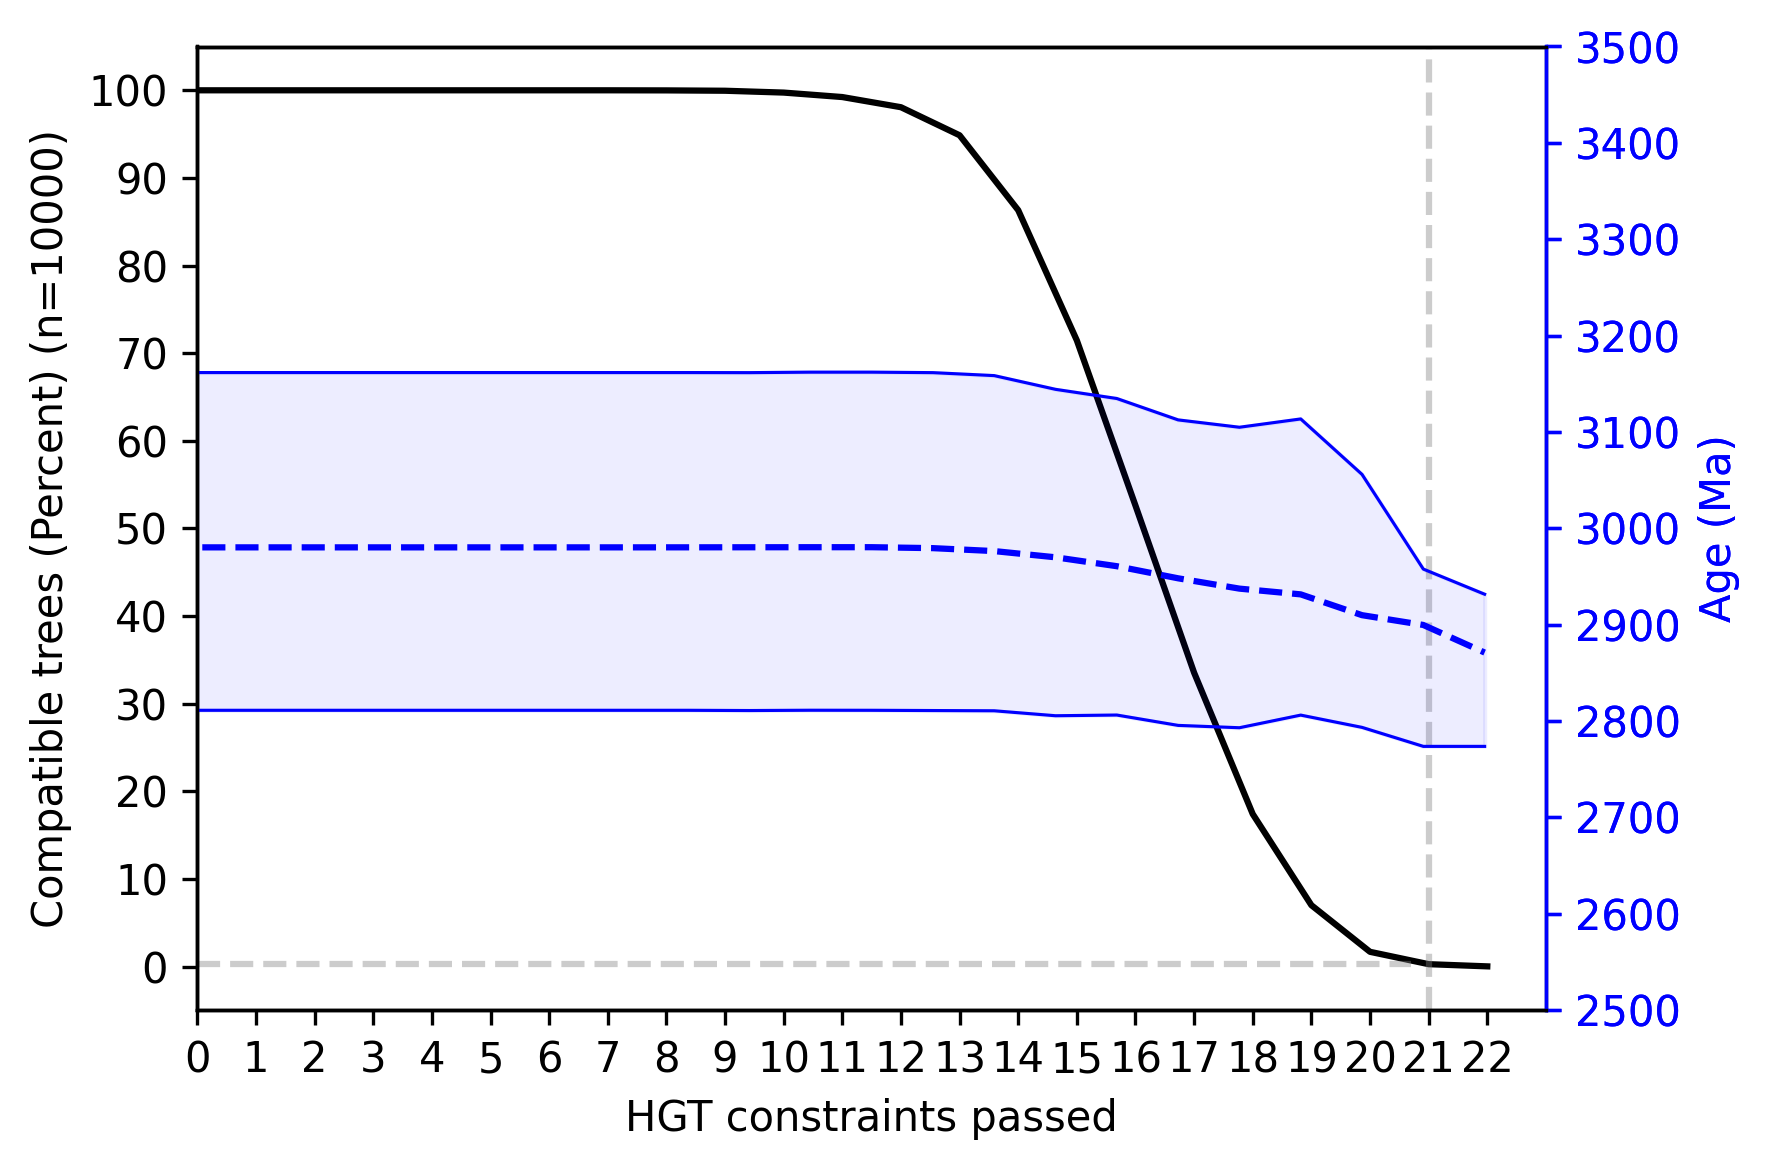

In [275]:
print('BE_cir_nobd_post')
getCurve('BE_cir_nobd_post',[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]) #23 deleted
BE_cir_nobd_HGT = 21
print("HGT Selector set at:",BE_cir_nobd_HGT)
print("Final Sample Size: ",len(BE_cir_nobd_post_target_node_ages['177'][BE_cir_nobd_HGT]))
#Curve set at 22. @23 0 compatible, 24th HGT had zero overall compatibility
#Notes: 21 HGTs for 28 trees! @22;N=3 trees too small. 23,24 cutoffs not possible

In [276]:
print("Final Sample: ",np.mean(BE_cir_nobd_post_target_node_ages['177'][BE_cir_nobd_HGT]))

Final Sample:  2899.715714285714


/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator


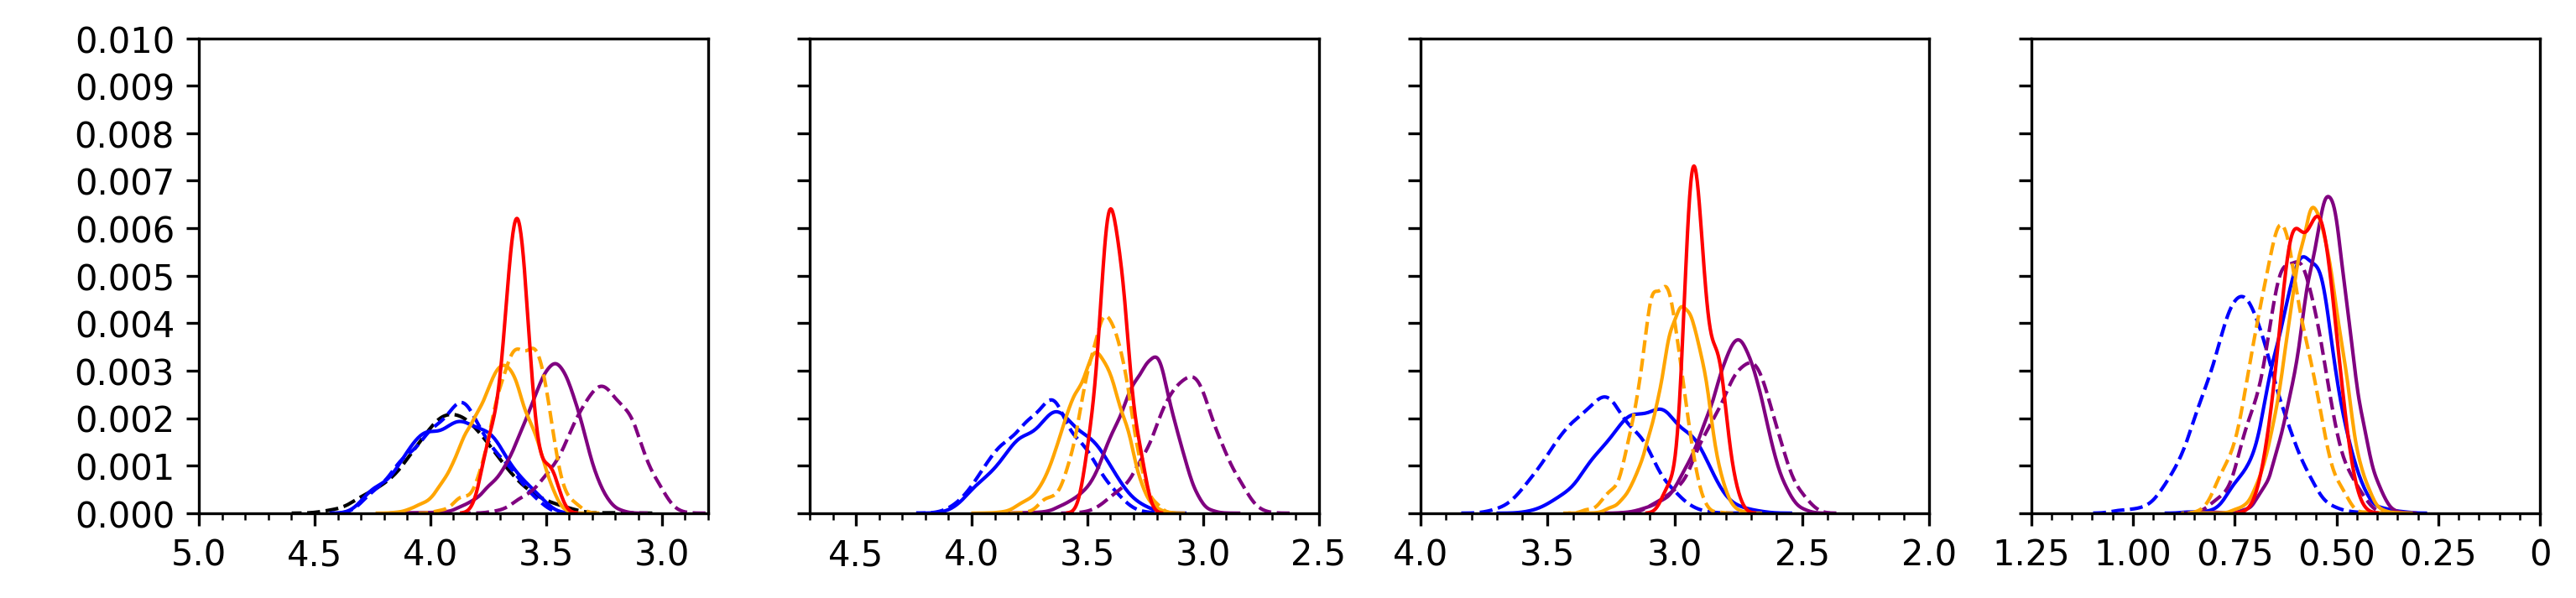

In [277]:
#Switch to KDE plot -- dist plot will die :-/
model_name='cir_nobd'
run_name = 'CFig_without1CX'

kwargs = {"linewidth" : "1"}
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(1, 4, figsize=(12, 2.5), sharex=False,sharey=True,dpi=300)

axes[0].set_ylabel(" ")
#axes[0].set_ylabel("     Probability")
#axes[0].set_xlabel("                                                                                                                                           Age (Ma) ")
axes[0].set_ylim([0,0.010001])
axes[0].yaxis.set_ticks(np.arange(0,0.010001,0.001))

x0values = ['','3.0','3.5','4.0','4.5','5.0']
#axes[0].legend()
axes[0]=sns.kdeplot(root_prior_values,label="Crown Bacteria Root (170)",ax=axes[0],color="black",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(NF_cir_nobd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="blue",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(NF_cir_nobd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(BH_cir_nobd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="purple",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(BH_cir_nobd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="purple", **kwargs)
axes[0]=sns.kdeplot(BE_cir_nobd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="orange",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="orange", **kwargs)
axes[0]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['170'][BE_cir_nobd_HGT],label="Crown Bacteria Root (170)",ax=axes[0],color="red", **kwargs)
axes[0].set_xlim([5000,2800])
axes[0].xaxis.set_minor_locator(MultipleLocator(100))
axes[0].xaxis.set_major_locator(MultipleLocator(500))
axes[0].set_xticklabels(x0values)

x1values = ['','2.5','3.0','3.5','4.0','4.5']
#axes[1].legend()
axes[1]=sns.kdeplot(NF_cir_nobd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="blue",linestyle='dashed', **kwargs)
axes[1]=sns.kdeplot(NF_cir_nobd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="blue", **kwargs)
axes[1]=sns.kdeplot(BH_cir_nobd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="purple", linestyle='dashed',**kwargs)
axes[1]=sns.kdeplot(BH_cir_nobd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="purple", **kwargs)
axes[1]=sns.kdeplot(BE_cir_nobd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="orange", linestyle='dashed',**kwargs)
axes[1]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="orange", **kwargs)
axes[1]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['172'][BE_cir_nobd_HGT],label="Stem Cyanobacteria (172)",ax=axes[1],color="red", **kwargs)
axes[1].set_xlim([4700,2500])
axes[1].xaxis.set_minor_locator(MultipleLocator(100))
axes[1].xaxis.set_major_locator(MultipleLocator(500))
axes[1].set_xticklabels(x1values)

x2values = ['','2.0','2.5','3.0','3.5','4.0']
#axes[2].legend()
axes[2]=sns.kdeplot(NF_cir_nobd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="blue",linestyle='dashed', **kwargs)
axes[2]=sns.kdeplot(NF_cir_nobd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="blue", **kwargs)
axes[2]=sns.kdeplot(BH_cir_nobd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="purple",linestyle='dashed', **kwargs)
axes[2]=sns.kdeplot(BH_cir_nobd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="purple", **kwargs)
axes[2]=sns.kdeplot(BE_cir_nobd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="orange",linestyle='dashed', **kwargs)
axes[2]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="orange", **kwargs)
axes[2]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['177'][BE_cir_nobd_HGT], label="Crown Cyanobacteria (177)",ax=axes[2],color="red", **kwargs)
axes[2].set_xlim([4000,2000])
axes[2].xaxis.set_minor_locator(MultipleLocator(100))
axes[2].xaxis.set_major_locator(MultipleLocator(500))
axes[2].set_xticklabels(x2values)

x3values = ['','0','0.25','0.50','0.75','1.00','1.25']
#axes[3].legend()
axes[3]=sns.kdeplot(NF_cir_nobd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="blue",linestyle='dashed', **kwargs)
axes[3]=sns.kdeplot(NF_cir_nobd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="blue", **kwargs)
axes[3]=sns.kdeplot(BH_cir_nobd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="purple",linestyle='dashed', **kwargs)
axes[3]=sns.kdeplot(BH_cir_nobd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="purple", **kwargs)
axes[3]=sns.kdeplot(BE_cir_nobd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="orange",linestyle='dashed', **kwargs)
axes[3]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="orange", **kwargs)
axes[3]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['281'][BE_cir_nobd_HGT], label="Stem SynPro (281)",ax=axes[3],color="red", **kwargs)
axes[3].set_xlim([1250,0])
axes[3].xaxis.set_minor_locator(MultipleLocator(50))
axes[3].xaxis.set_major_locator(MultipleLocator(250))
axes[3].set_xticklabels(x3values)

#plt.show()
#plt.tight_layout()
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_'+'.png',format='png')
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_'+'.svg',format='svg')

BE_ln_bd_post
No. HGTs: 0
Trees: 10000
Node 177
Mean 3062.4965049999996
Median 3060.795
Recent HPD 2841.7
Ancient HPD 3280.61
HGT Selector set at: 18
Final Sample Size:  74


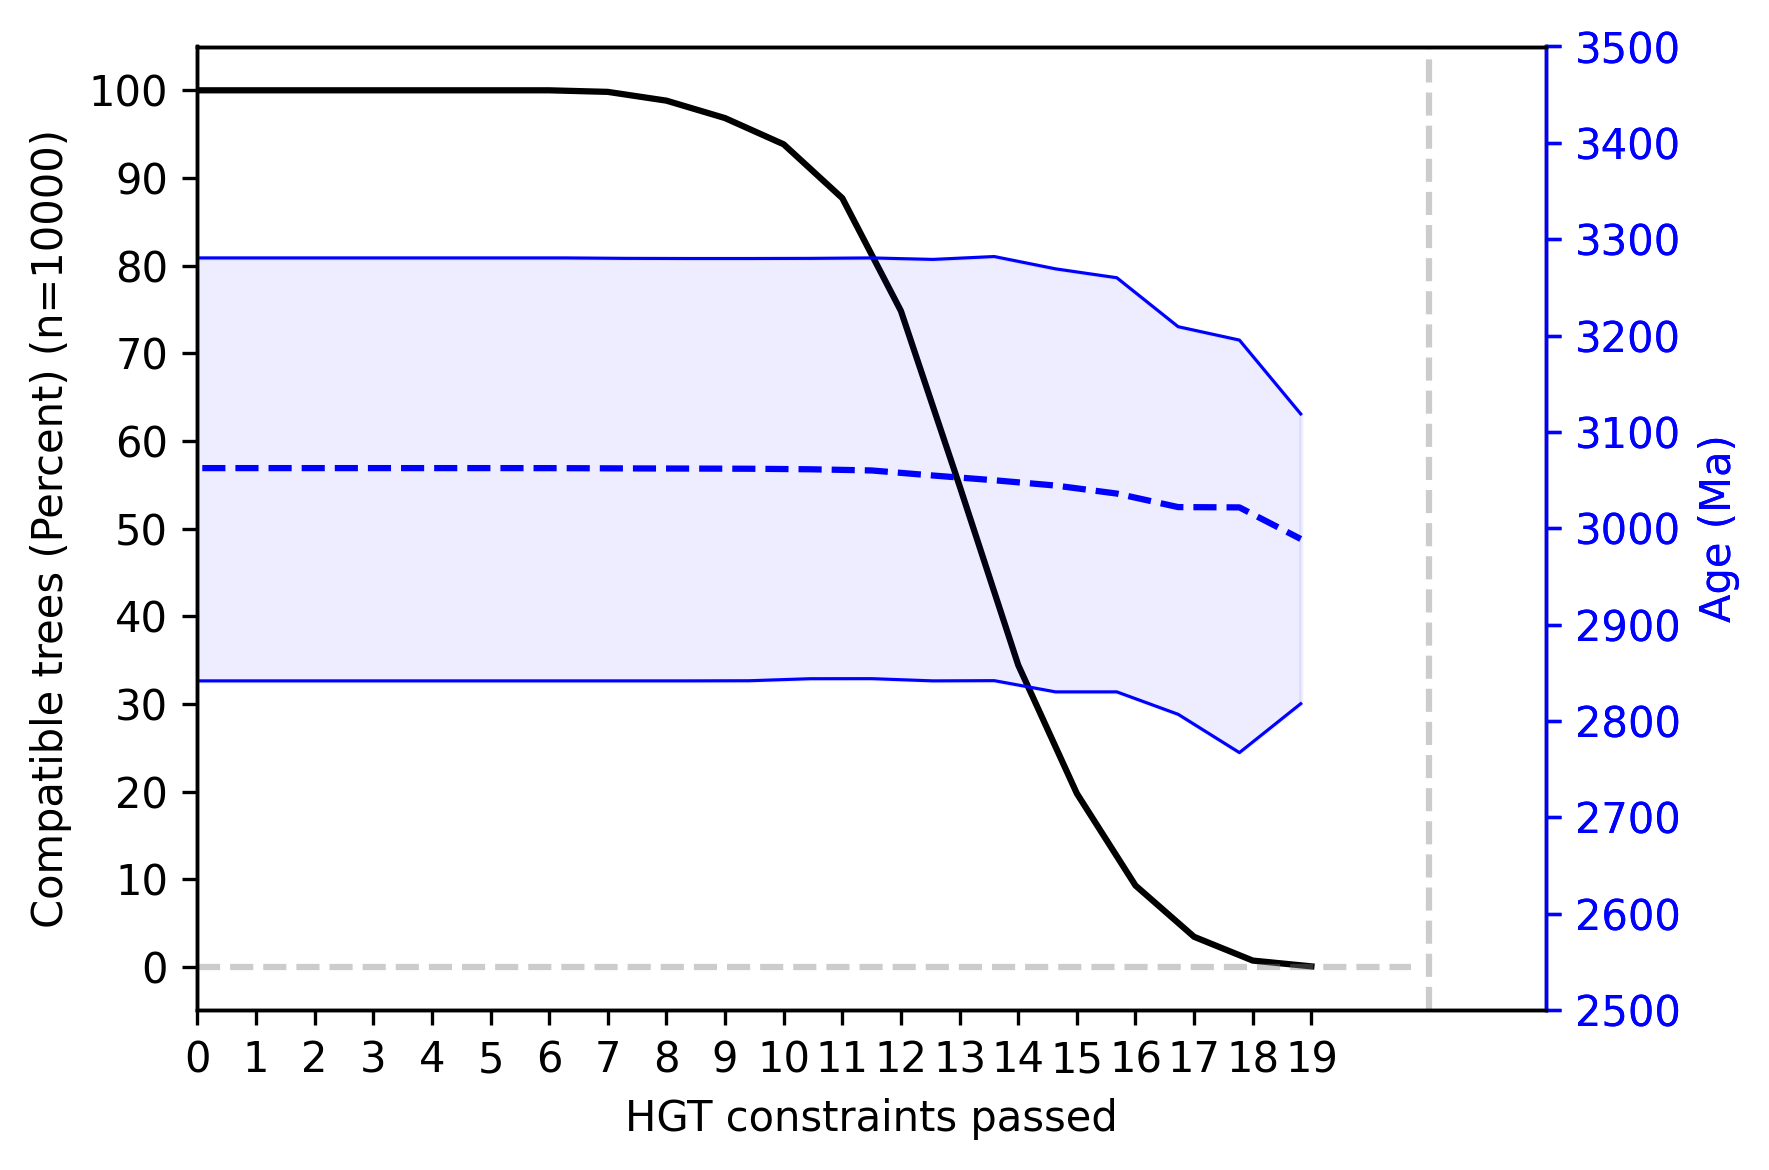

In [278]:
print('BE_ln_bd_post')
getCurve('BE_ln_bd_post',[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
BE_ln_bd_HGT = 18
print("HGT Selector set at:",BE_ln_bd_HGT)
print("Final Sample Size: ",len(BE_ln_bd_post_target_node_ages['177'][BE_ln_bd_HGT]))
#Notes: Curve set at 19
#picking @18 w/ 74 trees instead of @19;N=8 trees, @20 has 0 trees.

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator


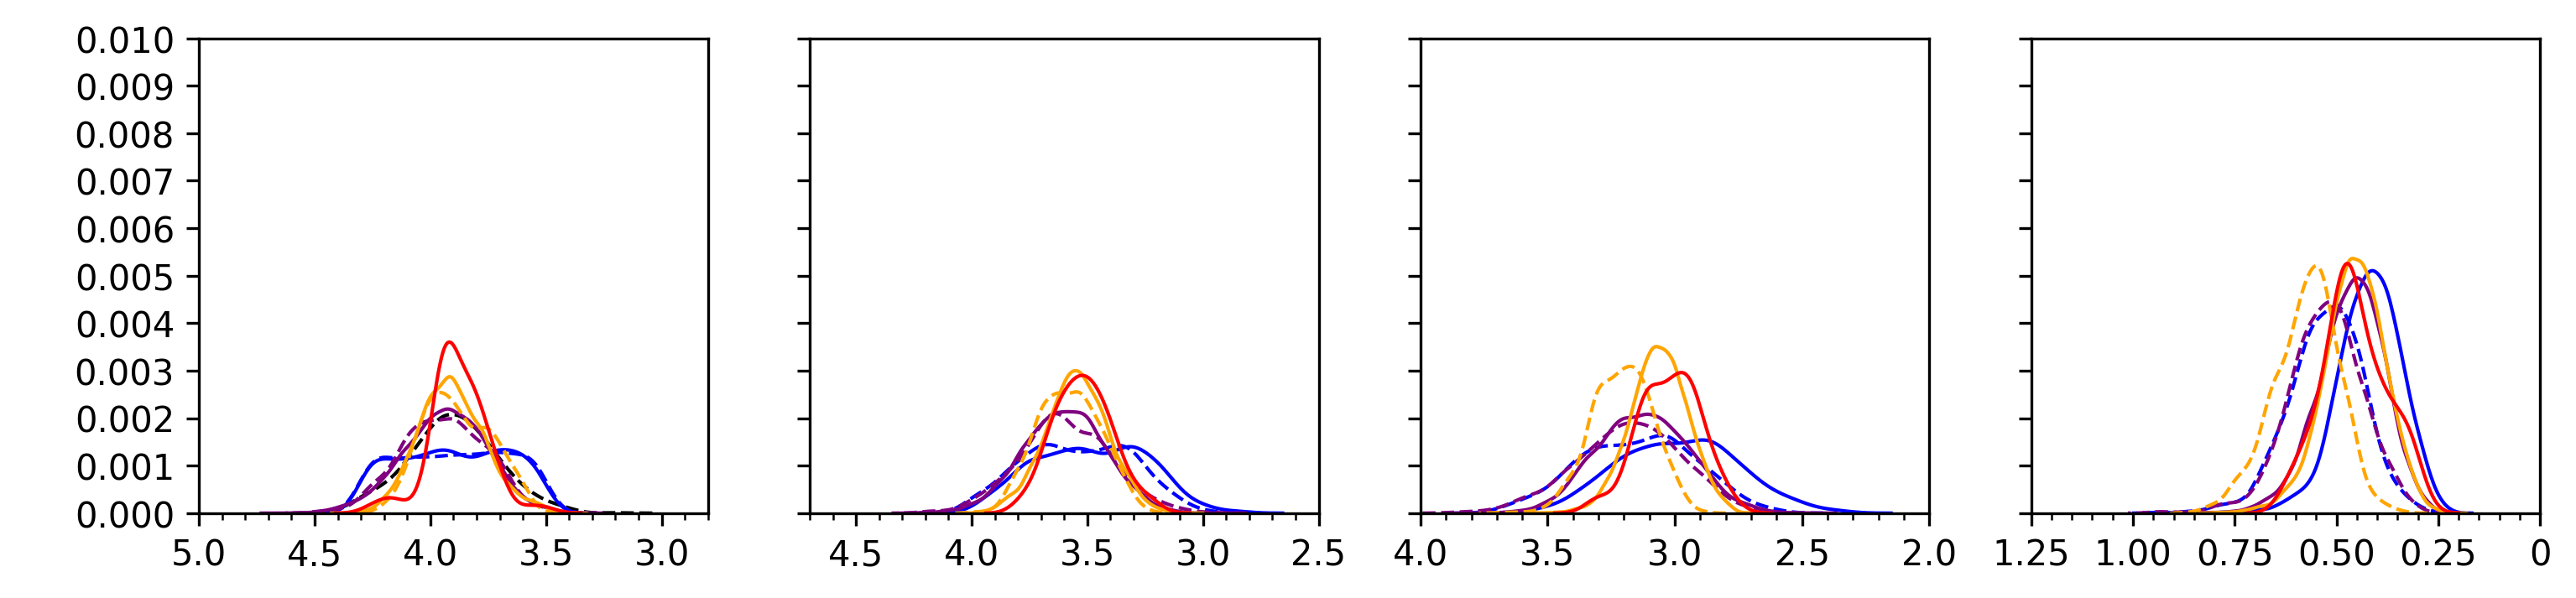

In [279]:
#Switch to KDE plot -- dist plot will die :-/
model_name='ln_bd'
run_name = 'CFig_without1CX'

kwargs = {"linewidth" : "1"}
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(1, 4, figsize=(12, 2.5), sharex=False,sharey=True,dpi=300)
axes[0].set_ylabel(" ")
#axes[0].set_ylabel("     Probability")
#axes[0].set_xlabel("                                                                                                                                           Age (Ma) ")
axes[0].set_ylim([0,0.010001])
axes[0].yaxis.set_ticks(np.arange(0,0.010001,0.001))

x0values = ['','3.0','3.5','4.0','4.5','5.0']
#axes[0].legend()
axes[0]=sns.kdeplot(root_prior_values,label="Crown Bacteria Root (170)",ax=axes[0],color="black",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(NF_ln_bd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="blue",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(NF_ln_bd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(BH_ln_bd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="purple",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(BH_ln_bd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="purple", **kwargs)
axes[0]=sns.kdeplot(BE_ln_bd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="orange",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(BE_ln_bd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="orange", **kwargs)
axes[0]=sns.kdeplot(BE_ln_bd_post_target_node_ages['170'][BE_ln_bd_HGT],label="Crown Bacteria Root (170)",ax=axes[0],color="red", **kwargs)
axes[0].set_xlim([5000,2800])
axes[0].xaxis.set_minor_locator(MultipleLocator(100))
axes[0].xaxis.set_major_locator(MultipleLocator(500))
axes[0].set_xticklabels(x0values)

x1values = ['','2.5','3.0','3.5','4.0','4.5']
#axes[1].legend()
axes[1]=sns.kdeplot(NF_ln_bd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="blue",linestyle='dashed', **kwargs)
axes[1]=sns.kdeplot(NF_ln_bd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="blue", **kwargs)
axes[1]=sns.kdeplot(BH_ln_bd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="purple", linestyle='dashed',**kwargs)
axes[1]=sns.kdeplot(BH_ln_bd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="purple", **kwargs)
axes[1]=sns.kdeplot(BE_ln_bd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="orange", linestyle='dashed',**kwargs)
axes[1]=sns.kdeplot(BE_ln_bd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="orange", **kwargs)
axes[1]=sns.kdeplot(BE_ln_bd_post_target_node_ages['172'][BE_ln_bd_HGT],label="Stem Cyanobacteria (172)",ax=axes[1],color="red", **kwargs)
axes[1].set_xlim([4700,2500])
axes[1].xaxis.set_minor_locator(MultipleLocator(100))
axes[1].xaxis.set_major_locator(MultipleLocator(500))
axes[1].set_xticklabels(x1values)

x2values = ['','2.0','2.5','3.0','3.5','4.0']
#axes[2].legend()
axes[2]=sns.kdeplot(NF_ln_bd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="blue",linestyle='dashed', **kwargs)
axes[2]=sns.kdeplot(NF_ln_bd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="blue", **kwargs)
axes[2]=sns.kdeplot(BH_ln_bd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="purple",linestyle='dashed', **kwargs)
axes[2]=sns.kdeplot(BH_ln_bd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="purple", **kwargs)
axes[2]=sns.kdeplot(BE_ln_bd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="orange",linestyle='dashed', **kwargs)
axes[2]=sns.kdeplot(BE_ln_bd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="orange", **kwargs)
axes[2]=sns.kdeplot(BE_ln_bd_post_target_node_ages['177'][BE_ln_bd_HGT], label="Crown Cyanobacteria (177)",ax=axes[2],color="red", **kwargs)
axes[2].set_xlim([4000,2000])
axes[2].xaxis.set_minor_locator(MultipleLocator(100))
axes[2].xaxis.set_major_locator(MultipleLocator(500))
axes[2].set_xticklabels(x2values)

x3values = ['','0','0.25','0.50','0.75','1.00','1.25']
#axes[3].legend()
axes[3]=sns.kdeplot(NF_ln_bd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="blue",linestyle='dashed', **kwargs)
axes[3]=sns.kdeplot(NF_ln_bd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="blue", **kwargs)
axes[3]=sns.kdeplot(BH_ln_bd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="purple",linestyle='dashed', **kwargs)
axes[3]=sns.kdeplot(BH_ln_bd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="purple", **kwargs)
axes[3]=sns.kdeplot(BE_ln_bd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="orange",linestyle='dashed', **kwargs)
axes[3]=sns.kdeplot(BE_ln_bd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="orange", **kwargs)
axes[3]=sns.kdeplot(BE_ln_bd_post_target_node_ages['281'][BE_ln_bd_HGT], label="Stem SynPro (281)",ax=axes[3],color="red", **kwargs)
axes[3].set_xlim([1250,0])
axes[3].xaxis.set_minor_locator(MultipleLocator(50))
axes[3].xaxis.set_major_locator(MultipleLocator(250))
axes[3].set_xticklabels(x3values)

#plt.show()
#plt.tight_layout()
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_'+'.png',format='png')
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_'+'.svg',format='svg')

BE_ln_nobd_post
No. HGTs: 0
Trees: 10000
Node 177
Mean 2926.7912320000005
Median 2923.6099999999997
Recent HPD 2715.58
Ancient HPD 3146.29
HGT Selector set at: 19
Final Sample Size:  67


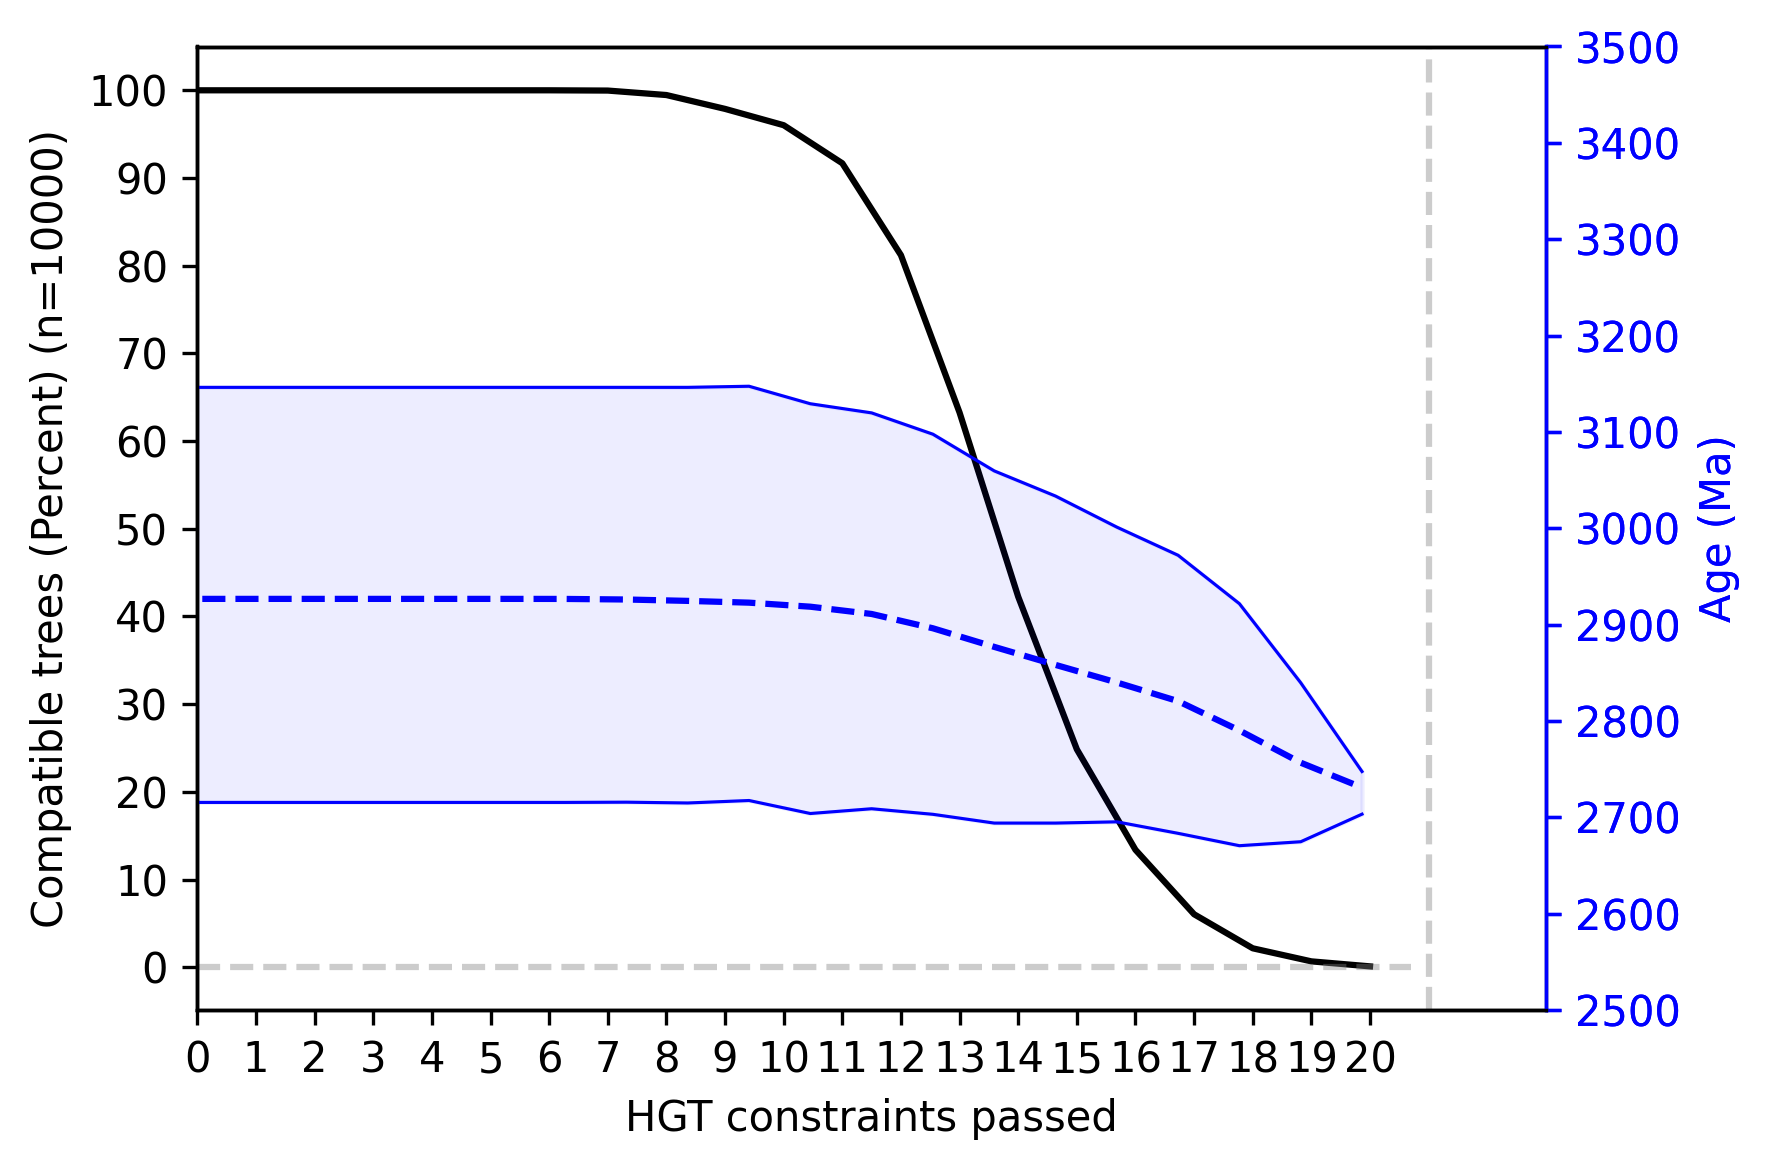

In [280]:
print('BE_ln_nobd_post')
getCurve('BE_ln_nobd_post',[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
BE_ln_nobd_HGT = 19
print("HGT Selector set at:",BE_ln_nobd_HGT)
print("Final Sample Size: ",len(BE_ln_nobd_post_target_node_ages['177'][BE_ln_nobd_HGT]))
#Notes: @19;N=67 @20;N=10, @21;n=0

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator


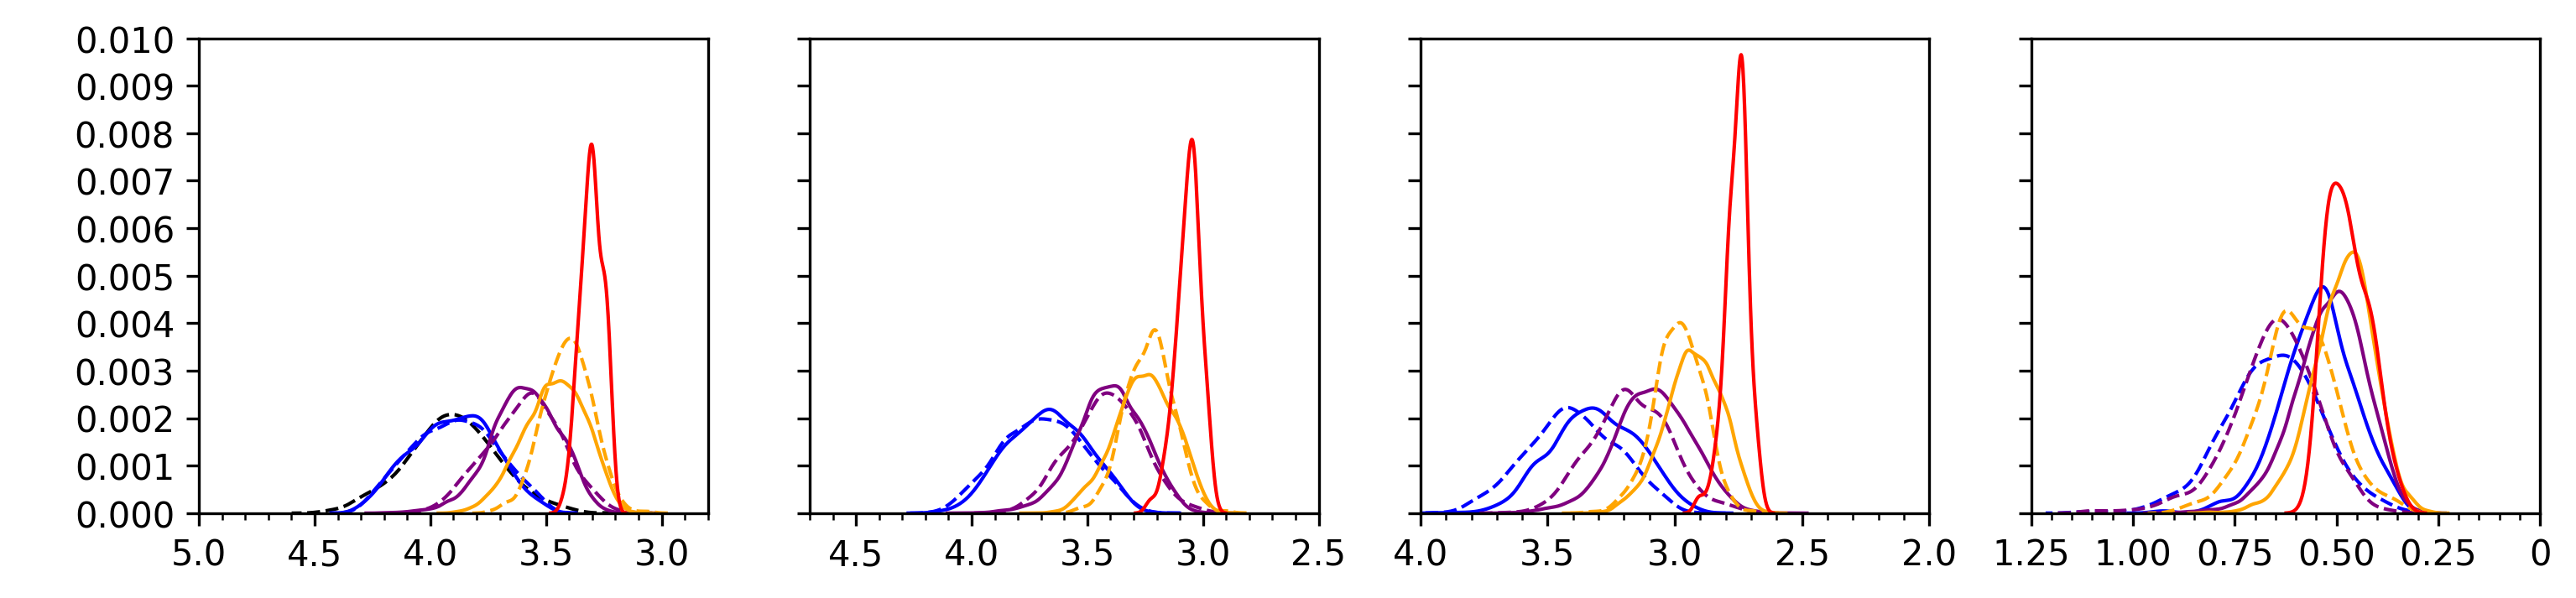

In [281]:
#Switch to KDE plot -- dist plot will die :-/
model_name='ln_nobd'
run_name = 'CFig_without1CX'

kwargs = {"linewidth" : "1"}
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(1, 4, figsize=(12, 2.5), sharex=False,sharey=True,dpi=300)
axes[0].set_ylabel(" ")
#axes[0].set_ylabel("     Probability")
#axes[0].set_xlabel("                                                                                                                                           Age (Ga) ")
axes[0].set_ylim([0,0.010001])
axes[0].yaxis.set_ticks(np.arange(0,0.010001,0.001))

x0values = ['','3.0','3.5','4.0','4.5','5.0']
#axes[0].legend()
axes[0]=sns.kdeplot(root_prior_values,label="Crown Bacteria Root (170)",ax=axes[0],color="black",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(NF_ln_nobd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="blue",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(NF_ln_nobd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(BH_ln_nobd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="purple",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(BH_ln_nobd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="purple", **kwargs)
axes[0]=sns.kdeplot(BE_ln_nobd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="orange",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(BE_ln_nobd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="orange", **kwargs)
axes[0]=sns.kdeplot(BE_ln_nobd_post_target_node_ages['170'][BE_ln_nobd_HGT],label="Crown Bacteria Root (170)",ax=axes[0],color="red", **kwargs)
axes[0].set_xlim([5000,2800])
axes[0].xaxis.set_minor_locator(MultipleLocator(100))
axes[0].xaxis.set_major_locator(MultipleLocator(500))
axes[0].set_xticklabels(x0values)

x1values = ['','2.5','3.0','3.5','4.0','4.5']
#axes[1].legend()
axes[1]=sns.kdeplot(NF_ln_nobd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="blue",linestyle='dashed', **kwargs)
axes[1]=sns.kdeplot(NF_ln_nobd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="blue", **kwargs)
axes[1]=sns.kdeplot(BH_ln_nobd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="purple", linestyle='dashed',**kwargs)
axes[1]=sns.kdeplot(BH_ln_nobd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="purple", **kwargs)
axes[1]=sns.kdeplot(BE_ln_nobd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="orange", linestyle='dashed',**kwargs)
axes[1]=sns.kdeplot(BE_ln_nobd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="orange", **kwargs)
axes[1]=sns.kdeplot(BE_ln_nobd_post_target_node_ages['172'][BE_ln_nobd_HGT],label="Stem Cyanobacteria (172)",ax=axes[1],color="red", **kwargs)
axes[1].set_xlim([4700,2500])
axes[1].xaxis.set_minor_locator(MultipleLocator(100))
axes[1].xaxis.set_major_locator(MultipleLocator(500))
axes[1].set_xticklabels(x1values)

x2values = ['','2.0','2.5','3.0','3.5','4.0']
#axes[2].legend()
axes[2]=sns.kdeplot(NF_ln_nobd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="blue",linestyle='dashed', **kwargs)
axes[2]=sns.kdeplot(NF_ln_nobd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="blue", **kwargs)
axes[2]=sns.kdeplot(BH_ln_nobd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="purple",linestyle='dashed', **kwargs)
axes[2]=sns.kdeplot(BH_ln_nobd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="purple", **kwargs)
axes[2]=sns.kdeplot(BE_ln_nobd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="orange",linestyle='dashed', **kwargs)
axes[2]=sns.kdeplot(BE_ln_nobd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[2],color="orange", **kwargs)
axes[2]=sns.kdeplot(BE_ln_nobd_post_target_node_ages['177'][BE_ln_nobd_HGT], label="Crown Cyanobacteria (177)",ax=axes[2],color="red", **kwargs)
axes[2].set_xlim([4000,2000])
axes[2].xaxis.set_minor_locator(MultipleLocator(100))
axes[2].xaxis.set_major_locator(MultipleLocator(500))
axes[2].set_xticklabels(x2values)

x3values = ['','0','0.25','0.50','0.75','1.00','1.25']
#axes[3].legend()
axes[3]=sns.kdeplot(NF_ln_nobd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="blue",linestyle='dashed', **kwargs)
axes[3]=sns.kdeplot(NF_ln_nobd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="blue", **kwargs)
axes[3]=sns.kdeplot(BH_ln_nobd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="purple",linestyle='dashed', **kwargs)
axes[3]=sns.kdeplot(BH_ln_nobd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="purple", **kwargs)
axes[3]=sns.kdeplot(BE_ln_nobd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="orange",linestyle='dashed', **kwargs)
axes[3]=sns.kdeplot(BE_ln_nobd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[3],color="orange", **kwargs)
axes[3]=sns.kdeplot(BE_ln_nobd_post_target_node_ages['281'][BE_ln_nobd_HGT], label="Stem SynPro (281)",ax=axes[3],color="red", **kwargs)
axes[3].set_xlim([1250,0])
axes[3].xaxis.set_minor_locator(MultipleLocator(50))
axes[3].xaxis.set_major_locator(MultipleLocator(250))
axes[3].set_xticklabels(x3values)

#plt.show()
#plt.tight_layout()
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_'+'.png',format='png')
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_'+'.svg',format='svg')

In [282]:
### End ###

In [283]:
#

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


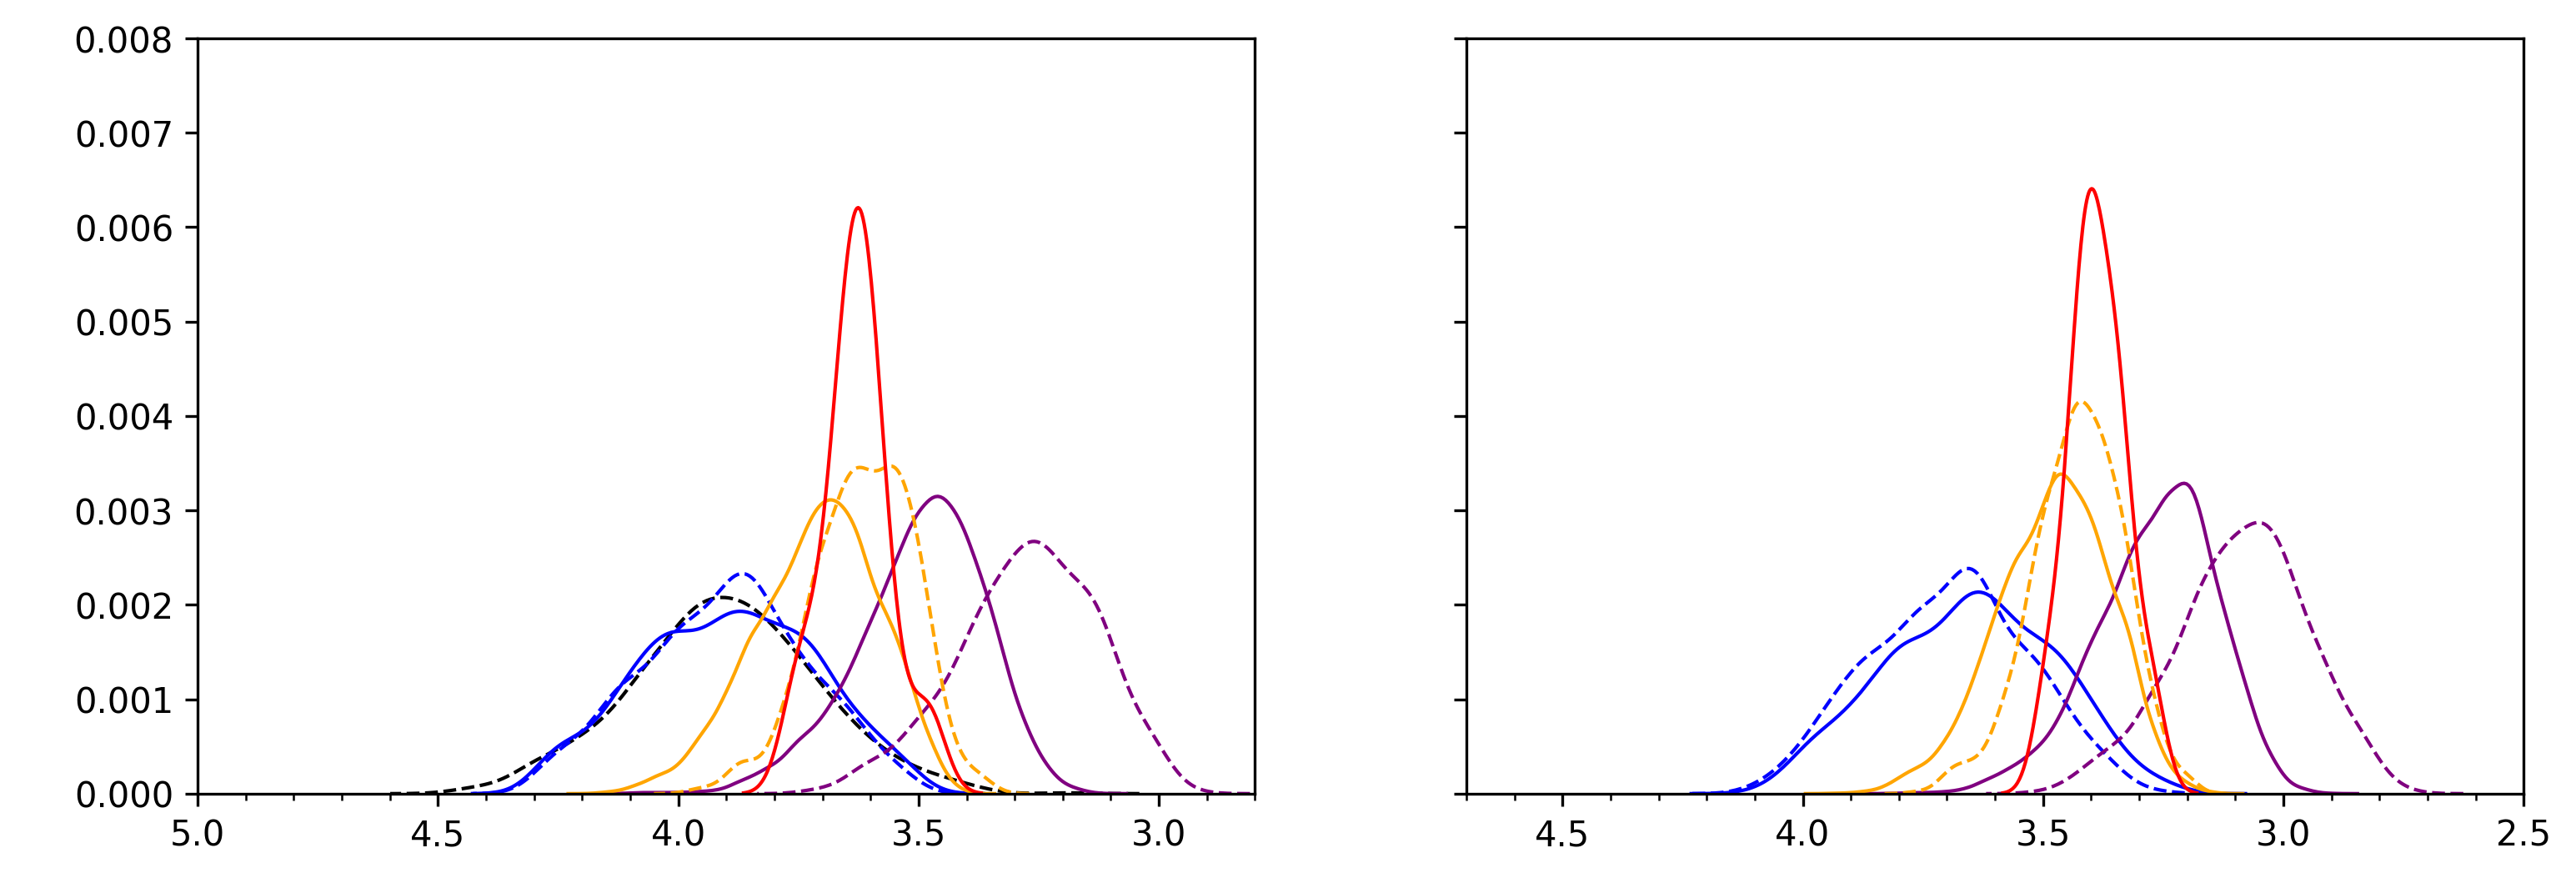

In [284]:
#Switch to KDE plot -- dist plot will die :-/
model_name='cir_nobd'
run_name = 'Figure_1_A_without_1CX'

kwargs = {"linewidth" : "1"}
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(1,2, figsize=(12, 4), sharex=False,sharey=True,dpi=300)

axes[0].set_ylabel(" ")
#axes[0].set_ylabel("     Probability")
#axes[0].set_xlabel("                                                                                                                                           Age (Ma) ")
axes[0].set_ylim([0,0.008001])
axes[0].yaxis.set_ticks(np.arange(0,0.008001,0.001))

x0values = ['','3.0','3.5','4.0','4.5','5.0']
#axes[0].legend()
axes[0]=sns.kdeplot(root_prior_values,label="Crown Bacteria Root (170)",ax=axes[0],color="black",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(NF_cir_nobd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="blue",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(NF_cir_nobd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(BH_cir_nobd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="purple",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(BH_cir_nobd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="purple", **kwargs)
axes[0]=sns.kdeplot(BE_cir_nobd_prior_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="orange",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['170'][0],label="Crown Bacteria Root (170)",ax=axes[0],color="orange", **kwargs)
axes[0]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['170'][BE_cir_nobd_HGT],label="Crown Bacteria Root (170)",ax=axes[0],color="red", **kwargs)
axes[0].set_xlim([5000,2800])
axes[0].xaxis.set_minor_locator(MultipleLocator(100))
axes[0].xaxis.set_major_locator(MultipleLocator(500))
axes[0].set_xticklabels(x0values)

x1values = ['','2.5','3.0','3.5','4.0','4.5']
#axes[1].legend()
axes[1]=sns.kdeplot(NF_cir_nobd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="blue",linestyle='dashed', **kwargs)
axes[1]=sns.kdeplot(NF_cir_nobd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="blue", **kwargs)
axes[1]=sns.kdeplot(BH_cir_nobd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="purple", linestyle='dashed',**kwargs)
axes[1]=sns.kdeplot(BH_cir_nobd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="purple", **kwargs)
axes[1]=sns.kdeplot(BE_cir_nobd_prior_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="orange", linestyle='dashed',**kwargs)
axes[1]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['172'][0],label="Stem Cyanobacteria (172)",ax=axes[1],color="orange", **kwargs)
axes[1]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['172'][BE_cir_nobd_HGT],label="Stem Cyanobacteria (172)",ax=axes[1],color="red", **kwargs)
axes[1].set_xlim([4700,2500])
axes[1].xaxis.set_minor_locator(MultipleLocator(100))
axes[1].xaxis.set_major_locator(MultipleLocator(500))
axes[1].set_xticklabels(x1values)

#plt.show()
#plt.tight_layout()
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_'+'.png',format='png')
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_'+'.svg',format='svg')

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator


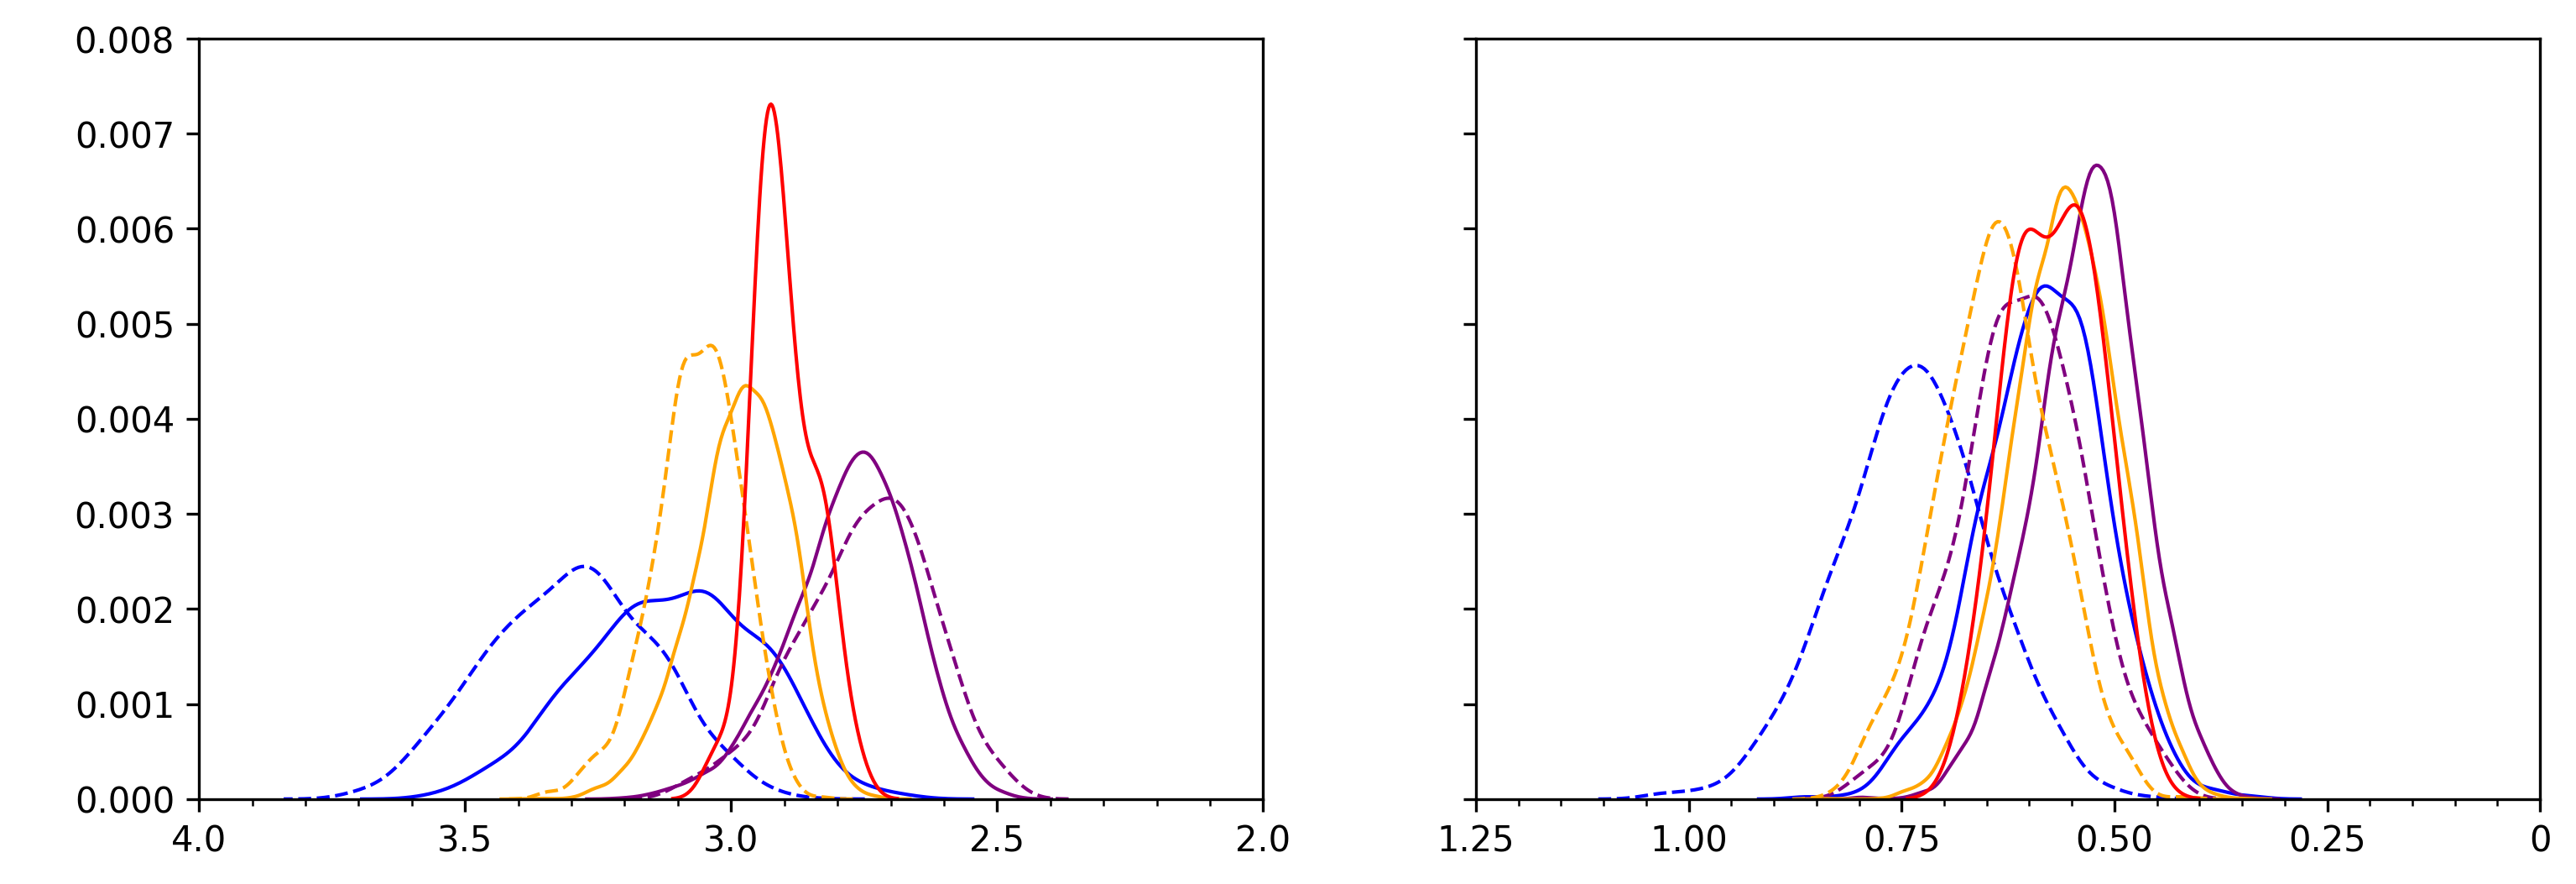

In [285]:
#Switch to KDE plot -- dist plot will die :-/
model_name='cir_nobd'
run_name = 'Figure_1_B_without_1CX'

kwargs = {"linewidth" : "1"}
#plt.figure(figsize=(10,7), dpi= 80)
fig, axes = plt.subplots(1,2, figsize=(12, 4), sharex=False,sharey=True,dpi=300)

axes[0].set_ylabel(" ")
#axes[0].set_ylabel("     Probability")
#axes[0].set_xlabel("                                                                                                                                           Age (Ma) ")
axes[0].set_ylim([0,0.008001])
axes[0].yaxis.set_ticks(np.arange(0,0.008001,0.001))

x1values = ['','2.0','2.5','3.0','3.5','4.0']
#axes[0].legend()
axes[0]=sns.kdeplot(NF_cir_nobd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[0],color="blue",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(NF_cir_nobd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[0],color="blue", **kwargs)
axes[0]=sns.kdeplot(BH_cir_nobd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[0],color="purple",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(BH_cir_nobd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[0],color="purple", **kwargs)
axes[0]=sns.kdeplot(BE_cir_nobd_prior_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[0],color="orange",linestyle='dashed', **kwargs)
axes[0]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['177'][0], label="Crown Cyanobacteria (177)",ax=axes[0],color="orange", **kwargs)
axes[0]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['177'][BE_cir_nobd_HGT], label="Crown Cyanobacteria (177)",ax=axes[0],color="red", **kwargs)
axes[0].set_xlim([4000,2000])
axes[0].xaxis.set_minor_locator(MultipleLocator(100))
axes[0].xaxis.set_major_locator(MultipleLocator(500))
axes[0].set_xticklabels(x1values)

x2values = ['','0','0.25','0.50','0.75','1.00','1.25']
#axes[2].legend()
axes[1]=sns.kdeplot(NF_cir_nobd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[1],color="blue",linestyle='dashed', **kwargs)
axes[1]=sns.kdeplot(NF_cir_nobd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[1],color="blue", **kwargs)
axes[1]=sns.kdeplot(BH_cir_nobd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[1],color="purple",linestyle='dashed', **kwargs)
axes[1]=sns.kdeplot(BH_cir_nobd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[1],color="purple", **kwargs)
axes[1]=sns.kdeplot(BE_cir_nobd_prior_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[1],color="orange",linestyle='dashed', **kwargs)
axes[1]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['281'][0], label="Stem SynPro (281)",ax=axes[1],color="orange", **kwargs)
axes[1]=sns.kdeplot(BE_cir_nobd_post_target_node_ages['281'][BE_cir_nobd_HGT], label="Stem SynPro (281)",ax=axes[1],color="red", **kwargs)
axes[1].set_xlim([1250,0])
axes[1].xaxis.set_minor_locator(MultipleLocator(50))
axes[1].xaxis.set_major_locator(MultipleLocator(250))
axes[1].set_xticklabels(x2values)

#plt.show()
#plt.tight_layout()
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_'+'.png',format='png')
fig.savefig(run_name+'_'+model_name+'_'+'NodeAge_'+'.svg',format='svg')

In [286]:
########################

In [287]:
#######################
#
#    END CURRENT ROUTINE!
#
########################

In [71]:
len(BE_cir_nobd_post_target_node_ages['177'][21])

28

No. HGTs: 0
Trees: 10000
Node 177
Mean 2980.256469
Median 2974.815
Recent HPD 2811.17
Ancient HPD 3161.65


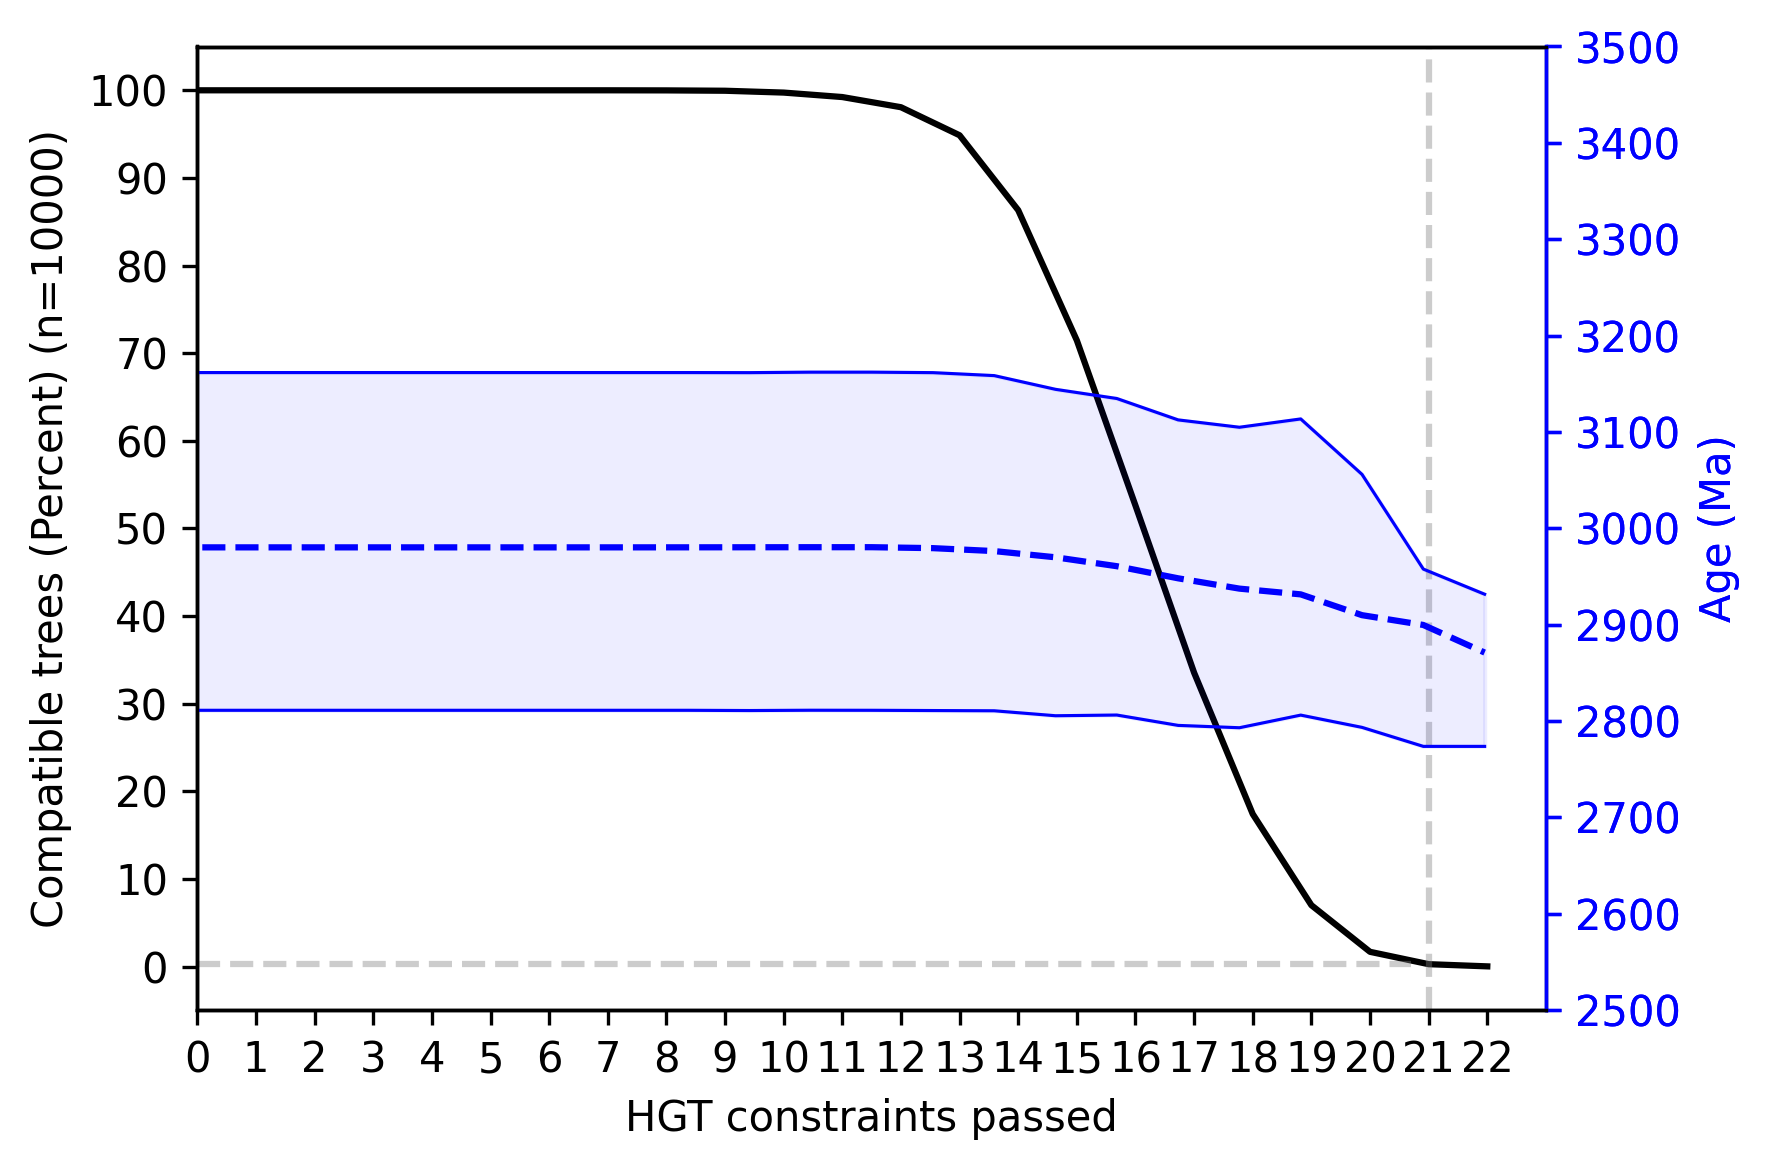

In [73]:
getCurve('BE_cir_nobd_post',[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]) #23 removed